In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torchvision
from torchvision import models
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import os

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
from sklearn.covariance import LedoitWolf, MinCovDet

from torchvision.transforms import transforms
from sklearn.metrics import roc_auc_score

np.random.seed(252525)
torch.manual_seed(252525)

import torch
import torch.nn as nn

from data.mvtec import *

from hugeica import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

MVTEC_PATH="/home/ios/data/mvtec"

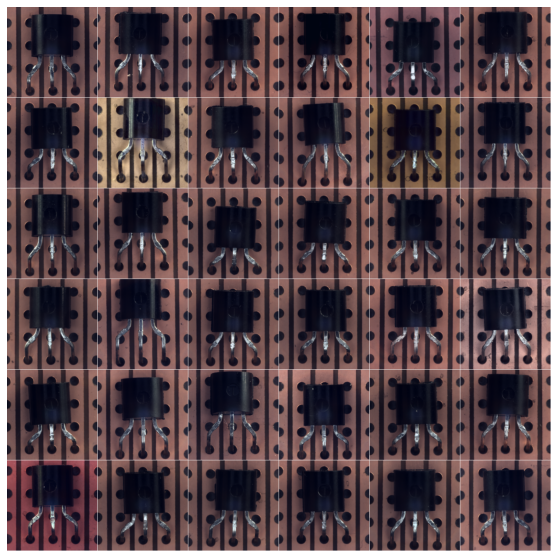

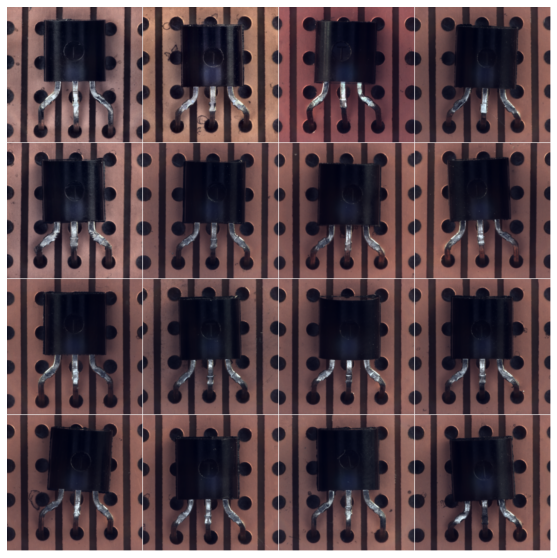

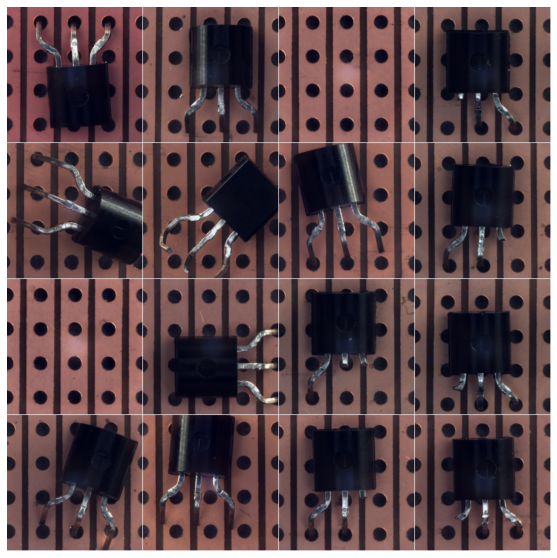

In [10]:
X_, X_valid_, X_test_, X_labels_, T = dataloader(14, P=224, s=224, label_per_patch=False, augment=True, MVTEC_PATH=MVTEC_PATH)
plt.rcParams["figure.figsize"] = (10, 10)
n = 16
show_filters_color(X_[:36].reshape(36, -1).T, C=3)
plt.show()
show_filters_color(X_valid_[:n].reshape(n, -1).T, C=3)
plt.show()
show_filters_color(X_test_[:n].reshape(n, -1).T, C=3)

In [19]:
MVTEC.CLASSES

['bottle',
 'carpet',
 'leather',
 'pill',
 'tile',
 'wood',
 'cable',
 'grid',
 'toothbrush',
 'zipper',
 'capsule',
 'hazelnut',
 'metal_nut',
 'screw',
 'transistor']

# Mean-Shift Stats

# Fit SpatialICA(100).
# Fit HugeICA((5475, 2448, 100), device='cuda', bs=10000)
# Fit SFA(100).
auc 0.741523733546071


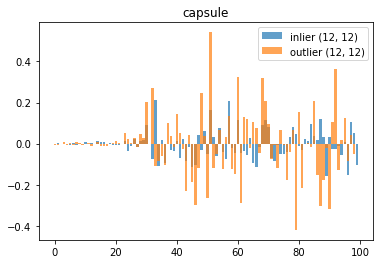

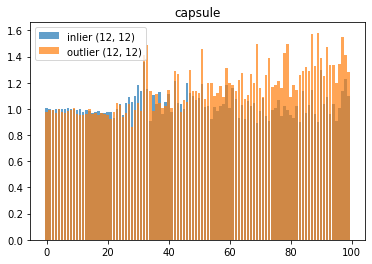

In [80]:
clazz = 10
class_name = MVTEC.CLASSES[clazz]

X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False)

net = models.efficientnet_b4(pretrained=True).features[:7]
net = net.to(device)
net.eval()

with torch.no_grad():
    X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
    X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
    X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

X_, X_valid_, X_test_,  mean, std = preprocessing(X_, X_valid_, X_test_, None, None, None)

for bsz in [3]:
    model = SFA(shape=(272, 7, 7), 
                   BSZ=(bsz, bsz), 
                   stride=1, 
                   n_components=100,
                   mode="ta")
    model.fit(X_, 1, bs=10000, logging=-1)
    
    S_in = model.transform(np.asarray(X_valid_), agg="mean")
    S_out = model.transform(np.asarray(X_test_), agg="mean")
        
    auc = roc_auc_score([0] * len(S_in) + [1] * len(S_out), np.concatenate([np.linalg.norm(S_in, axis=1, ord=2), np.linalg.norm(S_out, axis=1, ord=2)]))
    
    print("auc", auc)
   
S0 = model.transform(np.asarray(X_valid_), agg="none", act = lambda x: x)
S0_ = model.transform(np.asarray(X_test_), agg="none", act = lambda x: x)

plt.bar(range(S0.shape[2]), np.mean(S0.reshape(-1, S0.shape[2]), axis=0), label="inlier (12, 12)", alpha=0.7)
plt.bar(range(S0.shape[2]), np.mean(S0_.reshape(-1, S0.shape[2]), axis=0), label="outlier (12, 12)", alpha=0.7 )
plt.legend()
plt.title(f"{class_name}")
plt.show()

plt.bar(range(S0.shape[2]), np.var(S0.reshape(-1, S0.shape[2]), axis=0), label="inlier (12, 12)", alpha=0.7)
plt.bar(range(S0.shape[2]), np.var(S0_.reshape(-1, S0.shape[2]), axis=0), label="outlier (12, 12)", alpha=0.7 )
plt.legend()
plt.title(f"{class_name}")
plt.show()


# Fit SpatialICA(10).
# Fit HugeICA((28656, 1440, 10), device='cuda', bs=9936)
# Fit SFA(10).
Total AUC 0.6453928998803351


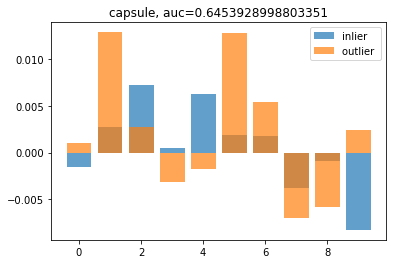

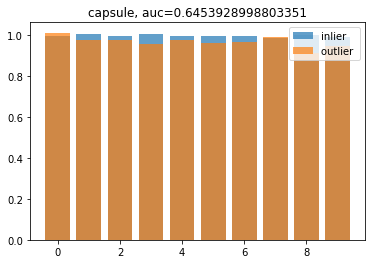

In [6]:
bs = 20
t = 14 # tile_size
p = 3 # patch_size
s = 1 # stride

clazz = 10
class_name = MVTEC.CLASSES[clazz]

X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False)

net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net.eval()

with torch.no_grad():
    X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
    X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
    X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

X_, X_valid_, X_test_,  mean, std = preprocessing(X_, X_valid_, X_test_, None, None, None)

# DC
X_, X_valid_, X_test_ = X_ - X_.mean((1,2,3), keepdims=True), X_valid_ - X_valid_.mean((1,2,3), keepdims=True), X_test_ - X_test_.mean((1,2,3), keepdims=True)

# Contrast
X_, X_valid_, X_test_ = X_ / np.linalg.norm(X_.reshape(len(X_), -1), axis=1, keepdims=True)[:, :, None, None], X_valid_ / np.linalg.norm(X_valid_.reshape(len(X_valid_), -1), axis=1, keepdims=True)[:, :, None, None], X_test_ / np.linalg.norm(X_test_.reshape(len(X_test_), -1), axis=1, keepdims=True)[:, :, None, None]

X_val_ = X_[:20]
X_ = X_[20:]

# Rescale
scale = X_.std()
X_ = X_ / scale
X_val_ = X_val_ / scale
X_valid_ = X_valid_ / scale
X_test_ = X_test_ / scale

model_scores_in1 = []
model_scores_out1 = []

n_tiles = X_.shape[2] // t
c = X_.shape[1]

for i in range(n_tiles):
    for j in range(n_tiles):

        X = X_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        X_val = X_val_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        X_in = X_valid_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        X_out = X_test_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]

        model = SFA(shape=(c, t, t), 
                    BSZ=(p, p), 
                    stride=s, 
                    n_components=10,
                    mode="ta")
        model.fit(X, 1, bs=10000, logging=-1)

        S_in = model.transform(np.asarray(X_in), agg="none")
        S_out = model.transform(np.asarray(X_out), agg="none")
        model_scores_in1.append(S_in)
        model_scores_out1.append(S_out)
    
model_scores_in1 = np.concatenate(model_scores_in1, axis=2) # N, T, C
model_scores_out1 = np.concatenate(model_scores_out1, axis=2) # N, T, C
        
score_in1 = np.linalg.norm( model_scores_in1.mean(1), axis=1)
score_out1 = np.linalg.norm( model_scores_out1.mean(1), axis=1)
auc1 = roc_auc_score([0] * len(score_in1) + [1] * len(score_out1), np.concatenate([score_in1, score_out1]))        
print("Total AUC", auc1)

S0 = model_scores_in1.reshape(-1, model_scores_in1.shape[2])
S0_ = model_scores_out1.reshape(-1, model_scores_out1.shape[2])

plt.bar(range(S0.shape[1]), np.mean(S0, axis=0), label="inlier ", alpha=0.7)
plt.bar(range(S0.shape[1]), np.mean(S0_, axis=0), label="outlier ", alpha=0.7 )
plt.legend()
plt.title(f"{class_name}, auc={auc1}")
plt.show()

plt.bar(range(S0.shape[1]), np.var(S0, axis=0), label="inlier ", alpha=0.7)
plt.bar(range(S0.shape[1]), np.var(S0_, axis=0), label="outlier ", alpha=0.7 )
plt.legend()
plt.title(f"{class_name}, auc={auc1}")
plt.show()

256 64
# Fit SpatialICA(640).
# Fit HugeICA((2304, 640, 640), device='cuda', bs=999)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_SO.py:46: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1937.)
  self.weight.data = torch.qr(torch.distributions.Normal(0,0.01).sample(self.weight.data.shape))[0]
/home/matthias/Desktop/workspace/fasterica/hugeica/helpers/expm32.py:262: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).s

# Fit SFA(640).
Mean-Shift-Val 11.458134 n_comps < 1e-1 640
# Fit SpatialICA(640).
# Fit HugeICA((2304, 640, 640), device='cuda', bs=999)
# Fit SFA(640).
Mean-Shift-Val 12.082548 n_comps < 1e-1 640
# Fit SpatialICA(640).
# Fit HugeICA((2304, 640, 640), device='cuda', bs=999)
# Fit SFA(640).
Mean-Shift-Val 11.585745 n_comps < 1e-1 640
# Fit SpatialICA(640).
# Fit HugeICA((2304, 640, 640), device='cuda', bs=999)
# Fit SFA(640).
Mean-Shift-Val 11.789721 n_comps < 1e-1 640
# Fit SpatialICA(640).
# Fit HugeICA((2304, 640, 640), device='cuda', bs=999)
# Fit SFA(640).
Mean-Shift-Val 11.695121 n_comps < 1e-1 640
# Fit SpatialICA(640).
# Fit HugeICA((2304, 640, 640), device='cuda', bs=999)
# Fit SFA(640).
Mean-Shift-Val 12.298376 n_comps < 1e-1 640
# Fit SpatialICA(640).
# Fit HugeICA((2304, 640, 640), device='cuda', bs=999)
# Fit SFA(640).
Mean-Shift-Val 11.856953 n_comps < 1e-1 640
# Fit SpatialICA(640).
# Fit HugeICA((2304, 640, 640), device='cuda', bs=999)
# Fit SFA(640).
Mean-Shift-Val 11.

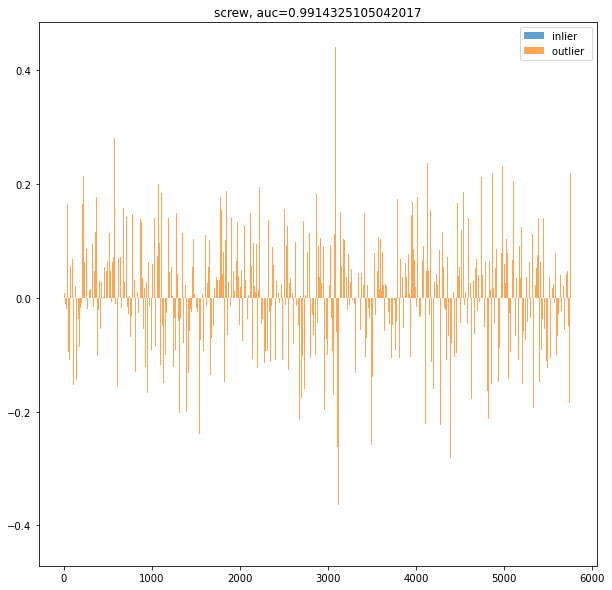

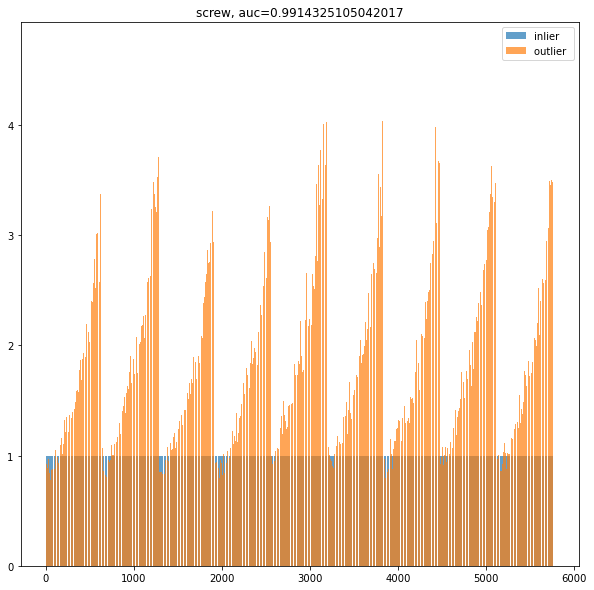

In [ ]:
def bootstrap_mean(X, n=100, p=0.1, axis=0):
    means = []
    for i in range(n):
        idx = np.random.choice(range(len(X)), size=int(p*len(X)))
        means.append(X[idx].mean(axis, keepdims=True))
    return np.asarray(means).mean(0)


bs = 20
t = 4 # tile_size
p = 2 # patch_size
s = 1 # stride

clazz = 13
class_name = MVTEC.CLASSES[clazz]

X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False)

net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net.eval()

with torch.no_grad():
    X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
    X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
    X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

X_, X_valid_, X_test_,  mean, std = preprocessing(X_, X_valid_, X_test_, None, None, None)

# DC
X_, X_valid_, X_test_ = X_ - X_.mean((1,2,3), keepdims=True), X_valid_ - X_valid_.mean((1,2,3), keepdims=True), X_test_ - X_test_.mean((1,2,3), keepdims=True)

# Contrast
X_, X_valid_, X_test_ = X_ / np.linalg.norm(X_.reshape(len(X_), -1), axis=1, keepdims=True)[:, :, None, None], X_valid_ / np.linalg.norm(X_valid_.reshape(len(X_valid_), -1), axis=1, keepdims=True)[:, :, None, None], X_test_ / np.linalg.norm(X_test_.reshape(len(X_test_), -1), axis=1, keepdims=True)[:, :, None, None]

X_val_ = X_[:int(len(X_)*0.2)]
X_ = X_[int(len(X_)*0.2):]
print(len(X_), len(X_val_))

# Rescale
scale = X_.std()
X_ = X_ / scale
X_val_ = X_val_ / scale
X_valid_ = X_valid_ / scale
X_test_ = X_test_ / scale

model_scores_in1 = []
model_scores_out1 = []

n_tiles = X_.shape[2] // t
c = X_.shape[1]

for i in range(n_tiles):
    for j in range(n_tiles):

        X = X_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        X_val = X_val_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        X_in = X_valid_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        X_out = X_test_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]

        model = SFA(shape=(c, t, t), 
                    BSZ=(p, p), 
                    stride=s, 
                    n_components="max",
                    min_components=100,
                    mode="ta")
        model.fit(X, 1, bs=1000, logging=-1)
        #model.model.net.whiten.var_expl.data = (model.model.net.whiten.var_expl.data * 0 + 1).to(model.model.device)
        #model.model.net.whiten.weight.data = torch.eye(model.model.net.whiten.weight.data.shape[1])[:model.model.net.whiten.weight.data.shape[0]].to(model.model.device)
        
        # boot_mean = bootstrap_mean( model.model.i2col(torch.from_numpy(X)).numpy() )
        # model.model.net.whiten.mean_.data = torch.from_numpy(boot_mean).to(model.model.device)
        #print(np.power(X.reshape(len(X), -1).mean(0) - bootstrap_mean(X).reshape(-1), 2).mean())
        #print(np.power(X_val.reshape(len(X_val), -1).mean(0) - bootstrap_mean(X).reshape(-1), 2).mean())
        #print(np.power(X_val.reshape(len(X_val), -1).mean(0) - X.reshape(len(X), -1).mean(0), 2).mean())
        
        #print(np.power(X_in.reshape(len(X_in), -1).mean(0) - bootstrap_mean(X).reshape(-1), 2).mean())
        #print(np.power(X_in.reshape(len(X_in), -1).mean(0) - X.reshape(len(X), -1).mean(0), 2).mean())
        
        S_val = model.transform(np.asarray(X_val), agg="none")
        idx = np.abs(S_val.mean(1).mean(0)) < 100
        print("Mean-Shift-Val", np.linalg.norm( S_val.mean(1)[:, idx], axis=1 ).mean(0), "n_comps < 1e-1", idx.sum())
        
        S_in = model.transform(np.asarray(X), agg="none")[:, :, idx]
        S_out = model.transform(np.asarray(X_out), agg="none")[:, :, idx]
        model_scores_in1.append(S_in)
        model_scores_out1.append(S_out)
                
model_scores_in1 = np.concatenate(model_scores_in1, axis=2) # N, T, C
model_scores_out1 = np.concatenate(model_scores_out1, axis=2) # N, T, C
        
score_in1 = np.linalg.norm( model_scores_in1.mean(1), axis=1)
score_out1 = np.linalg.norm( model_scores_out1.mean(1), axis=1)
auc1 = roc_auc_score([0] * len(score_in1) + [1] * len(score_out1), np.concatenate([score_in1, score_out1]))        
print("Total AUC", auc1)

S0 = model_scores_in1.reshape(-1, model_scores_in1.shape[2])
S0_ = model_scores_out1.reshape(-1, model_scores_out1.shape[2])

plt.bar(range(S0.shape[1]), np.mean(S0, axis=0), label="inlier ", alpha=0.7)
plt.bar(range(S0.shape[1]), np.mean(S0_, axis=0), label="outlier ", alpha=0.7 )
plt.legend()
plt.title(f"{class_name}, auc={auc1}")
plt.show()

plt.bar(range(S0.shape[1]), np.var(S0, axis=0), label="inlier ", alpha=0.7)
plt.bar(range(S0.shape[1]), np.var(S0_, axis=0), label="outlier ", alpha=0.7 )
plt.legend()
plt.title(f"{class_name}, auc={auc1}")
plt.show()

# Evaluating Likelihood and Reconstruction loss

In [103]:
bs = 50
#for conf in ["VGG19", "VGG16", "VGG11", "VGG09", "VGG07", "VGG05", "VGG03"]:

logs = []

for clazz in range(0,15):
    
    scores_inliers = []
    scores_outliers = []

    for conf in range(10, 11, 1):

        net = models.efficientnet_b4(pretrained=True).features[:6]
        net = net.to(device)
        
        net = net.to(device)
        net.eval()

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False)
        
        with torch.no_grad():
            X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
            X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
            X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()
        
        shape = net( torch.normal(0, 1, (1, 3, 224, 224)).to(device)  )[0].shape
        
        print(shape)
        
        hyp = SFA.hyperparameter_search(X_, X_valid_, X_test_, 
                      patch_size=range(6,15,2), 
                      n_components=[ "q90" ], 
                      stride=[1], 
                      shape=shape, 
                      bs=5000, 
                      epochs=1,
                      remove_components = [0],
                      max_components=7000,
                      norm=[2], 
                      mode="ta", 
                      compute_bpd = True,
                      aucs=["mean", "sum", "avg_patch_reconstruct", "avg_reconstruct"],
                      preprocess = preprocessing) 

        display(hyp)
        
        logs.append(hyp)
        
        print(MVTEC.CLASSES[clazz])        

torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((16929, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 2106
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(138).
# Fit HugeICA((16929, 5760, 138), device='cuda', bs=4941)
# Compute ICA metrics.
# Fit SFA(138).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((10241, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 245
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(158).
# Fit HugeICA((10241, 10240, 158), device='cuda', bs=4998)
# Compute ICA metrics.
# Fit SFA(158).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((5225, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 225
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(154).
# Fit HugeICA((5225, 16000, 154), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(154).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((1881, 23040, 1881), device='cuda', bs=4995)
# Re-Fit SpatialICA(104).
# Fit HugeICA((1881, 23040, 104), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(104).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((209, 31360, 209), device='cuda', bs=5000)
# Re-Fit SpatialICA(128).
# Fit HugeICA((209, 31360, 128), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(128).
# Compute Information Measures
# Compute AUCs


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0         138.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0         158.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0         154.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0         104.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0         128.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.924781  1730.191406  ...       0.0   0.087204       0.000633  0.173009   
1  0.585270  1695.573242  ...       0.0   0.074789       0.000469  0.190449   
2  0.366870  1562.461060  ...       0.0   0.065642       0.000419  0.169974   
3  0.299307  1467.061035  ...       0.0   0.031216       0.000292  0.123135   
4       NaN  1215.397949  ...       0.0  22.354532       0.174690  0.135071   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.163450  0.997619  0.895238  0.895238               0.996032   
1  4.120055  0.996825  0.923810  0.923810               0.998413   
2  4.034052  0.997619  0.915079  0.915079               1.000000   
3  3.922171  0.999206  0.884127  0.884127               1.000000   
4       NaN  1.000000  0.894444  0.894444               1.000000   

   avg_reconstruct  
0         0.998413  
1         0.997619  
2         0.997619  
3         0.999206  
4         1.000000  

[5 rows x 38 columns]

bottle
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((22680, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 2916
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(812).
# Fit HugeICA((22680, 5760, 812), device='cuda', bs=4941)
# Compute ICA metrics.
# Fit SFA(812).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((13720, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 3724
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1178).
# Fit HugeICA((13720, 10240, 1178), device='cuda', bs=4998)
# Compute ICA metrics.
# Fit SFA(1178).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((7000, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 2000
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1435).
# Fit HugeICA((7000, 16000, 1435), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(1435).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((2520, 23040, 2520), device='cuda', bs=4995)
# Re-Fit SpatialICA(1121).
# Fit HugeICA((2520, 23040, 1121), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(1121).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((280, 31360, 280), device='cuda', bs=5000)
# Re-Fit SpatialICA(220).
# Fit HugeICA((280, 31360, 220), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(220).
# Compute Information Measures
# Compute AUCs


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0         812.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0        1178.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0        1435.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0        1121.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0         220.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.231010  1709.063721  ...       0.0   0.103140       0.000128  0.681674   
1  0.132420  1690.113647  ...       0.0   0.096947       0.000082  0.992117   
2  0.083691  1553.411621  ...       0.0   0.098423       0.000069  1.172802   
3  0.054288  1743.825195  ...       0.0   0.116038       0.000105  0.912893   
4       NaN  3312.687012  ...       0.0  38.159470       0.174450  0.183813   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  3.719672  0.991573  0.821027  0.821027               0.997592   
1  3.693578  0.991573  0.907303  0.907303               0.997994   
2  3.635314  0.993178  0.943820  0.943820               0.999197   
3  3.519114  0.993579  0.981541  0.981541               0.994382   
4       NaN  0.988764  0.874398  0.874398               0.988764   

   avg_reconstruct  
0         0.907705  
1         0.933387  
2         0.959872  
3         0.984350  
4         0.988764  

[5 rows x 38 columns]

carpet
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((19845, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 81
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(934).
# Fit HugeICA((19845, 5760, 934), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=934 must be less or equal to the batch number of samples 81
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(934).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((12005, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 2009
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1329).
# Fit HugeICA((12005, 10240, 1329), device='cuda', bs=4998)
# Compute ICA metrics.
# Fit SFA(1329).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((6125, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 1125
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1550).
# Fit HugeICA((6125, 16000, 1550), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1550 must be less or equal to the batch number of samples 1125
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(1550).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((2205, 23040, 2205), device='cuda', bs=4995)
# Re-Fit SpatialICA(1082).
# Fit HugeICA((2205, 23040, 1082), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(1082).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((245, 31360, 245), device='cuda', bs=5000)
# Re-Fit SpatialICA(198).
# Fit HugeICA((245, 31360, 198), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(198).
# Compute Information Measures
# Compute AUCs


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0         934.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0        1329.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0        1550.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0        1082.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0         198.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.187358  1904.230347  ...       0.0   0.128792       0.000137  0.876162   
1  0.116011  1882.000610  ...       0.0   0.101410       0.000076  1.252843   
2  0.081541  1767.516479  ...       0.0   0.094551       0.000061  1.455891   
3  0.075530  2158.460693  ...       0.0   0.137864       0.000125  1.029553   
4       NaN  3702.933350  ...       0.0  34.567772       0.174305  0.183122   

      H_max  lhd      mean       sum  avg_patch_reconstruct  avg_reconstruct  
0  3.752522  1.0  1.000000  1.000000                    1.0              1.0  
1  3.725617  1.0  1.000000  1.000000                    1.0              1.0  
2  3.651106  1.0  1.000000  1.000000                    1.0              1.0  
3  3.554712  1.0  1.000000  1.000000                    1.0              1.0  
4       NaN  1.0  0.766644  0.766644                    1.0              1.0  

[5 rows x 38 columns]

leather
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((21627, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 1863
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(591).
# Fit HugeICA((21627, 5760, 591), device='cuda', bs=4941)
# Compute ICA metrics.
# Fit SFA(591).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((13083, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 3087
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(750).
# Fit HugeICA((13083, 10240, 750), device='cuda', bs=4998)
# Compute ICA metrics.
# Fit SFA(750).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((6675, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 1675
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(813).
# Fit HugeICA((6675, 16000, 813), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(813).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((2403, 23040, 2403), device='cuda', bs=4995)
# Re-Fit SpatialICA(571).
# Fit HugeICA((2403, 23040, 571), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(571).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((267, 31360, 267), device='cuda', bs=5000)
# Re-Fit SpatialICA(184).
# Fit HugeICA((267, 31360, 184), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(184).
# Compute Information Measures


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0         591.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0         750.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0         813.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0         571.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0         184.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.246464  2547.361816  ...       0.0   0.097355       0.000164  0.508764   
1  0.126973  2575.340088  ...       0.0   0.075047       0.000100  0.642897   
2  0.101811  2495.364014  ...       0.0   0.078705       0.000096  0.705978   
3  0.088515  2600.211182  ...       0.0   0.068889       0.000123  0.492093   
4       NaN  3607.199951  ...       0.0  32.128876       0.174252  0.156847   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.413876  0.943262  0.674032  0.674032               0.912439   
1  4.377197  0.952264  0.660120  0.660120               0.912439   
2  4.279572  0.966994  0.712493  0.712493               0.939444   
3  4.119880  0.974359  0.749591  0.749591               0.963721   
4       NaN  0.976541  0.385706  0.385706               0.976541   

   avg_reconstruct  
0         0.894435  
1         0.909438  
2         0.926896  
3         0.949809  
4         0.976541  

[5 rows x 38 columns]

pill
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((18630, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 3807
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1407).
# Fit HugeICA((18630, 5760, 1407), device='cuda', bs=4941)
# Compute ICA metrics.
# Fit SFA(1407).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((11270, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 1274
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1876).
# Fit HugeICA((11270, 10240, 1876), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1876 must be less or equal to the batch number of samples 1274
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(1876).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((5750, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 750
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(2062).
# Fit HugeICA((5750, 16000, 2062), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2062 must be less or equal to the batch number of samples 750
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(2062).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((2070, 23040, 2070), device='cuda', bs=4995)
# Re-Fit SpatialICA(1232).
# Fit HugeICA((2070, 23040, 1232), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(1232).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((230, 31360, 230), device='cuda', bs=5000)
# Re-Fit SpatialICA(189).
# Fit HugeICA((230, 31360, 189), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(189).
# Compute Information Measures
# Compute AUCs


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0        1407.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0        1876.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0        2062.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0        1232.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0         189.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.141980  2684.835449  ...       0.0   0.107272       0.000077  1.424327   
1  0.098125  2757.975830  ...       0.0   0.105290       0.000056  1.869278   
2  0.074176  2885.485107  ...       0.0   0.117087       0.000056  2.076445   
3  0.075517  4230.114746  ...       0.0   0.150864       0.000126  1.229180   
4       NaN  7177.157715  ...       0.0  32.836861       0.173708  0.264517   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.195693  1.000000  0.995310  0.995310               0.994228   
1  4.149708  1.000000  0.996392  0.996392               0.988817   
2  4.028282  0.985570  0.997475  0.997475               0.988095   
3  3.876934  0.973304  0.998196  0.998196               0.974747   
4       NaN  0.964646  0.914141  0.914141               0.964646   

   avg_reconstruct  
0         0.998557  
1         0.995671  
2         0.995671  
3         0.991703  
4         0.964646  

[5 rows x 38 columns]

tile
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((20007, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 243
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1168).
# Fit HugeICA((20007, 5760, 1168), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1168 must be less or equal to the batch number of samples 243
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(1168).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((12103, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 2107
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1618).
# Fit HugeICA((12103, 10240, 1618), device='cuda', bs=4998)
# Compute ICA metrics.
# Fit SFA(1618).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((6175, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 1175
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1848).
# Fit HugeICA((6175, 16000, 1848), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1848 must be less or equal to the batch number of samples 1175
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(1848).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((2223, 23040, 2223), device='cuda', bs=4995)
# Re-Fit SpatialICA(1211).
# Fit HugeICA((2223, 23040, 1211), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(1211).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((247, 31360, 247), device='cuda', bs=5000)
# Re-Fit SpatialICA(200).
# Fit HugeICA((247, 31360, 200), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(200).
# Compute Information Measures
# Compute AUCs


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0        1168.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0        1618.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0        1848.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0        1211.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0         200.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.221004  2434.922363  ...       0.0   0.104175       0.000090  1.109695   
1  0.146424  2509.026611  ...       0.0   0.107674       0.000067  1.527186   
2  0.115866  2566.612061  ...       0.0   0.115239       0.000062  1.733485   
3  0.092785  3564.955566  ...       0.0   0.148722       0.000124  1.119391   
4       NaN  6397.757324  ...       0.0  34.975414       0.174689  0.197644   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.064301  0.982456  0.914912  0.914912               0.983333   
1  4.038620  0.981579  0.920175  0.920175               0.982456   
2  3.944714  0.980702  0.917544  0.917544               0.982456   
3  3.797937  0.977193  0.904386  0.904386               0.979825   
4       NaN  0.971053  0.844737  0.844737               0.971053   

   avg_reconstruct  
0         0.976316  
1         0.971930  
2         0.974561  
3         0.974561  
4         0.971053  

[5 rows x 38 columns]

wood
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((18144, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 3321
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1014).
# Fit HugeICA((18144, 5760, 1014), device='cuda', bs=4941)
# Compute ICA metrics.
# Fit SFA(1014).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((10976, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 980
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1216).
# Fit HugeICA((10976, 10240, 1216), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1216 must be less or equal to the batch number of samples 980
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(1216).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((5600, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 600
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1224).
# Fit HugeICA((5600, 16000, 1224), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1224 must be less or equal to the batch number of samples 600
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(1224).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((2016, 23040, 2016), device='cuda', bs=4995)
# Re-Fit SpatialICA(744).
# Fit HugeICA((2016, 23040, 744), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(744).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((224, 31360, 224), device='cuda', bs=5000)
# Re-Fit SpatialICA(152).
# Fit HugeICA((224, 31360, 152), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(152).
# Compute Information Measures
# Compute AUCs


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0        1014.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0        1216.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0        1224.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0         744.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0         152.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.103075  3582.824951  ...       0.0   0.039673       0.000039  1.072297   
1  0.087365  3854.772949  ...       0.0   0.063636       0.000053  1.290266   
2  0.099056  4047.415771  ...       0.0   0.077756       0.000063  1.285674   
3  0.124867  4602.666992  ...       0.0   0.107624       0.000144  0.788040   
4       NaN  5892.568848  ...       0.0  26.665792       0.174368  0.163832   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.592494  0.939843  0.894490  0.894490               0.963081   
1  4.533213  0.951649  0.919977  0.919977               0.969640   
2  4.398924  0.956522  0.919977  0.919977               0.971514   
3  4.230128  0.953898  0.860945  0.860945               0.963643   
4       NaN  0.921477  0.483133  0.483133               0.921477   

   avg_reconstruct  
0         0.973388  
1         0.986507  
2         0.990067  
3         0.982009  
4         0.921477  

[5 rows x 38 columns]

cable
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((21384, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 1620
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(421).
# Fit HugeICA((21384, 5760, 421), device='cuda', bs=4941)
# Compute ICA metrics.
# Fit SFA(421).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((12936, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 2940
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(562).
# Fit HugeICA((12936, 10240, 562), device='cuda', bs=4998)
# Compute ICA metrics.
# Fit SFA(562).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((6600, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 1600
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(669).
# Fit HugeICA((6600, 16000, 669), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(669).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((2376, 23040, 2376), device='cuda', bs=4995)
# Re-Fit SpatialICA(589).
# Fit HugeICA((2376, 23040, 589), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(589).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((264, 31360, 264), device='cuda', bs=5000)
# Re-Fit SpatialICA(165).
# Fit HugeICA((264, 31360, 165), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(165).
# Compute Information Measures
# Compute AUCs


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0         421.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0         562.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0         669.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0         589.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0         165.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.891718  1428.320068  ...       0.0   0.242189       0.000577  0.392009   
1  0.718756  1378.999146  ...       0.0   0.251871       0.000447  0.529382   
2  0.612406  1290.207520  ...       0.0   0.265044       0.000396  0.618664   
3  0.501725  1336.420044  ...       0.0   0.236271       0.000398  0.559969   
4       NaN  2160.589355  ...       0.0  28.845184       0.174758  0.166079   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  3.579844  0.974937  0.720134  0.720134               0.976608   
1  3.533048  0.977444  0.783626  0.783626               0.978279   
2  3.491005  0.979114  0.827068  0.827068               0.981621   
3  3.458867  0.976608  0.876358  0.876358               0.981621   
4       NaN  0.978279  0.530493  0.530493               0.978279   

   avg_reconstruct  
0         0.856307  
1         0.896408  
2         0.940685  
3         0.973266  
4         0.978279  

[5 rows x 38 columns]

grid
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((4860, 5760, 4860), device='cuda', bs=4941)
# Re-Fit SpatialICA(163).
# Fit HugeICA((4860, 5760, 163), device='cuda', bs=4941)
# Compute ICA metrics.
# Fit SFA(163).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((2940, 10240, 2940), device='cuda', bs=4998)
# Re-Fit SpatialICA(150).
# Fit HugeICA((2940, 10240, 150), device='cuda', bs=4998)
# Compute ICA metrics.
# Fit SFA(150).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((1500, 16000, 1500), device='cuda', bs=5000)
# Re-Fit SpatialICA(93).
# Fit HugeICA((1500, 16000, 93), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(93).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((540, 23040, 540), device='cuda', bs=4995)
# Re-Fit SpatialICA(45).
# Fit HugeI

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0         163.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0         150.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0          93.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0          45.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0          35.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.306281  2142.390381  ...       0.0   0.038177       0.000235  0.662028   
1  0.171105  2094.319336  ...       0.0   0.036520       0.000250  0.601992   
2  0.140147  2092.079834  ...       0.0   0.048584       0.000522  0.374857   
3 -0.199476  2046.458008  ...       0.0   0.032544       0.000721  0.168625   
4       NaN  1899.834351  ...       0.0   6.217420       0.175515  0.144348   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.234337  0.947222  0.602778  0.602778               0.977778   
1  4.185345  0.947222  0.569444  0.569444               0.988889   
2  4.126487  0.947222  0.486111  0.486111               0.977778   
3  4.046734  0.955556  0.511111  0.511111               0.966667   
4       NaN  0.958333  0.611111  0.611111               0.958333   

   avg_reconstruct  
0         0.930556  
1         0.950000  
2         0.952778  
3         0.952778  
4         0.958333  

[5 rows x 38 columns]

toothbrush
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((19440, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 4617
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(93).
# Fit HugeICA((19440, 5760, 93), device='cuda', bs=4941)
# Compute ICA metrics.
# Fit SFA(93).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((11760, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 1764
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(102).
# Fit HugeICA((11760, 10240, 102), device='cuda', bs=4998)
# Compute ICA metrics.
# Fit SFA(102).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((6000, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 1000
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(149).
# Fit HugeICA((6000, 16000, 149), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(149).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((2160, 23040, 2160), device='cuda', bs=4995)
# Re-Fit SpatialICA(180).
# Fit HugeICA((2160, 23040, 180), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(180).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((240, 31360, 240), device='cuda', bs=5000)
# Re-Fit SpatialICA(162).
# Fit HugeICA((240, 31360, 162), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(162).
# Compute Information Measures
# Compute AUCs


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0          93.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0         102.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0         149.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0         180.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0         162.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.799048  1716.958862  ...       0.0   0.166856       0.001787  0.101163   
1  0.878227  1748.125977  ...       0.0   0.089622       0.000883  0.110864   
2  0.511141  1601.965332  ...       0.0   0.063620       0.000420  0.153100   
3  0.445486  1505.279419  ...       0.0   0.045287       0.000253  0.173273   
4       NaN  1576.126831  ...       0.0  28.239906       0.174228  0.159802   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  3.982619  0.980830  0.866334  0.866334               0.996849   
1  3.957669  0.981092  0.858981  0.858981               0.995010   
2  3.887976  0.985031  0.897584  0.897584               0.994485   
3  3.791611  0.986082  0.892595  0.892595               0.991071   
4       NaN  0.982143  0.855042  0.855042               0.982143   

   avg_reconstruct  
0         0.982931  
1         0.989496  
2         0.991597  
3         0.987920  
4         0.982143  

[5 rows x 38 columns]

zipper
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((17739, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 2916
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(119).
# Fit HugeICA((17739, 5760, 119), device='cuda', bs=4941)
# Compute ICA metrics.
# Fit SFA(119).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((10731, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 735
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(106).
# Fit HugeICA((10731, 10240, 106), device='cuda', bs=4998)
# Compute ICA metrics.
# Fit SFA(106).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((5475, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 475
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(87).
# Fit HugeICA((5475, 16000, 87), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(87).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((1971, 23040, 1971), device='cuda', bs=4995)
# Re-Fit SpatialICA(70).
# Fit HugeICA((1971, 23040, 70), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(70).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((219, 31360, 219), device='cuda', bs=5000)
# Re-Fit SpatialICA(112).
# Fit HugeICA((219, 31360, 112), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(112).
# Compute Information Measures
# Compute AUCs


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0         119.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0         106.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0          87.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0          70.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0         112.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.462860  2220.516602  ...       0.0   0.192151       0.001611  0.150315   
1  1.435087  2163.610840  ...       0.0   0.167505       0.001584  0.143707   
2  1.161886  2028.499634  ...       0.0   0.114891       0.001323  0.105925   
3  0.560721  1767.040283  ...       0.0   0.059256       0.000845  0.094653   
4       NaN  1406.343018  ...       0.0  19.509253       0.175140  0.123313   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.203715  0.797766  0.460311  0.460311               0.786199   
1  4.163160  0.821300  0.465896  0.465896               0.800558   
2  4.086130  0.852413  0.417631  0.417631               0.853610   
3  3.975228  0.881133  0.440766  0.440766               0.901875   
4       NaN  0.905465  0.514958  0.514958               0.905465   

   avg_reconstruct  
0         0.762665  
1         0.790586  
2         0.860790  
3         0.923414  
4         0.905465  

[5 rows x 38 columns]

capsule
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((31671, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 2025
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1115).
# Fit HugeICA((31671, 5760, 1115), device='cuda', bs=4941)
# Compute ICA metrics.
# Fit SFA(1115).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((19159, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 4165
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1404).
# Fit HugeICA((19159, 10240, 1404), device='cuda', bs=4998)
# Compute ICA metrics.
# Fit SFA(1404).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((9775, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 4775
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(1430).
# Fit HugeICA((9775, 16000, 1430), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(1430).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((3519, 23040, 3519), device='cuda', bs=4995)
# Re-Fit SpatialICA(979).
# Fit HugeICA((3519, 23040, 979), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(979).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((391, 31360, 391), device='cuda', bs=5000)
# Re-Fit SpatialICA(247).
# Fit HugeICA((391, 31360, 247), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(247).
# Compute Information Measures
# Compute AUCs


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0        1115.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0        1404.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0        1430.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0         979.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0         247.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.239232  2906.072754  ...       0.0   0.112694       0.000101  0.680220   
1  0.138704  2969.982178  ...       0.0   0.080488       0.000057  0.849883   
2  0.106588  2928.208740  ...       0.0   0.065153       0.000046  0.847143   
3  0.131729  3134.344482  ...       0.0   0.081817       0.000085  0.591664   
4       NaN  4767.349609  ...       0.0  42.997147       0.174079  0.145771   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.510268  0.998214  0.925357  0.925357               0.999286   
1  4.484124  0.997857  0.945000  0.945000               0.998929   
2  4.391716  0.997143  0.942143  0.942143               0.999286   
3  4.193075  0.992500  0.918571  0.918571               0.998214   
4       NaN  0.966071  0.689643  0.689643               0.966071   

   avg_reconstruct  
0         0.998214  
1         0.998214  
2         0.998571  
3         0.996429  
4         0.966071  

[5 rows x 38 columns]

hazelnut
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((17820, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 2997
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(580).
# Fit HugeICA((17820, 5760, 580), device='cuda', bs=4941)
# Compute ICA metrics.
# Fit SFA(580).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((10780, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 784
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(591).
# Fit HugeICA((10780, 10240, 591), device='cuda', bs=4998)
# Compute ICA metrics.
# Fit SFA(591).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((5500, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(563).
# Fit HugeICA((5500, 16000, 563), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=563 must be less or equal to the batch number of samples 500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(563).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((1980, 23040, 1980), device='cuda', bs=4995)
# Re-Fit SpatialICA(310).
# Fit HugeICA((1980, 23040, 310), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(310).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((220, 31360, 220), device='cuda', bs=5000)
# Re-Fit SpatialICA(85).
# Fit HugeICA((220, 31360, 85), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(85).
# Compute Information Measures
# Compute AUCs


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0         580.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0         591.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0         563.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0         310.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0          85.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.172175  3117.003418  ...       0.0   0.058058       0.000100  0.734741   
1  0.072151  3187.139404  ...       0.0   0.044788       0.000077  0.732307   
2  0.084534  3110.308105  ...       0.0   0.067561       0.000119  0.690973   
3  0.207162  3259.355469  ...       0.0   0.068138       0.000222  0.372148   
4       NaN  3540.319336  ...       0.0  14.852037       0.175040  0.112684   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.479372  0.896872  0.860704  0.860704               0.881232   
1  4.402647  0.904203  0.835288  0.835288               0.891007   
2  4.314610  0.914467  0.823069  0.823069               0.918866   
3  4.235030  0.917400  0.756598  0.756598               0.921799   
4       NaN  0.915934  0.390029  0.390029               0.915934   

   avg_reconstruct  
0         0.929130  
1         0.937928  
2         0.945748  
3         0.939394  
4         0.915934  

[5 rows x 38 columns]

metal_nut
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((25920, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 1215
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(658).
# Fit HugeICA((25920, 5760, 658), device='cuda', bs=4941)
# Compute ICA metrics.
# Fit SFA(658).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((15680, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 686
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(715).
# Fit HugeICA((15680, 10240, 715), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=715 must be less or equal to the batch number of samples 686
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(715).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((8000, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 3000
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(630).
# Fit HugeICA((8000, 16000, 630), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(630).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((2880, 23040, 2880), device='cuda', bs=4995)
# Re-Fit SpatialICA(397).
# Fit HugeICA((2880, 23040, 397), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(397).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((320, 31360, 320), device='cuda', bs=5000)
# Re-Fit SpatialICA(98).
# Fit HugeICA((320, 31360, 98), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(98).
# Compute Information Measures
# Compute AUCs


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0         658.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0         715.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0         630.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0         397.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0          98.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.533912  2890.612061  ...       0.0   0.157419       0.000238  0.545232   
1  0.274252  2969.403320  ...       0.0   0.099293       0.000138  0.584024   
2  0.199554  2948.016113  ...       0.0   0.081472       0.000129  0.508643   
3  0.247156  3113.429932  ...       0.0   0.061748       0.000149  0.316440   
4       NaN  4045.725342  ...       0.0  17.100508       0.174746  0.094980   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.440150  0.725968  0.535766  0.535766               0.738881   
1  4.377575  0.767165  0.534126  0.534126               0.765321   
2  4.296996  0.805083  0.496413  0.496413               0.798524   
3  4.218077  0.830703  0.357040  0.357040               0.816151   
4       NaN  0.717565  0.282230  0.282230               0.717565   

   avg_reconstruct  
0         0.788071  
1         0.822505  
2         0.865136  
3         0.878459  
4         0.717565  

[5 rows x 38 columns]

screw
torch.Size([160, 14, 14])
# Fit SpatialICA(q90).
# Fit HugeICA((17253, 5760, 4941), device='cuda', bs=4941)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4941 must be less or equal to the batch number of samples 2430
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(523).
# Fit HugeICA((17253, 5760, 523), device='cuda', bs=4941)
# Compute ICA metrics.
# Fit SFA(523).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((10437, 10240, 4998), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4998 must be less or equal to the batch number of samples 441
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(555).
# Fit HugeICA((10437, 10240, 555), device='cuda', bs=4998)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=555 must be less or equal to the batch number of samples 441
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(555).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((5325, 16000, 5000), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 325
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Re-Fit SpatialICA(487).
# Fit HugeICA((5325, 16000, 487), device='cuda', bs=5000)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=487 must be less or equal to the batch number of samples 325
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(487).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((1917, 23040, 1917), device='cuda', bs=4995)
# Re-Fit SpatialICA(272).
# Fit HugeICA((1917, 23040, 272), device='cuda', bs=4995)
# Compute ICA metrics.
# Fit SFA(272).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q90).
# Fit HugeICA((213, 31360, 213), device='cuda', bs=5000)
# Re-Fit SpatialICA(109).
# Fit HugeICA((213, 31360, 109), device='cuda', bs=5000)
# Compute ICA metrics.
# Fit SFA(109).
# Compute Information Measures
# Compute AUCs


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Loss.py:39: RuntimeWarning: invalid value encountered in true_divide
  return  (((x - x.mean(0))/x.std(0))**4).mean(0, keepdims=True)   - 3


# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         6.0  1.0         523.0  2.0                0.0    0.0    0.0  0.0   
1         8.0  1.0         555.0  2.0                0.0    0.0    0.0  0.0   
2        10.0  1.0         487.0  2.0                0.0    0.0    0.0  0.0   
3        12.0  1.0         272.0  2.0                0.0    0.0    0.0  0.0   
4        14.0  1.0         109.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.183116  2789.957031  ...       0.0   0.035244       0.000068  0.574970   
1  0.214379  2819.253906  ...       0.0   0.041892       0.000074  0.636939   
2  0.305104  2809.086182  ...       0.0   0.085070       0.000176  0.543321   
3  0.452986  2957.660400  ...       0.0   0.089121       0.000323  0.322000   
4       NaN  3065.496094  ...       0.0  18.916183       0.173522  0.128008   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.464312  0.948333  0.833333  0.833333               0.957083   
1  4.398889  0.957917  0.862083  0.862083               0.967083   
2  4.304897  0.967500  0.864167  0.864167               0.975417   
3  4.210950  0.966667  0.872083  0.872083               0.970000   
4       NaN  0.966667  0.750417  0.750417               0.966667   

   avg_reconstruct  
0         0.939167  
1         0.960417  
2         0.976667  
3         0.982500  
4         0.966667  

[5 rows x 38 columns]

transistor


In [100]:
log_ = pd.concat(logs)
log_["class"] = np.repeat(np.arange(len(logs)), len(logs[0]))

df = []
for i in range(15):
    l = log_[log_["class"] == i]
    l = l[l["nor"] == 2]
    df.append((l.sort_values("negH_sum", ascending=False)["lhd"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["n_components"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["negH_sum"].head(1).item()))

display(pd.DataFrame(df, columns=["score", "patch_size", "k", "-H"] ))
pd.DataFrame([np.asarray(df).mean(0)[0]], columns=["mean score"] )


score  patch_size       k         -H
0   1.000000         6.0  4941.0   5.495275
1   0.999197         6.0  4941.0   4.068674
2   1.000000         6.0  4941.0   4.588521
3   0.928532         6.0  4941.0   4.232087
4   0.994950         6.0  4941.0   4.932512
5   0.984211         6.0  4941.0   4.612246
6   0.962894         6.0  4941.0   5.073300
7   0.984127         6.0  4941.0   4.301445
8   0.958333         6.0  4860.0  18.329910
9   0.997374         6.0  4941.0   4.748369
10  0.936179         6.0  4941.0   5.181583
11  0.999643         6.0  4941.0   2.912945
12  0.921310         6.0  4941.0   5.281239
13  0.806108         6.0  4941.0   3.587034
14  0.966250         6.0  4941.0   5.310040

mean score
0    0.962607

# Evaluating Mean Shift

In [ ]:
bs = 50
augment = True
epochs = 4

logs = []

for clazz in range(0,15):
    
    scores_inliers = []
    scores_outliers = []

    for conf in range(10, 11, 1):

        net = models.efficientnet_b4(pretrained=True).features[:6]
        net = net.to(device)
        net.eval()

        X_, X_valid_, X_test_, X_labels_, T = zip(*[dataloader(clazz, P=224, s=224, label_per_patch=False, augment=augment) for i in range(epochs)])
        X__, X_valid__, X_test__ = np.concatenate(X_), np.concatenate(X_valid_), np.concatenate(X_test_)
        
        with torch.no_grad():
            X_ = torch.cat([ net(torch.from_numpy( X__[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X__), bs)]).cpu().numpy()
            X_valid_ = torch.cat([ net(torch.from_numpy( X_valid__[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid__), bs)]).cpu().numpy()
            X_test_ = torch.cat([ net(torch.from_numpy( X_test__[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test__), bs)]).cpu().numpy()
        

        shape = net( torch.normal(0, 1, (1, 3, 224, 224)).to(device)  )[0].shape
        
        print(shape)
        
        hyp = SFA.hyperparameter_search(X_, X_valid_, X_test_, 
                      patch_size=[10], 
                      n_components="q90" , 
                      stride=[1], 
                      shape=shape, 
                      bs=5000, 
                      epochs=1,
                      remove_components = [0],
                      max_components=7000,
                      norm=[2], 
                      mode="ta", 
                      compute_bpd = True,
                      aucs=["mean", "sum", "avg_patch_reconstruct", "avg_reconstruct"],
                      preprocess = preprocessing) 
        
        display(hyp)
        
        logs.append(hyp)
        
        print(MVTEC.CLASSES[clazz])      
        

In [ ]:
log_ = pd.concat(logs)
log_["class"] = np.repeat(np.arange(len(logs)), len(logs[0]))

df = []
for i in range(15):
    l = log_[log_["class"] == i]
    l = l[l["nor"] == 2]
    df.append((l.sort_values("negH_sum", ascending=False)["mean"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["n_components"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["negH_sum"].head(1).item()))

display(pd.DataFrame(df, columns=["score", "patch_size", "k", "-H"] ))
pd.DataFrame([np.asarray(df).mean(0)[0]], columns=["mean score"] )


In [89]:
bs = 50

logs = []

for clazz in range(0,15):
    
    scores_inliers = []
    scores_outliers = []

    for conf in range(10, 11, 1):

        net = models.efficientnet_b4(pretrained=True).features[:6]
        net = net.to(device)
        net.eval()

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False)
        
        with torch.no_grad():
            X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
            X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
            X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()
        

        shape = net( torch.normal(0, 1, (1, 3, 224, 224)).to(device)  )[0].shape
        
        print(shape)
        
        hyp = SFA.hyperparameter_search(X_, X_valid_, X_test_, 
                      patch_size=[4], 
                      n_components=[ "max" ], 
                      stride=[1], 
                      shape=shape, 
                      bs=5000, 
                      epochs=1,
                      remove_components = [0],
                      max_components=7000,
                      norm=[2], 
                      mode="ta", 
                      compute_bpd = True,
                      aucs=["mean", "sum", "avg_patch_reconstruct", "avg_reconstruct"],
                      preprocess = preprocessing) 
        
        display(hyp)
        
        logs.append(hyp)
        
        print(MVTEC.CLASSES[clazz])      
    

torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((25289, 2560, 2560), device='cuda', bs=4961)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 484
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.458382  4584.138672  ...       0.0   0.248952       0.000096   2.79825   

      H_max  lhd  mean  sum  avg_patch_reconstruct  avg_reconstruct  
0  3.704886  1.0   1.0  1.0               0.970635          0.99127  

[1 rows x 38 columns]

bottle
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((33880, 2560, 2560), device='cuda', bs=4961)
# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.286434  4531.105469  ...       0.0   0.123853       0.000049    2.0985   

     H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  3.51998  0.998395  0.904494  0.904494               0.993579   

   avg_reconstruct  
0         0.872392  

[1 rows x 38 columns]

carpet
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((29645, 2560, 2560), device='cuda', bs=4961)
# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.212676  4612.964355  ...       0.0   0.177414       0.000069    2.3885   

      H_max  lhd  mean  sum  avg_patch_reconstruct  avg_reconstruct  
0  3.601931  1.0   1.0  1.0                    1.0              1.0  

[1 rows x 38 columns]

leather
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((32307, 2560, 2560), device='cuda', bs=4961)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 2541
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt         bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.348865  4362.30127  ...       0.0   0.218893       0.000086  2.209777   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.226505  0.941626  0.894708  0.894708               0.558101   

   avg_reconstruct  
0         0.677851  

[1 rows x 38 columns]

pill
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((27830, 2560, 2560), device='cuda', bs=4961)
# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.166487  4381.842285  ...       0.0   0.143898       0.000057  2.580972   

      H_max  lhd     mean      sum  avg_patch_reconstruct  avg_reconstruct  
0  4.130458  1.0  0.99531  0.99531               0.988456         0.994589  

[1 rows x 38 columns]

tile
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((29887, 2560, 2560), device='cuda', bs=4961)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 121
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt         bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.297468  4590.53418  ...       0.0   0.148569       0.000058  2.428905   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  3.958952  0.985088  0.958772  0.958772               0.965789   

   avg_reconstruct  
0         0.917544  

[1 rows x 38 columns]

wood
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((27104, 2560, 2560), device='cuda', bs=4961)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 2299
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.122033  4365.368652  ...       0.0   0.053273       0.000021  2.614383   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.509408  0.946214  0.947151  0.947151               0.542541   

   avg_reconstruct  
0         0.793291  

[1 rows x 38 columns]

cable
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((31944, 2560, 2560), device='cuda', bs=4961)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 2178
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.550084  4647.893555  ...       0.0   0.342266       0.000134  2.266632   

     H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  3.30449  0.982456  0.838764  0.838764               0.915622   

   avg_reconstruct  
0         0.727652  

[1 rows x 38 columns]

grid
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((7260, 2560, 2560), device='cuda', bs=4961)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 2299
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.384271  5256.874023  ...       0.0   0.306009       0.000119  9.754047   

      H_max       lhd   mean    sum  avg_patch_reconstruct  avg_reconstruct  
0  3.733553  0.983333  0.975  0.975               0.772222         0.788889  

[1 rows x 38 columns]

toothbrush
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((29040, 2560, 2560), device='cuda', bs=4961)
# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.388327  4472.492188  ...       0.0   0.245602       0.000096  2.441545   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  3.377659  0.996061  0.991334  0.991334               0.918592   

   avg_reconstruct  
0         0.942752  

[1 rows x 38 columns]

zipper
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((26499, 2560, 2560), device='cuda', bs=4961)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 1694
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.513108  4449.186035  ...       0.0   0.490625       0.000191  2.720611   

     H_max      lhd      mean       sum  avg_patch_reconstruct  \
0  3.71226  0.91424  0.896689  0.896689               0.591145   

   avg_reconstruct  
0         0.673315  

[1 rows x 38 columns]

capsule
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((47311, 2560, 2560), device='cuda', bs=4961)
# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.388684  4284.717773  ...       0.0   0.236047       0.000092  1.527446   

      H_max  lhd      mean       sum  avg_patch_reconstruct  avg_reconstruct  
0  4.422778  1.0  0.993214  0.993214               0.932857            0.925  

[1 rows x 38 columns]

hazelnut
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((26620, 2560, 2560), device='cuda', bs=4961)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 1815
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.157293  4464.583496  ...       0.0   0.096853       0.000038  2.739913   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.379109  0.913001  0.930596  0.930596               0.506354   

   avg_reconstruct  
0         0.798631  

[1 rows x 38 columns]

metal_nut
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((38720, 2560, 2560), device='cuda', bs=4961)
# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

      kurt          bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.48648  4371.255371  ...       0.0   0.351986       0.000138  1.877587   

      H_max       lhd      mean       sum  avg_patch_reconstruct  \
0  4.285307  0.755688  0.746055  0.746055               0.456856   

   avg_reconstruct  
0         0.507071  

[1 rows x 38 columns]

screw
torch.Size([160, 14, 14])
# Fit SpatialICA(2560).
# Fit HugeICA((25773, 2560, 2560), device='cuda', bs=4961)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 968
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


# Compute ICA metrics.
# Fit SFA(2560).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0        2560.0  2.0                0.0    0.0    0.0  0.0   

       kurt         bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.243788  4326.39209  ...       0.0   0.091065       0.000035  2.761921   

      H_max       lhd     mean      sum  avg_patch_reconstruct  \
0  4.307453  0.948333  0.92625  0.92625                 0.5475   

   avg_reconstruct  
0         0.791667  

[1 rows x 38 columns]

transistor


In [97]:
log_ = pd.concat(logs)
log_["class"] = np.repeat(np.arange(len(logs)), len(logs[0]))

df = []
for i in range(15):
    l = log_[log_["class"] == i]
    l = l[l["nor"] == 2]
    df.append((l.sort_values("negH_sum", ascending=False)["lhd"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["n_components"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["negH_sum"].head(1).item()))

display(pd.DataFrame(df, columns=["score", "patch_size", "k", "-H"] ))
pd.DataFrame([np.asarray(df).mean(0)[0]], columns=["mean score"] )


score  patch_size       k        -H
0   1.000000         4.0  2560.0  2.798250
1   0.998395         4.0  2560.0  2.098500
2   1.000000         4.0  2560.0  2.388500
3   0.941626         4.0  2560.0  2.209777
4   1.000000         4.0  2560.0  2.580972
5   0.985088         4.0  2560.0  2.428905
6   0.946214         4.0  2560.0  2.614383
7   0.982456         4.0  2560.0  2.266632
8   0.983333         4.0  2560.0  9.754047
9   0.996061         4.0  2560.0  2.441545
10  0.914240         4.0  2560.0  2.720611
11  1.000000         4.0  2560.0  1.527446
12  0.913001         4.0  2560.0  2.739913
13  0.755688         4.0  2560.0  1.877587
14  0.948333         4.0  2560.0  2.761921

mean score
0    0.957629

In [98]:
log_ = pd.concat(logs)
log_["class"] = np.repeat(np.arange(len(logs)), len(logs[0]))

df = []
for i in range(15):
    l = log_[log_["class"] == i]
    l = l[l["nor"] == 2]
    df.append((l.sort_values("negH_sum", ascending=False)["mean"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["n_components"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["negH_sum"].head(1).item()))

display(pd.DataFrame(df, columns=["score", "patch_size", "k", "-H"] ))
pd.DataFrame([np.asarray(df).mean(0)[0]], columns=["mean score"] )


score  patch_size       k        -H
0   1.000000         4.0  2560.0  2.798250
1   0.904494         4.0  2560.0  2.098500
2   1.000000         4.0  2560.0  2.388500
3   0.894708         4.0  2560.0  2.209777
4   0.995310         4.0  2560.0  2.580972
5   0.958772         4.0  2560.0  2.428905
6   0.947151         4.0  2560.0  2.614383
7   0.838764         4.0  2560.0  2.266632
8   0.975000         4.0  2560.0  9.754047
9   0.991334         4.0  2560.0  2.441545
10  0.896689         4.0  2560.0  2.720611
11  0.993214         4.0  2560.0  1.527446
12  0.930596         4.0  2560.0  2.739913
13  0.746055         4.0  2560.0  1.877587
14  0.926250         4.0  2560.0  2.761921

mean score
0    0.933223

In [3]:
bs = 50
t = 14 # tile_size
p = 3 # fallback patch_size
s = 1 # stride

def preprocessing(x, ins, outs, a, b, c):
    return x, ins, outs, 0, 1

net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net = net.to(device)
net.eval()

log = []

for clazz in range(0, 15):
    
    model_scores_in1 = []
    model_scores_out1 = []

    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False)

    with torch.no_grad():
        X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
        X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
        X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

    n_tiles = X_.shape[2] // t
    print("Starting: n_tiles", n_tiles**2)

    shapes = (X_.shape, X_test_.shape, X_valid_.shape)
    print(shapes)
    c = X_.shape[1]
    tt = 0.

    for i in range(n_tiles):
        for j in range(n_tiles):

            X = X_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_in = X_valid_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_out = X_test_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            
            if True:
                hyp = SFA.hyperparameter_search(X, X_in, X_out, 
                              patch_size=[2, 4, 6, 8, 10],
                              n_components=[ "q90" ], 
                              stride=[s], 
                              shape=(c, t, t), 
                              bs=2000, 
                              epochs=10,
                              remove_components = [0],
                              max_components=7000,
                              min_components=10,
                              norm=[2], 
                              mode="ta", 
                              compute_bpd = False,
                              aucs=["mean", "sum"],
                              preprocess = preprocessing,
                             logging = -10) 
                p_size = int( hyp.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item() )
                print(p_size)
                
                display(hyp)
            else:
                p_size = p

            model = SFA(shape=(c, t, t), 
                            BSZ=(p_size, p_size), 
                            stride=s, 
                            n_components="max",
                            remove_components=0,
                            max_components=5000,
                            min_components=100,
                            mode="ta")

            model.fit(X, 1, bs=2000, lr=1e-3, logging=-10)

            t0 = time.time()
            S_in = model.transform(np.asarray(X_in), agg="mean")
            S_out = model.transform(np.asarray(X_out), agg="mean")
            model_scores_in1.append(S_in)
            model_scores_out1.append(S_out)
            tt += (time.time() - t0)

    score_in1 = np.linalg.norm( np.hstack(model_scores_in1), axis=1)
    score_out1 = np.linalg.norm( np.hstack(model_scores_out1), axis=1)
    auc1 = roc_auc_score([0] * len(score_in1) + [1] * len(score_out1), np.concatenate([score_in1, score_out1]))
    
    fps = (len(score_in1) + len(score_out1)) / tt
    ms = tt / (len(score_in1) + len(score_out1)) * 1000
    
    df = pd.DataFrame(np.asarray([clazz, auc1, fps, ms])[:, None].T, columns=["class", "AUC", "fps", "ms"]) 
    log.append(df)
    
    display(pd.concat(log))
    
pd.DataFrame([pd.concat(log)["AUC"].mean()], columns=["Mean"])

Starting: n_tiles 1
((209, 160, 14, 14), (63, 160, 14, 14), (20, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_SO.py:46: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1937.)
  self.weight.data = torch.qr(torch.distributions.Normal(0,0.01).sample(self.weight.data.shape))[0]
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple 

6


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0          68.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         110.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         115.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         110.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0         110.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  2.631080  0.0  ...      0.0       0.0   0.140145       0.002056  0.075912   
1  0.892826  0.0  ...      0.0       0.0   0.071499       0.000647  0.126858   
2  0.960986  0.0  ...      0.0       0.0   0.081200       0.000700  0.138412   
3  0.715942  0.0  ...      0.0       0.0   0.071888       0.000667  0.130196   
4  0.453981  0.0  ...      0.0       0.0   0.061552       0.000556  0.124481   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001116  4.395654  0.0  0.925397  0.925397  
1      0.001153  4.236933  0.0  0.849206  0.849206  
2      0.001204  4.198611  0.0  0.888095  0.888095  
3      0.001184  4.174722  0.0  0.880952  0.880952  
4      0.001132  4.089684  0.0  0.876190  0.876190  

[5 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1944 must be less or equal to the batch number of samples 1377
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499

Starting: n_tiles 1
((280, 160, 14, 14), (89, 160, 14, 14), (28, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 968
  warnings.warn(f"Skipping backward(). n_components={n_comp

10


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0         130.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         398.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         632.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         805.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0         944.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.498000  0.0  ...      0.0       0.0   0.086769       0.000670  0.145593   
1  0.405238  0.0  ...      0.0       0.0   0.054461       0.000136  0.697147   
2  0.230271  0.0  ...      0.0       0.0   0.063329       0.000100  1.979511   
3  0.147022  0.0  ...      0.0       0.0   0.063127       0.000079  4.569176   
4  0.091732  0.0  ...      0.0       0.0   0.069894       0.000074  8.509794   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001120  3.922506  0.0  0.695024  0.695024  
1      0.001752  3.786782  0.0  0.772873  0.772873  
2      0.003132  3.779687  0.0  0.821830  0.821830  
3      0.005676  3.801300  0.0  0.899278  0.899278  
4      0.009015  3.788511  0.0  0.947030  0.947030  

[5 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 1000
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429

Starting: n_tiles 1
((245, 160, 14, 14), (92, 160, 14, 14), (32, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=640 must be less or equal to the batch number of samples 507
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_co

10


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0         134.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         451.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         714.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         892.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0        1025.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  1.935665  0.0  ...      0.0       0.0   0.162907       0.001220   0.152061   
1  0.406750  0.0  ...      0.0       0.0   0.113762       0.000253   1.022523   
2  0.196702  0.0  ...      0.0       0.0   0.094799       0.000133   3.337341   
3  0.126395  0.0  ...      0.0       0.0   0.070227       0.000079   6.862005   
4  0.088162  0.0  ...      0.0       0.0   0.066707       0.000064  10.910822   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001135  4.018108  0.0  0.966033  0.966033  
1      0.002267  3.849085  0.0  0.999321  0.999321  
2      0.004674  3.829257  0.0  1.000000  1.000000  
3      0.007693  3.844078  0.0  1.000000  1.000000  
4      0.010645  3.819285  0.0  1.000000  1.000000  

[5 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 125
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429
0    2.0  1.000000  208.133553  4.804607

Starting: n_tiles 1
((267, 160, 14, 14), (141, 160, 14, 14), (26, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=640 must be less or equal to the batch number of samples 507
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_co

10


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0         121.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         309.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         398.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         436.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0         491.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.681711  0.0  ...      0.0       0.0   0.146245       0.001210  0.112406   
1  0.602407  0.0  ...      0.0       0.0   0.111446       0.000360  0.319863   
2  0.274134  0.0  ...      0.0       0.0   0.078686       0.000194  0.446133   
3  0.148641  0.0  ...      0.0       0.0   0.054060       0.000125  0.630911   
4  0.118826  0.0  ...      0.0       0.0   0.060001       0.000124  1.074450   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.000929  4.572618  0.0  0.553191  0.553191  
1      0.001035  4.466641  0.0  0.634752  0.634752  
2      0.001121  4.473636  0.0  0.614566  0.614566  
3      0.001447  4.469112  0.0  0.608020  0.608020  
4      0.002188  4.393049  0.0  0.657665  0.657665  

[5 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 675
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429
0    2.0  1.000000  208.133553  4.804607
0    3.0  0.836607  214.975667  4.651689

Starting: n_tiles 1
((230, 160, 14, 14), (84, 160, 14, 14), (33, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 726
  warnings.warn(f"Skipping backward(). n_components={n_comp

10


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0         210.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         677.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         944.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0        1106.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0        1243.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  1.116627  0.0  ...      0.0       0.0   0.126887       0.000608   0.314097   
1  0.276928  0.0  ...      0.0       0.0   0.089109       0.000132   3.903280   
2  0.162186  0.0  ...      0.0       0.0   0.074552       0.000080  11.121464   
3  0.109460  0.0  ...      0.0       0.0   0.063985       0.000058  18.949615   
4  0.081349  0.0  ...      0.0       0.0   0.075369       0.000061  25.016941   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001496  4.395247  0.0  0.977994  0.977994  
1      0.005766  4.255758  0.0  0.991703  0.991703  
2      0.011781  4.276036  0.0  0.990981  0.990981  
3      0.017133  4.293962  0.0  0.993867  0.993867  
4      0.020126  4.247226  0.0  0.993506  0.993506  

[5 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 1750
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429
0    2.0  1.000000  208.133553  4.804607
0    3.0  0.836607  214.975667  4.651689
0    4.0  0.997475  214.761264  4.656333

Starting: n_tiles 1
((247, 160, 14, 14), (60, 160, 14, 14), (19, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 847
  warnings.warn(f"Skipping backward(). n_components={n_comp

10


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0         188.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         574.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         856.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0        1042.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0        1172.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.887152  0.0  ...      0.0       0.0   0.051045       0.000270   0.470177   
1  0.322672  0.0  ...      0.0       0.0   0.056393       0.000098   2.624888   
2  0.209885  0.0  ...      0.0       0.0   0.056243       0.000065   7.114875   
3  0.154909  0.0  ...      0.0       0.0   0.059668       0.000057  14.399153   
4  0.131436  0.0  ...      0.0       0.0   0.072787       0.000062  18.263268   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.002501  4.264095  0.0  0.807895  0.807895  
1      0.004573  4.140603  0.0  0.904386  0.904386  
2      0.008312  4.148501  0.0  0.890351  0.890351  
3      0.013819  4.172369  0.0  0.869298  0.869298  
4      0.015583  4.138098  0.0  0.884211  0.884211  

[5 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 175
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429
0    2.0  1.000000  208.133553  4.804607
0    3.0  0.836607  214.975667  4.651689
0    4.0  0.997475  214.761264  4.656333
0    5.0  0.921053  217.268014  4.602610

Starting: n_tiles 1
((224, 160, 14, 14), (92, 160, 14, 14), (58, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/D

10


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0         206.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         553.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         679.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         701.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0         725.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.677190  0.0  ...      0.0       0.0   0.052886       0.000259  0.288991   
1  0.162714  0.0  ...      0.0       0.0   0.022706       0.000041  1.242041   
2  0.113732  0.0  ...      0.0       0.0   0.026648       0.000039  1.710601   
3  0.113938  0.0  ...      0.0       0.0   0.038102       0.000054  2.460625   
4  0.118990  0.0  ...      0.0       0.0   0.047630       0.000065  3.373508   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001403  4.778260  0.0  0.736132  0.736132  
1      0.002246  4.667653  0.0  0.824026  0.824026  
2      0.002519  4.666451  0.0  0.821402  0.821402  
3      0.003510  4.644677  0.0  0.849138  0.849138  
4      0.004653  4.546671  0.0  0.868816  0.868816  

[5 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 1600
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429
0    2.0  1.000000  208.133553  4.804607
0    3.0  0.836607  214.975667  4.651689
0    4.0  0.997475  214.761264  4.656333
0    5.0  0.921053  217.268014  4.602610
0    6.0  0.961207  212.503745  4.705799

Starting: n_tiles 1
((264, 160, 14, 14), (57, 160, 14, 14), (21, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 968
  warnings.warn(f"Skipping backward(). n_components={n_comp

10


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0         108.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         249.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         346.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         413.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0         483.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  2.150344  0.0  ...      0.0       0.0   0.104630       0.000970  0.141146   
1  1.182700  0.0  ...      0.0       0.0   0.122318       0.000488  0.593322   
2  0.862106  0.0  ...      0.0       0.0   0.156103       0.000448  0.791208   
3  0.729330  0.0  ...      0.0       0.0   0.159575       0.000385  1.046776   
4  0.700535  0.0  ...      0.0       0.0   0.205381       0.000420  1.520679   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001307  3.912742  0.0  0.564745  0.564745  
1      0.002383  3.693618  0.0  0.624896  0.624896  
2      0.002287  3.626570  0.0  0.715121  0.715121  
3      0.002535  3.609195  0.0  0.741019  0.741019  
4      0.003148  3.587846  0.0  0.776107  0.776107  

[5 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 600
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429
0    2.0  1.000000  208.133553  4.804607
0    3.0  0.836607  214.975667  4.651689
0    4.0  0.997475  214.761264  4.656333
0    5.0  0.921053  217.268014  4.602610
0    6.0  0.961207  212.503745  4.705799
0    7.0  0.900585  212.498798  4.705909

Starting: n_tiles 1
((60, 160, 14, 14), (30, 160, 14, 14), (12, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 1452
  warnings.warn(f"Skipping backward(). n_components={n_com

6


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0          73.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         128.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         148.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         136.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0          93.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  2.906920  0.0  ...      0.0       0.0   0.178436       0.002406  0.291814   
1  1.124146  0.0  ...      0.0       0.0   0.110399       0.000853  0.513955   
2  0.296419  0.0  ...      0.0       0.0   0.034599       0.000245  0.592423   
3  0.138365  0.0  ...      0.0       0.0   0.034511       0.000245  0.522706   
4  0.134916  0.0  ...      0.0       0.0   0.047711       0.000509  0.356977   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.003997  4.518016  0.0  0.602778  0.602778  
1      0.004015  4.307694  0.0  0.611111  0.611111  
2      0.004003  4.259168  0.0  0.586111  0.586111  
3      0.003843  4.207019  0.0  0.519444  0.519444  
4      0.003838  4.126433  0.0  0.486111  0.486111  

[5 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1944 must be less or equal to the batch number of samples 972
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429
0    2.0  1.000000  208.133553  4.804607
0    3.0  0.836607  214.975667  4.651689
0    4.0  0.997475  214.761264  4.656333
0    5.0  0.921053  217.268014  4.602610
0    6.0  0.961207  212.503745  4.705799
0    7.0  0.900585  212.498798  4.705909
0    8.0  0.963889  141.759666  7.054193

Starting: n_tiles 1
((240, 160, 14, 14), (119, 160, 14, 14), (32, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/D

10


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0          44.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0          74.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0          79.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0          72.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0         103.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  4.285071  0.0  ...      0.0       0.0   0.109971       0.002503  0.049832   
1  3.187177  0.0  ...      0.0       0.0   0.164348       0.002210  0.078789   
2  2.095785  0.0  ...      0.0       0.0   0.156566       0.001985  0.098157   
3  1.199788  0.0  ...      0.0       0.0   0.090949       0.001246  0.081910   
4  0.602470  0.0  ...      0.0       0.0   0.059401       0.000557  0.131350   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001133  4.155211  0.0  0.906775  0.906775  
1      0.001065  4.033642  0.0  0.850053  0.850053  
2      0.001242  4.011140  0.0  0.856618  0.856618  
3      0.001138  4.003420  0.0  0.849527  0.849527  
4      0.001275  3.941367  0.0  0.850053  0.850053  

[5 rows x 37 columns]

class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429
0    2.0  1.000000  208.133553  4.804607
0    3.0  0.836607  214.975667  4.651689
0    4.0  0.997475  214.761264  4.656333
0    5.0  0.921053  217.268014  4.602610
0    6.0  0.961207  212.503745  4.705799
0    7.0  0.900585  212.498798  4.705909
0    8.0  0.963889  141.759666  7.054193
0    9.0  0.988183  210.348893  4.754006

Starting: n_tiles 1
((219, 160, 14, 14), (109, 160, 14, 14), (23, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 1331
  warnings.warn(f"Skipping backward(). n_components={n_com

6


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0          76.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         112.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         106.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0          85.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0          70.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  3.438872  0.0  ...      0.0       0.0   0.241734       0.003180  0.085013   
1  2.858415  0.0  ...      0.0       0.0   0.333838       0.002992  0.125632   
2  1.464776  0.0  ...      0.0       0.0   0.179698       0.001692  0.126471   
3  1.624951  0.0  ...      0.0       0.0   0.164360       0.001931  0.114413   
4  1.323031  0.0  ...      0.0       0.0   0.113383       0.001597  0.100703   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001119  4.451203  0.0  0.633426  0.633426  
1      0.001122  4.265085  0.0  0.479059  0.479059  
2      0.001193  4.233193  0.0  0.455126  0.455126  
3      0.001346  4.210510  0.0  0.433985  0.433985  
4      0.001439  4.130262  0.0  0.407260  0.407260  

[5 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1944 must be less or equal to the batch number of samples 243
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429
0    2.0  1.000000  208.133553  4.804607
0    3.0  0.836607  214.975667  4.651689
0    4.0  0.997475  214.761264  4.656333
0    5.0  0.921053  217.268014  4.602610
0    6.0  0.961207  212.503745  4.705799
0    7.0  0.900585  212.498798  4.705909
0    8.0  0.963889  141.759666  7.054193
0    9.0  0.988183  210.348893  4.754006
0   10.0  0.881133  128.414215  7.787300

Starting: n_tiles 1
((391, 160, 14, 14), (70, 160, 14, 14), (40, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 847
  warnings.warn(f"Skipping backward(). n_components={n_comp

10


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0         166.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         542.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         745.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         805.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0         803.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.831238  0.0  ...      0.0       0.0   0.196779       0.001185  0.128072   
1  0.539651  0.0  ...      0.0       0.0   0.122950       0.000227  0.620469   
2  0.271170  0.0  ...      0.0       0.0   0.082398       0.000109  1.530406   
3  0.175272  0.0  ...      0.0       0.0   0.055634       0.000069  2.811397   
4  0.137028  0.0  ...      0.0       0.0   0.045437       0.000056  4.442044   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.000772  4.683438  0.0  0.830000  0.830000  
1      0.001145  4.591894  0.0  0.867500  0.867500  
2      0.002054  4.593868  0.0  0.881071  0.881071  
3      0.003492  4.592630  0.0  0.864643  0.864643  
4      0.005532  4.530196  0.0  0.862857  0.862857  

[5 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 1775
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429
0    2.0  1.000000  208.133553  4.804607
0    3.0  0.836607  214.975667  4.651689
0    4.0  0.997475  214.761264  4.656333
0    5.0  0.921053  217.268014  4.602610
0    6.0  0.961207  212.503745  4.705799
0    7.0  0.900585  212.498798  4.705909
0    8.0  0.963889  141.759666  7.054193
0    9.0  0.988183  210.348893  4.754006
0   10.0  0.881133  128.414215  7.787300
0   11.0  0.965714  214.512679  4.661729

Starting: n_tiles 1
((220, 160, 14, 14), (93, 160, 14, 14), (22, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 1452
  warnings.warn(f"Skipping backward(). n_components={n_com

10


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0         165.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         394.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         419.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         368.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0         350.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.844502  0.0  ...      0.0       0.0   0.068575       0.000416  0.212107   
1  0.311714  0.0  ...      0.0       0.0   0.061641       0.000154  0.545363   
2  0.189525  0.0  ...      0.0       0.0   0.049477       0.000117  0.565314   
3  0.076152  0.0  ...      0.0       0.0   0.035428       0.000095  0.500543   
4  0.049158  0.0  ...      0.0       0.0   0.053811       0.000150  0.592750   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001285  4.774847  0.0  0.782502  0.782502  
1      0.001384  4.606312  0.0  0.838221  0.838221  
2      0.001349  4.535851  0.0  0.823558  0.823558  
3      0.001360  4.490445  0.0  0.752199  0.752199  
4      0.001694  4.416163  0.0  0.764907  0.764907  

[5 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 1500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429
0    2.0  1.000000  208.133553  4.804607
0    3.0  0.836607  214.975667  4.651689
0    4.0  0.997475  214.761264  4.656333
0    5.0  0.921053  217.268014  4.602610
0    6.0  0.961207  212.503745  4.705799
0    7.0  0.900585  212.498798  4.705909
0    8.0  0.963889  141.759666  7.054193
0    9.0  0.988183  210.348893  4.754006
0   10.0  0.881133  128.414215  7.787300
0   11.0  0.965714  214.512679  4.661729
0   12.0  0.921310  210.908576  4.741391

Starting: n_tiles 1
((320, 160, 14, 14), (119, 160, 14, 14), (41, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=640 must be less or equal to the batch number of samples 169
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_co

10


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0         153.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         405.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         504.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         505.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0         453.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  2.695187  0.0  ...      0.0       0.0   0.243079       0.001597  0.145222   
1  1.165715  0.0  ...      0.0       0.0   0.222323       0.000551  0.500082   
2  0.583116  0.0  ...      0.0       0.0   0.125564       0.000248  0.850589   
3  0.308576  0.0  ...      0.0       0.0   0.070639       0.000139  1.159239   
4  0.214066  0.0  ...      0.0       0.0   0.060894       0.000132  1.374412   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.000949  4.688851  0.0  0.562205  0.562205  
1      0.001235  4.534570  0.0  0.553392  0.553392  
2      0.001688  4.496402  0.0  0.507276  0.507276  
3      0.002296  4.469825  0.0  0.483296  0.483296  
4      0.003034  4.396366  0.0  0.439229  0.439229  

[5 rows x 37 columns]

class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429
0    2.0  1.000000  208.133553  4.804607
0    3.0  0.836607  214.975667  4.651689
0    4.0  0.997475  214.761264  4.656333
0    5.0  0.921053  217.268014  4.602610
0    6.0  0.961207  212.503745  4.705799
0    7.0  0.900585  212.498798  4.705909
0    8.0  0.963889  141.759666  7.054193
0    9.0  0.988183  210.348893  4.754006
0   10.0  0.881133  128.414215  7.787300
0   11.0  0.965714  214.512679  4.661729
0   12.0  0.921310  210.908576  4.741391
0   13.0  0.744415  219.078692  4.564570

Starting: n_tiles 1
((213, 160, 14, 14), (40, 160, 14, 14), (60, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=169. Setting bs=1859
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 605
  warnings.warn(f"Skipping backward(). n_components={n_comp

8


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         2.0  1.0         148.0  2.0                0.0    0.0    0.0  0.0   
1         4.0  1.0         333.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         363.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         331.0  2.0                0.0    0.0    0.0  0.0   
4        10.0  1.0         299.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.433517  0.0  ...      0.0       0.0   0.022352       0.000150  0.175842   
1  0.221832  0.0  ...      0.0       0.0   0.024490       0.000073  0.455243   
2  0.181515  0.0  ...      0.0       0.0   0.026246       0.000073  0.494221   
3  0.226144  0.0  ...      0.0       0.0   0.032808       0.000100  0.501283   
4  0.333656  0.0  ...      0.0       0.0   0.066110       0.000224  0.475729   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001188  4.663769  0.0  0.767083  0.767083  
1      0.001367  4.549210  0.0  0.820417  0.820417  
2      0.001361  4.523192  0.0  0.821250  0.821250  
3      0.001514  4.485860  0.0  0.821250  0.821250  
4      0.001591  4.401883  0.0  0.828333  0.828333  

[5 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=49. Setting bs=1960
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1960 must be less or equal to the batch number of samples 637
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  151.941072  6.581499
0    1.0  0.941814  210.330191  4.754429
0    2.0  1.000000  208.133553  4.804607
0    3.0  0.836607  214.975667  4.651689
0    4.0  0.997475  214.761264  4.656333
0    5.0  0.921053  217.268014  4.602610
0    6.0  0.961207  212.503745  4.705799
0    7.0  0.900585  212.498798  4.705909
0    8.0  0.963889  141.759666  7.054193
0    9.0  0.988183  210.348893  4.754006
0   10.0  0.881133  128.414215  7.787300
0   11.0  0.965714  214.512679  4.661729
0   12.0  0.921310  210.908576  4.741391
0   13.0  0.744415  219.078692  4.564570
0   14.0  0.932500  157.681728  6.341889

Mean
0  0.930181

In [ ]:
bs = 50
t = 14 # tile_size
p = 3 # fallback patch_size
s = 1 # stride

def preprocessing(x, ins, outs, a, b, c):
    return x, ins, outs, 0, 1

net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net = net.to(device)
net.eval()

log = []

for clazz in range(12, 15):
    
    model_scores_in1 = []
    model_scores_out1 = []

    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False)

    with torch.no_grad():
        X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
        X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
        X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

    n_tiles = X_.shape[2] // t
    print("Starting: n_tiles", n_tiles**2)

    shapes = (X_.shape, X_test_.shape, X_valid_.shape)
    print(shapes)
    c = X_.shape[1]
    tt = 0.

    for i in range(n_tiles):
        for j in range(n_tiles):

            X = X_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_in = X_valid_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_out = X_test_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            
            if True:
                hyp = SFA.hyperparameter_search(X, X_in, X_out, 
                              patch_size=[4, 6, 8, 10, 11, 12],
                              n_components=[ "q90" ], 
                              stride=[s], 
                              shape=(c, t, t), 
                              bs=2000, 
                              epochs=30,
                              remove_components = [0],
                              max_components=7000,
                              min_components=10,
                              norm=[2], 
                              mode="ta", 
                              compute_bpd = False,
                              aucs=["mean", "sum"],
                              preprocess = preprocessing,
                             logging = -10) 
                p_size = int( hyp.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item() )
                print(p_size)
                
                display(hyp)
            else:
                p_size = p

            model = SFA(shape=(c, t, t), 
                            BSZ=(p_size, p_size), 
                            stride=s, 
                            n_components="max",
                            remove_components=0,
                            max_components=5000,
                            min_components=100,
                            mode="ta")

            model.fit(X, 1, bs=2000, lr=1e-3, logging=-10)

            t0 = time.time()
            S_in = model.transform(np.asarray(X_in), agg="mean")
            S_out = model.transform(np.asarray(X_out), agg="mean")
            model_scores_in1.append(S_in)
            model_scores_out1.append(S_out)
            tt += (time.time() - t0)

    score_in1 = np.linalg.norm( np.hstack(model_scores_in1), axis=1)
    score_out1 = np.linalg.norm( np.hstack(model_scores_out1), axis=1)
    auc1 = roc_auc_score([0] * len(score_in1) + [1] * len(score_out1), np.concatenate([score_in1, score_out1]))
    
    fps = (len(score_in1) + len(score_out1)) / tt
    ms = tt / (len(score_in1) + len(score_out1)) * 1000
    
    df = pd.DataFrame(np.asarray([clazz, auc1, fps, ms])[:, None].T, columns=["class", "AUC", "fps", "ms"]) 
    log.append(df)
    
    display(pd.concat(log))
    
pd.DataFrame([pd.concat(log)["AUC"].mean()], columns=["Mean"])

Starting: n_tiles 1
((209, 160, 14, 14), (63, 160, 14, 14), (20, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 121
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         110.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         115.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0         110.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0         110.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0         114.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0         104.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.889595  0.0  ...      0.0       0.0   0.068919       0.000619  0.124046   
1  0.923684  0.0  ...      0.0       0.0   0.075472       0.000662  0.130205   
2  0.684497  0.0  ...      0.0       0.0   0.067513       0.000609  0.130606   
3  0.456132  0.0  ...      0.0       0.0   0.059547       0.000541  0.132684   
4  0.305254  0.0  ...      0.0       0.0   0.033172       0.000303  0.154361   
5  0.289212  0.0  ...      0.0       0.0   0.029461       0.000293  0.142042   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001128  4.236310  0.0  0.851587  0.851587  
1      0.001132  4.197776  0.0  0.889683  0.889683  
2      0.001187  4.174846  0.0  0.880159  0.880159  
3      0.001206  4.089843  0.0  0.876190  0.876190  
4      0.001354  4.018656  0.0  0.888095  0.888095  
5      0.001366  3.922333  0.0  0.884127  0.884127  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 1344
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  280.562235  3.564272

Starting: n_tiles 1
((280, 160, 14, 14), (89, 160, 14, 14), (28, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 968
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn

12


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         398.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         632.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0         805.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0         944.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0         997.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0        1013.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.409418  0.0  ...      0.0       0.0   0.042710       0.000107   1.242322   
1  0.223208  0.0  ...      0.0       0.0   0.037145       0.000058   5.797864   
2  0.128835  0.0  ...      0.0       0.0   0.029117       0.000036  16.009054   
3  0.080900  0.0  ...      0.0       0.0   0.049298       0.000052  33.862698   
4  0.072580  0.0  ...      0.0       0.0   0.080787       0.000082  41.972969   
5  0.058084  0.0  ...      0.0       0.0   0.106387       0.000104  43.943764   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.003121  3.787094  0.0  0.772472  0.772472  
1      0.009174  3.779840  0.0  0.821830  0.821830  
2      0.019887  3.801053  0.0  0.899679  0.899679  
3      0.035872  3.788770  0.0  0.946629  0.946629  
4      0.042099  3.736136  0.0  0.963082  0.963082  
5      0.043380  3.594666  0.0  0.981140  0.981140  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=9. Setting bs=1998
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1998 must be less or equal to the batch number of samples 522
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  280.562235  3.564272
0    1.0  0.981541  402.325052  2.485552

Starting: n_tiles 1
((245, 160, 14, 14), (92, 160, 14, 14), (32, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 605
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         451.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         714.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0         892.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0        1025.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0        1065.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0        1039.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.395735  0.0  ...      0.0       0.0   0.071688       0.000159   2.150118   
1  0.209932  0.0  ...      0.0       0.0   0.064616       0.000090  10.263268   
2  0.125006  0.0  ...      0.0       0.0   0.047568       0.000054  23.480473   
3  0.083995  0.0  ...      0.0       0.0   0.060447       0.000058  44.806973   
4  0.058059  0.0  ...      0.0       0.0   0.074904       0.000071  56.837791   
5  0.057952  0.0  ...      0.0       0.0   0.118416       0.000114  48.089622   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.004767  3.848700  0.0  0.999321  0.999321  
1      0.014374  3.829396  0.0  1.000000  1.000000  
2      0.026323  3.844219  0.0  1.000000  1.000000  
3      0.043714  3.819060  0.0  1.000000  1.000000  
4      0.053369  3.756672  0.0  1.000000  1.000000  
5      0.046285  3.590806  0.0  1.000000  1.000000  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 1920
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  280.562235  3.564272
0    1.0  0.981541  402.325052  2.485552
0    2.0  1.000000  287.743450  3.475318

Starting: n_tiles 1
((267, 160, 14, 14), (141, 160, 14, 14), (26, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 1331
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.war

12


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         309.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         398.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0         435.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0         491.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0         517.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0         529.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.560652  0.0  ...      0.0       0.0   0.091758       0.000297  0.353369   
1  0.283488  0.0  ...      0.0       0.0   0.067922       0.000170  0.537994   
2  0.159899  0.0  ...      0.0       0.0   0.041031       0.000092  0.891752   
3  0.113690  0.0  ...      0.0       0.0   0.041276       0.000086  2.191414   
4  0.098182  0.0  ...      0.0       0.0   0.052390       0.000104  3.151852   
5  0.094298  0.0  ...      0.0       0.0   0.064111       0.000125  4.603297   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001144  4.466785  0.0  0.636388  0.636388  
1      0.001352  4.473120  0.0  0.614021  0.614021  
2      0.002050  4.469081  0.0  0.609111  0.609111  
3      0.004463  4.393199  0.0  0.656847  0.656847  
4      0.006096  4.303594  0.0  0.694217  0.694217  
5      0.008702  4.151932  0.0  0.749591  0.749591  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=9. Setting bs=1998
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1998 must be less or equal to the batch number of samples 405
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  280.562235  3.564272
0    1.0  0.981541  402.325052  2.485552
0    2.0  1.000000  287.743450  3.475318
0    3.0  0.887616  411.635454  2.429334

Starting: n_tiles 1
((230, 160, 14, 14), (84, 160, 14, 14), (33, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 726
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         677.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         944.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0        1106.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0        1243.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0        1276.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0        1216.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.265054  0.0  ...      0.0       0.0   0.055402       0.000082  14.178328   
1  0.160556  0.0  ...      0.0       0.0   0.059233       0.000063  38.711895   
2  0.105066  0.0  ...      0.0       0.0   0.056097       0.000051  65.732224   
3  0.076132  0.0  ...      0.0       0.0   0.072556       0.000059  84.032227   
4  0.066586  0.0  ...      0.0       0.0   0.092536       0.000072  97.387688   
5  0.060415  0.0  ...      0.0       0.0   0.140636       0.000116  76.327713   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.020943  4.256076  0.0  0.991703  0.991703  
1      0.041008  4.275697  0.0  0.991342  0.991342  
2      0.059432  4.293938  0.0  0.993867  0.993867  
3      0.067604  4.247303  0.0  0.993506  0.993506  
4      0.076323  4.149334  0.0  0.994228  0.994228  
5      0.062770  3.890851  0.0  0.998196  0.998196  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 1680
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  280.562235  3.564272
0    1.0  0.981541  402.325052  2.485552
0    2.0  1.000000  287.743450  3.475318
0    3.0  0.887616  411.635454  2.429334
0    4.0  0.998918  276.895645  3.611469

Starting: n_tiles 1
((247, 160, 14, 14), (60, 160, 14, 14), (19, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 847
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         574.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         856.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0        1042.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0        1172.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0        1206.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0        1159.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.320043  0.0  ...      0.0       0.0   0.036880       0.000065   5.266642   
1  0.206180  0.0  ...      0.0       0.0   0.039516       0.000046  19.322632   
2  0.147144  0.0  ...      0.0       0.0   0.046581       0.000044  46.536335   
3  0.119686  0.0  ...      0.0       0.0   0.069556       0.000057  72.885551   
4  0.101518  0.0  ...      0.0       0.0   0.088334       0.000072  85.751709   
5  0.076133  0.0  ...      0.0       0.0   0.131625       0.000111  67.901375   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.009175  4.140566  0.0  0.904386  0.904386  
1      0.022573  4.148208  0.0  0.890351  0.890351  
2      0.044661  4.172297  0.0  0.868421  0.868421  
3      0.062189  4.138043  0.0  0.884211  0.884211  
4      0.071104  4.054309  0.0  0.887719  0.887719  
5      0.058586  3.842478  0.0  0.898246  0.898246  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 1952
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  280.562235  3.564272
0    1.0  0.981541  402.325052  2.485552
0    2.0  1.000000  287.743450  3.475318
0    3.0  0.887616  411.635454  2.429334
0    4.0  0.998918  276.895645  3.611469
0    5.0  0.932456  266.785949  3.748323

Starting: n_tiles 1
((224, 160, 14, 14), (92, 160, 14, 14), (58, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=5760 > np.min([max_components=1944,bs=1944]). Setting n_components=1944
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_comp

12


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         553.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         679.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0         701.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0         725.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0         746.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0         743.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.165008  0.0  ...      0.0       0.0   0.017260       0.000031   2.811389   
1  0.116887  0.0  ...      0.0       0.0   0.018503       0.000027   4.188097   
2  0.108005  0.0  ...      0.0       0.0   0.025275       0.000036   5.872001   
3  0.109104  0.0  ...      0.0       0.0   0.039819       0.000055   9.785605   
4  0.109779  0.0  ...      0.0       0.0   0.062239       0.000084  15.232804   
5  0.113630  0.0  ...      0.0       0.0   0.098963       0.000132  16.429996   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.005084  4.667591  0.0  0.823276  0.823276  
1      0.006168  4.666527  0.0  0.820840  0.820840  
2      0.008377  4.644753  0.0  0.848951  0.848951  
3      0.013497  4.546587  0.0  0.868441  0.868441  
4      0.020419  4.436070  0.0  0.864318  0.864318  
5      0.022113  4.230796  0.0  0.860382  0.860382  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=9. Setting bs=1998
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1998 must be less or equal to the batch number of samples 18
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  280.562235  3.564272
0    1.0  0.981541  402.325052  2.485552
0    2.0  1.000000  287.743450  3.475318
0    3.0  0.887616  411.635454  2.429334
0    4.0  0.998918  276.895645  3.611469
0    5.0  0.932456  266.785949  3.748323
0    6.0  0.943591  389.998754  2.564111

Starting: n_tiles 1
((264, 160, 14, 14), (57, 160, 14, 14), (21, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 968
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn

12


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         249.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         346.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0         413.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0         483.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0         524.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0         557.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.168081  0.0  ...      0.0       0.0   0.108103       0.000431  0.750209   
1  0.832311  0.0  ...      0.0       0.0   0.136087       0.000390  1.198236   
2  0.625951  0.0  ...      0.0       0.0   0.116561       0.000285  1.759393   
3  0.537732  0.0  ...      0.0       0.0   0.122051       0.000255  4.277005   
4  0.502414  0.0  ...      0.0       0.0   0.175356       0.000331  5.328085   
5  0.385976  0.0  ...      0.0       0.0   0.134359       0.000243  6.972122   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.003013  3.693261  0.0  0.624896  0.624896  
1      0.003463  3.627063  0.0  0.715121  0.715121  
2      0.004260  3.609092  0.0  0.741019  0.741019  
3      0.008855  3.587137  0.0  0.776107  0.776107  
4      0.010168  3.558403  0.0  0.819549  0.819549  
5      0.012517  3.487287  0.0  0.854637  0.854637  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=9. Setting bs=1998
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1998 must be less or equal to the batch number of samples 378
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  280.562235  3.564272
0    1.0  0.981541  402.325052  2.485552
0    2.0  1.000000  287.743450  3.475318
0    3.0  0.887616  411.635454  2.429334
0    4.0  0.998918  276.895645  3.611469
0    5.0  0.932456  266.785949  3.748323
0    6.0  0.943591  389.998754  2.564111
0    7.0  0.954052  394.147363  2.537122

Starting: n_tiles 1
((60, 160, 14, 14), (30, 160, 14, 14), (12, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 1452
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.war

6


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         128.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         148.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0         136.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0          93.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0          67.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0          45.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.117631  0.0  ...      0.0       0.0   0.107521       0.000848  0.503544   
1  0.286582  0.0  ...      0.0       0.0   0.034772       0.000234  0.568314   
2  0.141058  0.0  ...      0.0       0.0   0.031958       0.000237  0.543559   
3  0.115306  0.0  ...      0.0       0.0   0.045017       0.000495  0.367263   
4 -0.019886  0.0  ...      0.0       0.0   0.037952       0.000548  0.273081   
5 -0.161519  0.0  ...      0.0       0.0   0.037609       0.000792  0.181746   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.003934  4.307963  0.0  0.611111  0.611111  
1      0.003840  4.259499  0.0  0.586111  0.586111  
2      0.003997  4.206966  0.0  0.516667  0.516667  
3      0.003949  4.126454  0.0  0.486111  0.486111  
4      0.004076  4.088875  0.0  0.508333  0.508333  
5      0.004039  4.047011  0.0  0.511111  0.511111  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1944 must be less or equal to the batch number of samples 972
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  280.562235  3.564272
0    1.0  0.981541  402.325052  2.485552
0    2.0  1.000000  287.743450  3.475318
0    3.0  0.887616  411.635454  2.429334
0    4.0  0.998918  276.895645  3.611469
0    5.0  0.932456  266.785949  3.748323
0    6.0  0.943591  389.998754  2.564111
0    7.0  0.954052  394.147363  2.537122
0    8.0  0.963889  146.473394  6.827178

Starting: n_tiles 1
((240, 160, 14, 14), (119, 160, 14, 14), (32, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=5760 > np.min([max_components=1944,bs=1944]). Setting n_components=1944
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_comp

12


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0          74.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0          79.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0          72.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0         103.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0         131.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0         177.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  2.935728  0.0  ...      0.0       0.0   0.142543       0.001935  0.081169   
1  2.064908  0.0  ...      0.0       0.0   0.142755       0.001812  0.093650   
2  1.243046  0.0  ...      0.0       0.0   0.086494       0.001190  0.085089   
3  0.576297  0.0  ...      0.0       0.0   0.052226       0.000502  0.193797   
4  0.502350  0.0  ...      0.0       0.0   0.045285       0.000341  0.254497   
5  0.456392  0.0  ...      0.0       0.0   0.044658       0.000249  0.395685   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001097  4.032640  0.0  0.849790  0.849790  
1      0.001185  4.010713  0.0  0.857143  0.857143  
2      0.001182  4.002051  0.0  0.849527  0.849527  
3      0.001882  3.940696  0.0  0.850053  0.850053  
4      0.001943  3.889081  0.0  0.896796  0.896796  
5      0.002236  3.795941  0.0  0.893645  0.893645  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=9. Setting bs=1998
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1998 must be less or equal to the batch number of samples 162
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  280.562235  3.564272
0    1.0  0.981541  402.325052  2.485552
0    2.0  1.000000  287.743450  3.475318
0    3.0  0.887616  411.635454  2.429334
0    4.0  0.998918  276.895645  3.611469
0    5.0  0.932456  266.785949  3.748323
0    6.0  0.943591  389.998754  2.564111
0    7.0  0.954052  394.147363  2.537122
0    8.0  0.963889  146.473394  6.827178
0    9.0  0.980305  209.553109  4.772060

Starting: n_tiles 1
((219, 160, 14, 14), (109, 160, 14, 14), (23, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 1331
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.war

6


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         112.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         106.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0          85.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0          70.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0          68.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0          70.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  2.714911  0.0  ...      0.0       0.0   0.303838       0.002714  0.118582   
1  1.460613  0.0  ...      0.0       0.0   0.169812       0.001594  0.122991   
2  1.588620  0.0  ...      0.0       0.0   0.156311       0.001845  0.115763   
3  1.204101  0.0  ...      0.0       0.0   0.097422       0.001407  0.102037   
4  0.969635  0.0  ...      0.0       0.0   0.081319       0.001213  0.089751   
5  0.590150  0.0  ...      0.0       0.0   0.057880       0.000827  0.110337   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001059  4.265591  0.0  0.479059  0.479059  
1      0.001160  4.232776  0.0  0.453929  0.453929  
2      0.001362  4.211416  0.0  0.433985  0.433985  
3      0.001458  4.130245  0.0  0.407659  0.407659  
4      0.001320  4.065984  0.0  0.424412  0.424412  
5      0.001576  3.975497  0.0  0.440766  0.440766  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1944 must be less or equal to the batch number of samples 243
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  280.562235  3.564272
0    1.0  0.981541  402.325052  2.485552
0    2.0  1.000000  287.743450  3.475318
0    3.0  0.887616  411.635454  2.429334
0    4.0  0.998918  276.895645  3.611469
0    5.0  0.932456  266.785949  3.748323
0    6.0  0.943591  389.998754  2.564111
0    7.0  0.954052  394.147363  2.537122
0    8.0  0.963889  146.473394  6.827178
0    9.0  0.980305  209.553109  4.772060
0   10.0  0.881532  147.704530  6.770273

Starting: n_tiles 1
((391, 160, 14, 14), (70, 160, 14, 14), (40, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 847
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn

12


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         542.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         745.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0         805.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0         803.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0         780.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0         738.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.535987  0.0  ...      0.0       0.0   0.106572       0.000196   0.879652   
1  0.305625  0.0  ...      0.0       0.0   0.069392       0.000092   2.796225   
2  0.210471  0.0  ...      0.0       0.0   0.043308       0.000053   5.330057   
3  0.154316  0.0  ...      0.0       0.0   0.034935       0.000044  10.204649   
4  0.143856  0.0  ...      0.0       0.0   0.042690       0.000055  12.553416   
5  0.144910  0.0  ...      0.0       0.0   0.059016       0.000081  15.293610   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001623  4.590619  0.0  0.867500  0.867500  
1      0.003753  4.593758  0.0  0.880714  0.880714  
2      0.006621  4.592391  0.0  0.864643  0.864643  
3      0.012708  4.530081  0.0  0.862500  0.862500  
4      0.016094  4.449228  0.0  0.872857  0.872857  
5      0.020723  4.305781  0.0  0.874643  0.874643  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=9. Setting bs=1998
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1998 must be less or equal to the batch number of samples 1521
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0    0.0  0.996825  280.562235  3.564272
0    1.0  0.981541  402.325052  2.485552
0    2.0  1.000000  287.743450  3.475318
0    3.0  0.887616  411.635454  2.429334
0    4.0  0.998918  276.895645  3.611469
0    5.0  0.932456  266.785949  3.748323
0    6.0  0.943591  389.998754  2.564111
0    7.0  0.954052  394.147363  2.537122
0    8.0  0.963889  146.473394  6.827178
0    9.0  0.980305  209.553109  4.772060
0   10.0  0.881532  147.704530  6.770273
0   11.0  0.971429  412.328234  2.425252

Starting: n_tiles 1
((220, 160, 14, 14), (93, 160, 14, 14), (22, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 1452
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.war

In [3]:
bs = 50
t = 14 # tile_size
p = 3 # fallback patch_size
s = 1 # stride

def preprocessing(x, ins, outs, a, b, c):
    return x, ins, outs, 0, 1

net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net.eval()

log = []

for clazz in range(12, 15):
    
    model_scores_in1 = []
    model_scores_out1 = []

    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False)

    with torch.no_grad():
        X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
        X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
        X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

    n_tiles = X_.shape[2] // t
    print("Starting: n_tiles", n_tiles**2)

    shapes = (X_.shape, X_test_.shape, X_valid_.shape)
    print(shapes)
    c = X_.shape[1]
    tt = 0.

    for i in range(n_tiles):
        for j in range(n_tiles):

            X = X_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_in = X_valid_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_out = X_test_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            
            if True:
                hyp = SFA.hyperparameter_search(X, X_in, X_out, 
                              patch_size=[4, 6, 8, 10, 11, 12],
                              n_components=[ "q90" ], 
                              stride=[s], 
                              shape=(c, t, t), 
                              bs=2000, 
                              epochs=30,
                              remove_components = [0],
                              max_components=7000,
                              min_components=10,
                              norm=[2], 
                              mode="ta", 
                              compute_bpd = False,
                              aucs=["mean", "sum"],
                              preprocess = preprocessing,
                             logging = -10) 
                p_size = int( hyp.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item() )
                print(p_size)
                
                display(hyp)
            else:
                p_size = p

            model = SFA(shape=(c, t, t), 
                            BSZ=(p_size, p_size), 
                            stride=s, 
                            n_components="max",
                            remove_components=0,
                            max_components=5000,
                            min_components=100,
                            mode="ta")

            model.fit(X, 1, bs=2000, lr=1e-3, logging=-10)

            t0 = time.time()
            S_in = model.transform(np.asarray(X_in), agg="mean")
            S_out = model.transform(np.asarray(X_out), agg="mean")
            model_scores_in1.append(S_in)
            model_scores_out1.append(S_out)
            tt += (time.time() - t0)

    score_in1 = np.linalg.norm( np.hstack(model_scores_in1), axis=1)
    score_out1 = np.linalg.norm( np.hstack(model_scores_out1), axis=1)
    auc1 = roc_auc_score([0] * len(score_in1) + [1] * len(score_out1), np.concatenate([score_in1, score_out1]))
    
    fps = (len(score_in1) + len(score_out1)) / tt
    ms = tt / (len(score_in1) + len(score_out1)) * 1000
    
    df = pd.DataFrame(np.asarray([clazz, auc1, fps, ms, p_size, t])[:, None].T, columns=["class", "AUC", "fps", "ms", "p_size", "t"]) 
    log.append(df)
    
    display(pd.concat(log))
    
pd.DataFrame([pd.concat(log)["AUC"].mean()], columns=["Mean"])

Starting: n_tiles 1
((220, 160, 14, 14), (93, 160, 14, 14), (22, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_SO.py:46: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/nat

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         394.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         419.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0         368.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0         350.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0         339.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0         310.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.309802  0.0  ...      0.0       0.0   0.053700       0.000138  0.564876   
1  0.200722  0.0  ...      0.0       0.0   0.047039       0.000110  0.580767   
2  0.076301  0.0  ...      0.0       0.0   0.030429       0.000084  0.536609   
3  0.050247  0.0  ...      0.0       0.0   0.043164       0.000128  0.851333   
4  0.104888  0.0  ...      0.0       0.0   0.050642       0.000152  1.305773   
5  0.201716  0.0  ...      0.0       0.0   0.060139       0.000199  1.090888   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001434  4.606759  0.0  0.839687  0.839687  
1      0.001386  4.535784  0.0  0.824536  0.824536  
2      0.001458  4.490216  0.0  0.750733  0.750733  
3      0.002432  4.415958  0.0  0.764907  0.764907  
4      0.003852  4.348085  0.0  0.772727  0.772727  
5      0.003519  4.235060  0.0  0.756598  0.756598  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 1520
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps       ms
0   12.0  0.914956  278.162534  3.59502

Starting: n_tiles 1
((320, 160, 14, 14), (119, 160, 14, 14), (41, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=5760 > np.min([max_components=1944,bs=1944]). Setting n_components=1944
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_comp

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         405.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         503.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0         504.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0         453.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0         407.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0         349.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.146630  0.0  ...      0.0       0.0   0.203228       0.000501  0.660869   
1  0.622851  0.0  ...      0.0       0.0   0.120085       0.000238  0.856364   
2  0.335478  0.0  ...      0.0       0.0   0.067426       0.000135  1.100721   
3  0.198926  0.0  ...      0.0       0.0   0.045679       0.000103  1.899762   
4  0.170977  0.0  ...      0.0       0.0   0.031604       0.000079  2.304578   
5  0.240681  0.0  ...      0.0       0.0   0.043058       0.000123  2.276410   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001632  4.534553  0.0  0.553597  0.553597  
1      0.001703  4.497382  0.0  0.507686  0.507686  
2      0.002184  4.469975  0.0  0.486165  0.486165  
3      0.004194  4.396235  0.0  0.439639  0.439639  
4      0.005662  4.341191  0.0  0.401107  0.401107  
5      0.006523  4.262035  0.0  0.344948  0.344948  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 1120
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0   12.0  0.914956  278.162534  3.595020
0   13.0  0.758762  279.676901  3.575554

Starting: n_tiles 1
((213, 160, 14, 14), (40, 160, 14, 14), (60, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=121. Setting bs=1936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1936,bs=1936]). Setting n_components=1936
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1936 must be less or equal to the batch number of samples 605
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:124: UserWarning: bs=2000 is not a multiple of n_tiles=81. Setting bs=1944
  warnings.warn

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         333.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         364.0  2.0                0.0    0.0    0.0  0.0   
2         8.0  1.0         331.0  2.0                0.0    0.0    0.0  0.0   
3        10.0  1.0         299.0  2.0                0.0    0.0    0.0  0.0   
4        11.0  1.0         291.0  2.0                0.0    0.0    0.0  0.0   
5        12.0  1.0         272.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.229037  0.0  ...      0.0       0.0   0.022604       0.000068  0.523282   
1  0.203714  0.0  ...      0.0       0.0   0.023990       0.000065  0.584801   
2  0.240981  0.0  ...      0.0       0.0   0.031403       0.000096  0.515033   
3  0.311198  0.0  ...      0.0       0.0   0.050224       0.000173  0.708353   
4  0.352239  0.0  ...      0.0       0.0   0.055993       0.000189  1.009280   
5  0.423407  0.0  ...      0.0       0.0   0.074054       0.000266  0.897024   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001571  4.549406  0.0  0.823333  0.823333  
1      0.001607  4.522229  0.0  0.822083  0.822083  
2      0.001556  4.486181  0.0  0.821250  0.821250  
3      0.002369  4.402198  0.0  0.828333  0.828333  
4      0.003468  4.324376  0.0  0.860833  0.860833  
5      0.003298  4.211125  0.0  0.872083  0.872083  

[6 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 1408
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms
0   12.0  0.914956  278.162534  3.595020
0   13.0  0.758762  279.676901  3.575554
0   14.0  0.954167  282.237929  3.543110

Mean
0  0.875962

In [7]:
bs = 50
t = 14 # tile_size
p = 11 # fallback patch_size
s = 1 # stride

def preprocessing(x, ins, outs, a, b, c):
    return x, ins, outs, 0, 1

net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net.eval()

log = []

for clazz in range(0, 15):
    
    model_scores_in1 = []
    model_scores_out1 = []

    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False)

    with torch.no_grad():
        X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
        X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
        X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

    n_tiles = X_.shape[2] // t
    print("Starting: n_tiles", n_tiles**2)

    shapes = (X_.shape, X_test_.shape, X_valid_.shape)
    print(shapes)
    c = X_.shape[1]
    tt = 0.

    for i in range(n_tiles):
        for j in range(n_tiles):

            X = X_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_in = X_valid_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_out = X_test_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            
            if True:
                hyp = SFA.hyperparameter_search(X, X_in, X_out, 
                              #patch_size=[10, 11, 12],
                              patch_size=[4, 5, 6, 7, 8, 9, 10, 11],
                              n_components=[ "q90" ], 
                              stride=[s], 
                              shape=(c, t, t), 
                              bs=1500, 
                              epochs=30,
                              remove_components = [0],
                              max_components=7000,
                              min_components=10,
                              norm=[2], 
                              mode="ta", 
                              compute_bpd = False,
                              aucs=["mean", "sum"],
                              preprocess = preprocessing,
                             logging = -10) 
                p_size = int( hyp.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item() )
                print(p_size)
                
                display(hyp)
            else:
                p_size = p

            model = SFA(shape=(c, t, t), 
                            BSZ=(p_size, p_size), 
                            stride=s, 
                            n_components="max",
                            remove_components=0,
                            max_components=5000,
                            min_components=100,
                            mode="ta")

            model.fit(X, 1, bs=2300, lr=1e-3, logging=-10)

            t0 = time.time()
            S_in = model.transform(np.asarray(X_in), agg="mean")
            S_out = model.transform(np.asarray(X_out), agg="mean")
            model_scores_in1.append(S_in)
            model_scores_out1.append(S_out)
            tt += (time.time() - t0)

    score_in1 = np.linalg.norm( np.hstack(model_scores_in1), axis=1)
    score_out1 = np.linalg.norm( np.hstack(model_scores_out1), axis=1)
    auc1 = roc_auc_score([0] * len(score_in1) + [1] * len(score_out1), np.concatenate([score_in1, score_out1]))
    
    fps = (len(score_in1) + len(score_out1)) / tt
    ms = tt / (len(score_in1) + len(score_out1)) * 1000
    
    df = pd.DataFrame(np.asarray([clazz, auc1, fps, ms, p_size, t, np.hstack(model_scores_in1).shape[1]])[:, None].T, columns=["class", "AUC", "fps", "ms", "p_size", "t", "n_components"]) 
    log.append(df)
    
    display(pd.concat(log))
    
pd.DataFrame([pd.concat(log)["AUC"].mean()], columns=["Mean"])

Starting: n_tiles 1
((209, 160, 14, 14), (63, 160, 14, 14), (20, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1452 must be less or equal to the batch number of samples 605
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=4000 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 1400
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.p

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         104.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0         107.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         102.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0          99.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0          96.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0          95.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0          99.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0         106.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.023905  0.0  ...      0.0       0.0   0.069103       0.000669  0.113647   
1  0.845114  0.0  ...      0.0       0.0   0.074879       0.000704  0.120804   
2  0.797484  0.0  ...      0.0       0.0   0.070797       0.000694  0.121631   
3  0.945298  0.0  ...      0.0       0.0   0.079407       0.000796  0.115281   
4  0.793382  0.0  ...      0.0       0.0   0.067716       0.000710  0.111824   
5  0.729457  0.0  ...      0.0       0.0   0.067045       0.000693  0.123650   
6  0.329001  0.0  ...      0.0       0.0   0.040625       0.000419  0.134890   
7  0.259385  0.0  ...      0.0       0.0   0.023608       0.000217  0.159307   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001093  4.167954  0.0  0.914286  0.914286  
1      0.001129  4.129768  0.0  0.910317  0.910317  
2      0.001192  4.109428  0.0  0.903175  0.903175  
3      0.001164  4.093350  0.0  0.889683  0.889683  
4      0.001165  4.077505  0.0  0.892063  0.892063  
5      0.001302  4.047195  0.0  0.896825  0.896825  
6      0.001363  4.010187  0.0  0.892857  0.892857  
7      0.001503  3.953901  0.0  0.891270  0.891270  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2300 is not a multiple of n_tiles=16. Setting bs=2288
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2288 must be less or equal to the batch number of samples 1056
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class  AUC         fps        ms  p_size     t  n_components
0    0.0  1.0  239.998698  4.166689    11.0  14.0        2288.0

Starting: n_tiles 1
((280, 160, 14, 14), (89, 160, 14, 14), (28, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=121. Setting bs=1452
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1452,bs=1452]). Setting n_components=1452
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1452 must be less or equal to the batch number of samples 484
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=4000 > np.min([max_components=1500,bs=1500]). Setting n_comp

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         298.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0         395.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         469.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0         539.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0         594.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0         641.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0         690.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0         728.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.656898  0.0  ...      0.0       0.0   0.095259       0.000318   0.610793   
1  0.457129  0.0  ...      0.0       0.0   0.084008       0.000211   1.261693   
2  0.352066  0.0  ...      0.0       0.0   0.081847       0.000174   2.440941   
3  0.237525  0.0  ...      0.0       0.0   0.055945       0.000104   3.998859   
4  0.182370  0.0  ...      0.0       0.0   0.049545       0.000083   6.960673   
5  0.129026  0.0  ...      0.0       0.0   0.036283       0.000056   9.911446   
6  0.097534  0.0  ...      0.0       0.0   0.036322       0.000053  14.195053   
7  0.076825  0.0  ...      0.0       0.0   0.050122       0.000068  19.338718   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.002050  3.696425  0.0  0.771268  0.771268  
1      0.003194  3.680946  0.0  0.810193  0.810193  
2      0.005205  3.689292  0.0  0.845104  0.845104  
3      0.007419  3.702309  0.0  0.870385  0.870385  
4      0.011718  3.717864  0.0  0.883628  0.883628  
5      0.015462  3.728685  0.0  0.910514  0.910514  
6      0.020573  3.723356  0.0  0.939005  0.939005  
7      0.026564  3.691992  0.0  0.959872  0.959872  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2300 is not a multiple of n_tiles=16. Setting bs=2288
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2288 must be less or equal to the batch number of samples 2192
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class      AUC         fps        ms  p_size     t  n_components
0    0.0  1.00000  239.998698  4.166689    11.0  14.0        2288.0
0    1.0  0.95626  238.329046  4.195880    11.0  14.0        2288.0

Starting: n_tiles 1
((245, 160, 14, 14), (92, 160, 14, 14), (32, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=121. Setting bs=1452
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1452,bs=1452]). Setting n_components=1452
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1452 must be less or equal to the batch number of samples 605
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=4000 > np.min([max_components=1500,bs=1500]). Setting n_comp

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         255.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0         355.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         429.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0         495.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0         545.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0         583.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0         613.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0         617.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  1.082152  0.0  ...      0.0       0.0   0.221493       0.000868   0.428257   
1  0.651662  0.0  ...      0.0       0.0   0.181644       0.000513   1.023102   
2  0.450141  0.0  ...      0.0       0.0   0.142366       0.000330   1.759365   
3  0.322299  0.0  ...      0.0       0.0   0.109204       0.000222   2.750269   
4  0.230421  0.0  ...      0.0       0.0   0.079093       0.000145   4.081116   
5  0.149545  0.0  ...      0.0       0.0   0.048588       0.000083   6.693438   
6  0.120394  0.0  ...      0.0       0.0   0.048794       0.000080   9.860431   
7  0.105000  0.0  ...      0.0       0.0   0.051581       0.000083  14.023531   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001679  3.763732  0.0  0.955163  0.955163  
1      0.002882  3.731184  0.0  0.976902  0.976902  
2      0.004101  3.725033  0.0  0.988111  0.988111  
3      0.005556  3.730232  0.0  0.993207  0.993207  
4      0.007488  3.739954  0.0  0.997283  0.997283  
5      0.011481  3.750269  0.0  0.998981  0.998981  
6      0.016086  3.745359  0.0  0.999321  0.999321  
7      0.022729  3.728743  0.0  0.999660  0.999660  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2300 is not a multiple of n_tiles=16. Setting bs=2288
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2288 must be less or equal to the batch number of samples 1632
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class      AUC         fps        ms  p_size     t  n_components
0    0.0  1.00000  239.998698  4.166689    11.0  14.0        2288.0
0    1.0  0.95626  238.329046  4.195880    11.0  14.0        2288.0
0    2.0  0.99966  226.642962  4.412226    11.0  14.0        2288.0

Starting: n_tiles 1
((267, 160, 14, 14), (141, 160, 14, 14), (26, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=121. Setting bs=1452
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1452,bs=1452]). Setting n_components=1452
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1452 must be less or equal to the batch number of samples 363
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=4000 > np.min([max_components=1500,bs=1500]). Setting n_comp

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         248.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0         295.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         315.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0         332.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0         342.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0         354.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0         371.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0         378.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.802467  0.0  ...      0.0       0.0   0.102645       0.000414  0.244348   
1  0.578607  0.0  ...      0.0       0.0   0.091093       0.000308  0.310608   
2  0.382485  0.0  ...      0.0       0.0   0.055595       0.000177  0.346459   
3  0.363118  0.0  ...      0.0       0.0   0.060091       0.000181  0.427574   
4  0.283699  0.0  ...      0.0       0.0   0.054405       0.000157  0.535209   
5  0.285746  0.0  ...      0.0       0.0   0.065348       0.000183  0.677422   
6  0.180520  0.0  ...      0.0       0.0   0.045128       0.000121  1.079041   
7  0.166570  0.0  ...      0.0       0.0   0.045276       0.000117  1.698680   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.000985  4.423519  0.0  0.563830  0.563830  
1      0.001053  4.420836  0.0  0.580196  0.580196  
2      0.001100  4.431352  0.0  0.572559  0.572559  
3      0.001288  4.432680  0.0  0.571740  0.571740  
4      0.001565  4.430328  0.0  0.581288  0.581288  
5      0.001914  4.414226  0.0  0.588107  0.588107  
6      0.002908  4.372964  0.0  0.602564  0.602564  
7      0.004494  4.306437  0.0  0.640480  0.640480  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2300 is not a multiple of n_tiles=16. Setting bs=2288
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2288 must be less or equal to the batch number of samples 1984
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  1.000000  239.998698  4.166689    11.0  14.0        2288.0
0    1.0  0.956260  238.329046  4.195880    11.0  14.0        2288.0
0    2.0  0.999660  226.642962  4.412226    11.0  14.0        2288.0
0    3.0  0.847791  244.701850  4.086606    11.0  14.0        2288.0

Starting: n_tiles 1
((230, 160, 14, 14), (84, 160, 14, 14), (33, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=121. Setting bs=1452
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1452,bs=1452]). Setting n_components=1452
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1452 must be less or equal to the batch number of samples 242
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=546 must be less or equal to t

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         546.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0         665.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         734.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0         805.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0         862.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0         913.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0         965.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0         987.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.287607  0.0  ...      0.0       0.0   0.054558       0.000099   6.934872   
1  0.226720  0.0  ...      0.0       0.0   0.056463       0.000085  13.370389   
2  0.180243  0.0  ...      0.0       0.0   0.049123       0.000067  20.718212   
3  0.143517  0.0  ...      0.0       0.0   0.043864       0.000055  26.000889   
4  0.112266  0.0  ...      0.0       0.0   0.043253       0.000050  33.148762   
5  0.094175  0.0  ...      0.0       0.0   0.047206       0.000052  42.254253   
6  0.073666  0.0  ...      0.0       0.0   0.059741       0.000062  51.921654   
7  0.065366  0.0  ...      0.0       0.0   0.075323       0.000077  62.935863   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.012701  4.162247  0.0  0.960678  0.960678  
1      0.020106  4.169120  0.0  0.960317  0.960317  
2      0.028226  4.192820  0.0  0.957071  0.957071  
3      0.032299  4.211216  0.0  0.953824  0.953824  
4      0.038456  4.224990  0.0  0.952381  0.952381  
5      0.046281  4.227152  0.0  0.956710  0.956710  
6      0.053805  4.205124  0.0  0.962482  0.962482  
7      0.063765  4.140063  0.0  0.972583  0.972583  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2300 is not a multiple of n_tiles=16. Setting bs=2288
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2288 must be less or equal to the batch number of samples 1392
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  1.000000  239.998698  4.166689    11.0  14.0        2288.0
0    1.0  0.956260  238.329046  4.195880    11.0  14.0        2288.0
0    2.0  0.999660  226.642962  4.412226    11.0  14.0        2288.0
0    3.0  0.847791  244.701850  4.086606    11.0  14.0        2288.0
0    4.0  0.975108  238.544414  4.192091    11.0  14.0        2288.0

Starting: n_tiles 1
((247, 160, 14, 14), (60, 160, 14, 14), (19, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=121. Setting bs=1452
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1452,bs=1452]). Setting n_components=1452
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1452 must be less or equal to the batch number of samples 847
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=4000 > np.min([max_components=1500,bs=1500]). Setting n_comp

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         464.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0         581.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         657.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0         729.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0         785.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0         833.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0         883.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0         907.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.534892  0.0  ...      0.0       0.0   0.065446       0.000142   2.688689   
1  0.395365  0.0  ...      0.0       0.0   0.055022       0.000096   5.381367   
2  0.299150  0.0  ...      0.0       0.0   0.045378       0.000069   8.966721   
3  0.256178  0.0  ...      0.0       0.0   0.048919       0.000067  14.611339   
4  0.218665  0.0  ...      0.0       0.0   0.054091       0.000069  20.968142   
5  0.185304  0.0  ...      0.0       0.0   0.045900       0.000055  27.319067   
6  0.166439  0.0  ...      0.0       0.0   0.063779       0.000074  40.972290   
7  0.150732  0.0  ...      0.0       0.0   0.079778       0.000087  51.901974   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.005795  4.034678  0.0  0.894737  0.894737  
1      0.009262  4.036913  0.0  0.888596  0.888596  
2      0.013648  4.056765  0.0  0.885088  0.885088  
3      0.020043  4.074410  0.0  0.872807  0.872807  
4      0.026711  4.089630  0.0  0.866667  0.866667  
5      0.032796  4.095159  0.0  0.871930  0.871930  
6      0.046401  4.076214  0.0  0.877193  0.877193  
7      0.057224  4.022249  0.0  0.884211  0.884211  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2300 is not a multiple of n_tiles=16. Setting bs=2288
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2288 must be less or equal to the batch number of samples 1664
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  1.000000  239.998698  4.166689    11.0  14.0        2288.0
0    1.0  0.956260  238.329046  4.195880    11.0  14.0        2288.0
0    2.0  0.999660  226.642962  4.412226    11.0  14.0        2288.0
0    3.0  0.847791  244.701850  4.086606    11.0  14.0        2288.0
0    4.0  0.975108  238.544414  4.192091    11.0  14.0        2288.0
0    5.0  0.927193  238.544340  4.192093    11.0  14.0        2288.0

Starting: n_tiles 1
((224, 160, 14, 14), (92, 160, 14, 14), (58, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=121. Setting bs=1452
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1452,bs=1452]). Setting n_components=1452
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1452 must be less or equal to the batch number of samples 968
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=4000 > np.min([max_components=1500,bs=1500]). Setting n_comp

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         493.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0         559.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         574.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0         583.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0         579.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0         577.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0         589.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0         607.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.123042  0.0  ...      0.0       0.0   0.010366       0.000021  2.078842   
1  0.111115  0.0  ...      0.0       0.0   0.013635       0.000024  2.455315   
2  0.102910  0.0  ...      0.0       0.0   0.015853       0.000028  2.980909   
3  0.095347  0.0  ...      0.0       0.0   0.018921       0.000032  2.855278   
4  0.113163  0.0  ...      0.0       0.0   0.021253       0.000037  3.021411   
5  0.109583  0.0  ...      0.0       0.0   0.025404       0.000043  3.640867   
6  0.111581  0.0  ...      0.0       0.0   0.033402       0.000056  5.393802   
7  0.116442  0.0  ...      0.0       0.0   0.048505       0.000081  8.967491   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.004217  4.646816  0.0  0.826087  0.826087  
1      0.004392  4.649588  0.0  0.840517  0.840517  
2      0.005193  4.658067  0.0  0.850825  0.850825  
3      0.004898  4.657183  0.0  0.877061  0.877061  
4      0.005218  4.646132  0.0  0.873501  0.873501  
5      0.006310  4.619600  0.0  0.875937  0.875937  
6      0.009158  4.566505  0.0  0.885120  0.885120  
7      0.014773  4.471867  0.0  0.878936  0.878936  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2300 is not a multiple of n_tiles=16. Setting bs=2288
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2288 must be less or equal to the batch number of samples 1296
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  1.000000  239.998698  4.166689    11.0  14.0        2288.0
0    1.0  0.956260  238.329046  4.195880    11.0  14.0        2288.0
0    2.0  0.999660  226.642962  4.412226    11.0  14.0        2288.0
0    3.0  0.847791  244.701850  4.086606    11.0  14.0        2288.0
0    4.0  0.975108  238.544414  4.192091    11.0  14.0        2288.0
0    5.0  0.927193  238.544340  4.192093    11.0  14.0        2288.0
0    6.0  0.978448  234.191315  4.270013    11.0  14.0        2288.0

Starting: n_tiles 1
((264, 160, 14, 14), (57, 160, 14, 14), (21, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=121. Setting bs=1452
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1452,bs=1452]). Setting n_components=1452
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=4000 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to th

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         211.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0         247.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         268.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0         288.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0         304.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0         322.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0         346.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0         372.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.650159  0.0  ...      0.0       0.0   0.134724       0.000637  0.507506   
1  1.204262  0.0  ...      0.0       0.0   0.110979       0.000454  0.688159   
2  1.082528  0.0  ...      0.0       0.0   0.118900       0.000445  0.773985   
3  0.878214  0.0  ...      0.0       0.0   0.105500       0.000369  0.812305   
4  0.686248  0.0  ...      0.0       0.0   0.079200       0.000260  0.981629   
5  0.563259  0.0  ...      0.0       0.0   0.073783       0.000227  1.154871   
6  0.537247  0.0  ...      0.0       0.0   0.084285       0.000238  1.637804   
7  0.420763  0.0  ...      0.0       0.0   0.072987       0.000198  2.053560   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.002405  3.695921  0.0  0.618212  0.618212  
1      0.002786  3.647887  0.0  0.654971  0.654971  
2      0.002888  3.629564  0.0  0.672515  0.672515  
3      0.002821  3.621146  0.0  0.693400  0.693400  
4      0.003229  3.619661  0.0  0.712615  0.712615  
5      0.003587  3.617245  0.0  0.744361  0.744361  
6      0.004734  3.611476  0.0  0.776942  0.776942  
7      0.005520  3.597827  0.0  0.802840  0.802840  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2300 is not a multiple of n_tiles=16. Setting bs=2288
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2288 must be less or equal to the batch number of samples 1936
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  1.000000  239.998698  4.166689    11.0  14.0        2288.0
0    1.0  0.956260  238.329046  4.195880    11.0  14.0        2288.0
0    2.0  0.999660  226.642962  4.412226    11.0  14.0        2288.0
0    3.0  0.847791  244.701850  4.086606    11.0  14.0        2288.0
0    4.0  0.975108  238.544414  4.192091    11.0  14.0        2288.0
0    5.0  0.927193  238.544340  4.192093    11.0  14.0        2288.0
0    6.0  0.978448  234.191315  4.270013    11.0  14.0        2288.0
0    7.0  0.949875  238.465068  4.193486    11.0  14.0        2288.0

Starting: n_tiles 1
((60, 160, 14, 14), (30, 160, 14, 14), (12, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=121. Setting bs=1452
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1452,bs=1452]). Setting n_components=1452
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=4000 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=81. Setting bs=1458
  warnings.warn(f

6


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         114.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0         128.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         132.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0         128.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0         118.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0         103.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0          82.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0          51.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.283152  0.0  ...      0.0       0.0   0.098749       0.000866  0.458372   
1  0.724949  0.0  ...      0.0       0.0   0.055181       0.000429  0.507423   
2  0.473572  0.0  ...      0.0       0.0   0.040978       0.000320  0.516565   
3  0.319026  0.0  ...      0.0       0.0   0.029074       0.000235  0.482208   
4  0.262182  0.0  ...      0.0       0.0   0.028973       0.000246  0.454308   
5  0.356596  0.0  ...      0.0       0.0   0.047939       0.000478  0.383637   
6  0.400002  0.0  ...      0.0       0.0   0.091905       0.001143  0.325801   
7  0.276431  0.0  ...      0.0       0.0   0.055286       0.001058  0.210637   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.004021  4.279273  0.0  0.572222  0.572222  
1      0.003964  4.245974  0.0  0.527778  0.527778  
2      0.003913  4.224386  0.0  0.502778  0.502778  
3      0.003767  4.201999  0.0  0.452778  0.452778  
4      0.003850  4.171617  0.0  0.441667  0.441667  
5      0.003725  4.130897  0.0  0.422222  0.422222  
6      0.003973  4.080957  0.0  0.483333  0.483333  
7      0.004130  4.053751  0.0  0.430556  0.430556  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2300 is not a multiple of n_tiles=81. Setting bs=2268
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2268 must be less or equal to the batch number of samples 324
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  1.000000  239.998698  4.166689    11.0  14.0        2288.0
0    1.0  0.956260  238.329046  4.195880    11.0  14.0        2288.0
0    2.0  0.999660  226.642962  4.412226    11.0  14.0        2288.0
0    3.0  0.847791  244.701850  4.086606    11.0  14.0        2288.0
0    4.0  0.975108  238.544414  4.192091    11.0  14.0        2288.0
0    5.0  0.927193  238.544340  4.192093    11.0  14.0        2288.0
0    6.0  0.978448  234.191315  4.270013    11.0  14.0        2288.0
0    7.0  0.949875  238.465068  4.193486    11.0  14.0        2288.0
0    8.0  0.947222  124.427533  8.036806     6.0  14.0        2268.0

Starting: n_tiles 1
((240, 160, 14, 14), (119, 160, 14, 14), (32, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=121. Setting bs=1452
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1452,bs=1452]). Setting n_components=1452
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=4000 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=81. Setting bs=1458
  warnings.warn(f

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0          68.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0          71.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0          66.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0          59.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0          56.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0          64.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0          80.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0         101.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  4.938473  0.0  ...      0.0       0.0   0.206341       0.003049  0.075220   
1  3.644891  0.0  ...      0.0       0.0   0.167757       0.002357  0.088245   
2  3.292789  0.0  ...      0.0       0.0   0.165932       0.002512  0.080386   
3  3.259725  0.0  ...      0.0       0.0   0.171200       0.002910  0.070589   
4  1.828698  0.0  ...      0.0       0.0   0.091573       0.001622  0.074242   
5  1.525096  0.0  ...      0.0       0.0   0.094129       0.001474  0.083309   
6  0.989777  0.0  ...      0.0       0.0   0.066569       0.000843  0.122486   
7  0.925216  0.0  ...      0.0       0.0   0.065404       0.000643  0.201149   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001106  3.960913  0.0  0.708508  0.708508  
1      0.001243  3.935922  0.0  0.710872  0.710872  
2      0.001218  3.939131  0.0  0.737920  0.737920  
3      0.001196  3.945362  0.0  0.754990  0.754990  
4      0.001326  3.939330  0.0  0.745010  0.745010  
5      0.001302  3.910498  0.0  0.710872  0.710872  
6      0.001531  3.868612  0.0  0.727153  0.727153  
7      0.001992  3.818468  0.0  0.735557  0.735557  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2300 is not a multiple of n_tiles=16. Setting bs=2288
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2288 must be less or equal to the batch number of samples 1552
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  1.000000  239.998698  4.166689    11.0  14.0        2288.0
0    1.0  0.956260  238.329046  4.195880    11.0  14.0        2288.0
0    2.0  0.999660  226.642962  4.412226    11.0  14.0        2288.0
0    3.0  0.847791  244.701850  4.086606    11.0  14.0        2288.0
0    4.0  0.975108  238.544414  4.192091    11.0  14.0        2288.0
0    5.0  0.927193  238.544340  4.192093    11.0  14.0        2288.0
0    6.0  0.978448  234.191315  4.270013    11.0  14.0        2288.0
0    7.0  0.949875  238.465068  4.193486    11.0  14.0        2288.0
0    8.0  0.947222  124.427533  8.036806     6.0  14.0        2268.0
0    9.0  0.980567  243.711314  4.103215    11.0  14.0        2288.0

Starting: n_tiles 1
((219, 160, 14, 14), (109, 160, 14, 14), (23, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=121. Setting bs=1452
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1452,bs=1452]). Setting n_components=1452
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1452 must be less or equal to the batch number of samples 363
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=4000 > np.min([max_components=1500,bs=1500]). Setting n_comp

5


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0          78.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0          76.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0          69.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0          58.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0          48.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0          37.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0          28.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0          21.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  2.782979  0.0  ...      0.0       0.0   0.224645       0.002882  0.095064   
1  2.532716  0.0  ...      0.0       0.0   0.237971       0.003117  0.095398   
2  1.486770  0.0  ...      0.0       0.0   0.135818       0.001986  0.083773   
3  1.221548  0.0  ...      0.0       0.0   0.130805       0.002242  0.093694   
4  1.393588  0.0  ...      0.0       0.0   0.120292       0.002521  0.059097   
5  1.348092  0.0  ...      0.0       0.0   0.111493       0.003041  0.052131   
6  0.845539  0.0  ...      0.0       0.0   0.067427       0.002371  0.037548   
7  1.746431  0.0  ...      0.0       0.0   0.078551       0.003901  0.030278   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001219  4.199607  0.0  0.437974  0.437974  
1      0.001255  4.178563  0.0  0.400878  0.400878  
2      0.001214  4.170360  0.0  0.395293  0.395293  
3      0.001615  4.165998  0.0  0.396889  0.396889  
4      0.001231  4.146193  0.0  0.396889  0.396889  
5      0.001409  4.123202  0.0  0.398883  0.398883  
6      0.001341  4.078863  0.0  0.373355  0.373355  
7      0.001442  4.016593  0.0  0.428002  0.428002  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2300 must be less or equal to the batch number of samples 1200
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  1.000000  239.998698  4.166689    11.0  14.0        2288.0
0    1.0  0.956260  238.329046  4.195880    11.0  14.0        2288.0
0    2.0  0.999660  226.642962  4.412226    11.0  14.0        2288.0
0    3.0  0.847791  244.701850  4.086606    11.0  14.0        2288.0
0    4.0  0.975108  238.544414  4.192091    11.0  14.0        2288.0
0    5.0  0.927193  238.544340  4.192093    11.0  14.0        2288.0
0    6.0  0.978448  234.191315  4.270013    11.0  14.0        2288.0
0    7.0  0.949875  238.465068  4.193486    11.0  14.0        2288.0
0    8.0  0.947222  124.427533  8.036806     6.0  14.0        2268.0
0    9.0  0.980567  243.711314  4.103215    11.0  14.0        2288.0
0   10.0  0.901875  129.264893  7.736053     5.0  14.0        2300.0

Starting: n_tiles 1
((391, 160, 14, 14), (70, 160, 14, 14), (40, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=121. Setting bs=1452
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1452,bs=1452]). Setting n_components=1452
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1452 must be less or equal to the batch number of samples 847
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=4000 > np.min([max_components=1500,bs=1500]). Setting n_comp

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         457.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0         554.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         591.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0         621.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0         633.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0         632.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0         625.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0         595.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.797604  0.0  ...      0.0       0.0   0.150815       0.000331  0.711862   
1  0.613274  0.0  ...      0.0       0.0   0.132675       0.000237  1.241989   
2  0.494263  0.0  ...      0.0       0.0   0.103406       0.000175  1.861620   
3  0.397769  0.0  ...      0.0       0.0   0.076920       0.000124  2.316025   
4  0.334829  0.0  ...      0.0       0.0   0.062102       0.000097  3.173230   
5  0.269904  0.0  ...      0.0       0.0   0.047972       0.000075  3.941470   
6  0.214437  0.0  ...      0.0       0.0   0.033891       0.000053  5.899584   
7  0.192673  0.0  ...      0.0       0.0   0.036914       0.000062  7.444063   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001558  4.560604  0.0  0.885357  0.885357  
1      0.002242  4.551107  0.0  0.900357  0.900357  
2      0.003150  4.561236  0.0  0.911786  0.911786  
3      0.003730  4.566026  0.0  0.907857  0.907857  
4      0.005013  4.564811  0.0  0.904286  0.904286  
5      0.006237  4.555248  0.0  0.889643  0.889643  
6      0.009439  4.526248  0.0  0.882857  0.882857  
7      0.012511  4.471071  0.0  0.895714  0.895714  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2300 is not a multiple of n_tiles=16. Setting bs=2288
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2288 must be less or equal to the batch number of samples 1680
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  1.000000  239.998698  4.166689    11.0  14.0        2288.0
0    1.0  0.956260  238.329046  4.195880    11.0  14.0        2288.0
0    2.0  0.999660  226.642962  4.412226    11.0  14.0        2288.0
0    3.0  0.847791  244.701850  4.086606    11.0  14.0        2288.0
0    4.0  0.975108  238.544414  4.192091    11.0  14.0        2288.0
0    5.0  0.927193  238.544340  4.192093    11.0  14.0        2288.0
0    6.0  0.978448  234.191315  4.270013    11.0  14.0        2288.0
0    7.0  0.949875  238.465068  4.193486    11.0  14.0        2288.0
0    8.0  0.947222  124.427533  8.036806     6.0  14.0        2268.0
0    9.0  0.980567  243.711314  4.103215    11.0  14.0        2288.0
0   10.0  0.901875  129.264893  7.736053     5.0  14.0        2300.0
0   11.0  0.975714  232.066354  4.309112    11.0  14.0        2288.0

Starting: n_tiles 1
((220, 160, 14, 14), (93, 160, 14, 14), (22, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=121. Setting bs=1452
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1452,bs=1452]). Setting n_components=1452
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1452 must be less or equal to the batch number of samples 484
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=4000 > np.min([max_components=1500,bs=1500]). Setting n_comp

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         366.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0         390.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         372.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0         350.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0         330.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0         322.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0         320.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0         309.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.524300  0.0  ...      0.0       0.0   0.070977       0.000192  0.544306   
1  0.463629  0.0  ...      0.0       0.0   0.051443       0.000134  0.634935   
2  0.374331  0.0  ...      0.0       0.0   0.037677       0.000101  0.536111   
3  0.302816  0.0  ...      0.0       0.0   0.033878       0.000100  0.543535   
4  0.195652  0.0  ...      0.0       0.0   0.033357       0.000102  0.507301   
5  0.148276  0.0  ...      0.0       0.0   0.035783       0.000110  0.512762   
6  0.101832  0.0  ...      0.0       0.0   0.040922       0.000126  0.834346   
7  0.128832  0.0  ...      0.0       0.0   0.044987       0.000142  1.051684   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001487  4.568882  0.0  0.754154  0.754154  
1      0.001628  4.525010  0.0  0.747801  0.747801  
2      0.001441  4.496897  0.0  0.736070  0.736070  
3      0.001553  4.473950  0.0  0.697947  0.697947  
4      0.001537  4.454138  0.0  0.685239  0.685239  
5      0.001592  4.430013  0.0  0.661290  0.661290  
6      0.002607  4.394826  0.0  0.661290  0.661290  
7      0.003404  4.341358  0.0  0.642717  0.642717  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2300 is not a multiple of n_tiles=16. Setting bs=2288
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2288 must be less or equal to the batch number of samples 1232
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  1.000000  239.998698  4.166689    11.0  14.0        2288.0
0    1.0  0.956260  238.329046  4.195880    11.0  14.0        2288.0
0    2.0  0.999660  226.642962  4.412226    11.0  14.0        2288.0
0    3.0  0.847791  244.701850  4.086606    11.0  14.0        2288.0
0    4.0  0.975108  238.544414  4.192091    11.0  14.0        2288.0
0    5.0  0.927193  238.544340  4.192093    11.0  14.0        2288.0
0    6.0  0.978448  234.191315  4.270013    11.0  14.0        2288.0
0    7.0  0.949875  238.465068  4.193486    11.0  14.0        2288.0
0    8.0  0.947222  124.427533  8.036806     6.0  14.0        2268.0
0    9.0  0.980567  243.711314  4.103215    11.0  14.0        2288.0
0   10.0  0.901875  129.264893  7.736053     5.0  14.0        2300.0
0   11.0  0.975714  232.066354  4.309112    11.0  14.0        2288.0
0   12.0  0.900782  228.328435  4.379656    11.0  14.0        2288.0

Starting: n_tiles 1
((320, 160, 14, 14), (119, 160, 14, 14), (41, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=1500 is not a multiple of n_tiles=121. Setting bs=1452
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=1452,bs=1452]). Setting n_components=1452
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1452 must be less or equal to the batch number of samples 968
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=4000 > np.min([max_components=1500,bs=1500]). Setting n_comp

11


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         284.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0         328.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         346.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0         357.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0         349.0  2.0                0.0    0.0    0.0  0.0   
5         9.0  1.0         327.0  2.0                0.0    0.0    0.0  0.0   
6        10.0  1.0         295.0  2.0                0.0    0.0    0.0  0.0   
7        11.0  1.0         247.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  2.046360  0.0  ...      0.0       0.0   0.324997       0.001139  0.322237   
1  1.367400  0.0  ...      0.0       0.0   0.208312       0.000632  0.419641   
2  0.959930  0.0  ...      0.0       0.0   0.138453       0.000402  0.525497   
3  0.723977  0.0  ...      0.0       0.0   0.097270       0.000274  0.617626   
4  0.606466  0.0  ...      0.0       0.0   0.079661       0.000231  0.779967   
5  0.481752  0.0  ...      0.0       0.0   0.058641       0.000179  1.074055   
6  0.348758  0.0  ...      0.0       0.0   0.046945       0.000158  1.405391   
7  0.256538  0.0  ...      0.0       0.0   0.027663       0.000112  1.618902   

   negH_sum_avg     H_max  lhd      mean       sum  
0      0.001135  4.423064  0.0  0.511990  0.511990  
1      0.001279  4.396278  0.0  0.498463  0.498463  
2      0.001519  4.392010  0.0  0.473048  0.473048  
3      0.001730  4.385816  0.0  0.452142  0.452142  
4      0.002235  4.366577  0.0  0.425087  0.425087  
5      0.003285  4.336246  0.0  0.433081  0.433081  
6      0.004764  4.295415  0.0  0.422833  0.422833  
7      0.006554  4.255945  0.0  0.434310  0.434310  

[8 rows x 37 columns]

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2300 is not a multiple of n_tiles=16. Setting bs=2288
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


RuntimeError: CUDA out of memory. Tried to allocate 340.00 MiB (GPU 0; 11.77 GiB total capacity; 7.77 GiB already allocated; 122.88 MiB free; 8.89 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
clazzes =     [0,   1,  2,  3,  4,  5,  6,  7, 8,  9, 10, 11, 12, 13, 14]
patch_sizes = [12, 12, 12, 12, 12, 12, 12, 12, 6, 12,  4, 12, 12, 12, 12]

In [6]:
bs = 50
t = 14 # tile_size
p = 11 # fallback patch_size
s = 1 # stride

def preprocessing(x, ins, outs, a, b, c):
    return x, ins, outs, 0, 1

net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net.eval()

log = []

for clazz in range(0, 15):
    
    model_scores_in1 = []
    model_scores_out1 = []

    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False)

    with torch.no_grad():
        X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
        X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
        X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

    n_tiles = X_.shape[2] // t
    print("Starting: n_tiles", n_tiles**2)

    shapes = (X_.shape, X_test_.shape, X_valid_.shape)
    print(shapes)
    c = X_.shape[1]
    tt = 0.

    for i in range(n_tiles):
        for j in range(n_tiles):

            X = X_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_in = X_valid_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_out = X_test_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            
            if False:
                hyp = SFA.hyperparameter_search(X, X_in, X_out, 
                              #patch_size=[10, 11, 12],
                              patch_size=[4, 6, 8, 10, 12],
                              n_components=[ "q90" ], 
                              stride=[s], 
                              shape=(c, t, t), 
                              bs=1500, 
                              epochs=30,
                              remove_components = [0],
                              max_components=7000,
                              min_components=10,
                              norm=[2], 
                              mode="ta", 
                              compute_bpd = False,
                              aucs=["mean", "sum"],
                              preprocess = preprocessing,
                             logging = -10) 
                p_size = int( hyp.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item() )
                print(p_size)
                
                display(hyp)
            else:
                p_size = patch_sizes[clazz]

            model = SFA(shape=(c, t, t), 
                            BSZ=(p_size, p_size), 
                            stride=s, 
                            n_components="q9999",
                            remove_components=0,
                            max_components=5000,
                            min_components=100,
                            mode="ta")

            model.fit(X, 1, bs=2350, lr=1e-3, logging=-10)

            t0 = time.time()
            S_in = model.transform(np.asarray(X_in), agg="mean")
            S_out = model.transform(np.asarray(X_out), agg="mean")
            model_scores_in1.append(S_in)
            model_scores_out1.append(S_out)
            tt += (time.time() - t0)

    score_in1 = np.linalg.norm( np.hstack(model_scores_in1), axis=1)
    score_out1 = np.linalg.norm( np.hstack(model_scores_out1), axis=1)
    auc1 = roc_auc_score([0] * len(score_in1) + [1] * len(score_out1), np.concatenate([score_in1, score_out1]))
    
    fps = (len(score_in1) + len(score_out1)) / tt
    ms = tt / (len(score_in1) + len(score_out1)) * 1000
    
    df = pd.DataFrame(np.asarray([clazz, auc1, fps, ms, p_size, t, np.hstack(model_scores_in1).shape[1]])[:, None].T, columns=["class", "AUC", "fps", "ms", "p_size", "t", "n_components"]) 
    log.append(df)
    
    display(pd.concat(log))
    
pd.DataFrame([pd.concat(log)["AUC"].mean()], columns=["Mean"])

Starting: n_tiles 1
((209, 160, 14, 14), (63, 160, 14, 14), (20, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=9. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=1881,bs=2349]). Setting n_components=1881
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0

Starting: n_tiles 1
((280, 160, 14, 14), (89, 160, 14, 14), (28, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=9. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=2349,bs=2349]). Setting n_components=2349
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2349 must be less or equal to the batch number of samples 171
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2345 must be less or equal to t

class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0

Starting: n_tiles 1
((245, 160, 14, 14), (92, 160, 14, 14), (32, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=9. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=2205,bs=2349]). Setting n_components=2205
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0
0    2.0  1.000000  306.568458  3.261914    12.0  14.0        2197.0

Starting: n_tiles 1
((267, 160, 14, 14), (141, 160, 14, 14), (26, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=9. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=2349,bs=2349]). Setting n_components=2349
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2349 must be less or equal to the batch number of samples 54
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2340 must be less or equal to th

class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0
0    2.0  1.000000  306.568458  3.261914    12.0  14.0        2197.0
0    3.0  0.854883  297.838343  3.357526    12.0  14.0        2340.0

Starting: n_tiles 1
((230, 160, 14, 14), (84, 160, 14, 14), (33, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=9. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=2070,bs=2349]). Setting n_components=2070
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0
0    2.0  1.000000  306.568458  3.261914    12.0  14.0        2197.0
0    3.0  0.854883  297.838343  3.357526    12.0  14.0        2340.0
0    4.0  0.979076  333.422952  2.999194    12.0  14.0        2057.0

Starting: n_tiles 1
((247, 160, 14, 14), (60, 160, 14, 14), (19, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=9. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=2223,bs=2349]). Setting n_components=2223
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0
0    2.0  1.000000  306.568458  3.261914    12.0  14.0        2197.0
0    3.0  0.854883  297.838343  3.357526    12.0  14.0        2340.0
0    4.0  0.979076  333.422952  2.999194    12.0  14.0        2057.0
0    5.0  0.928947  320.896181  3.116273    12.0  14.0        2217.0

Starting: n_tiles 1
((224, 160, 14, 14), (92, 160, 14, 14), (58, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=9. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=2016,bs=2349]). Setting n_components=2016
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0
0    2.0  1.000000  306.568458  3.261914    12.0  14.0        2197.0
0    3.0  0.854883  297.838343  3.357526    12.0  14.0        2340.0
0    4.0  0.979076  333.422952  2.999194    12.0  14.0        2057.0
0    5.0  0.928947  320.896181  3.116273    12.0  14.0        2217.0
0    6.0  0.962331  347.507089  2.877639    12.0  14.0        2011.0

Starting: n_tiles 1
((264, 160, 14, 14), (57, 160, 14, 14), (21, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=9. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=2349,bs=2349]). Setting n_components=2349
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2349 must be less or equal to the batch number of samples 27
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2337 must be less or equal to th

class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0
0    2.0  1.000000  306.568458  3.261914    12.0  14.0        2197.0
0    3.0  0.854883  297.838343  3.357526    12.0  14.0        2340.0
0    4.0  0.979076  333.422952  2.999194    12.0  14.0        2057.0
0    5.0  0.928947  320.896181  3.116273    12.0  14.0        2217.0
0    6.0  0.962331  347.507089  2.877639    12.0  14.0        2011.0
0    7.0  0.965748  305.334380  3.275098    12.0  14.0        2337.0

Starting: n_tiles 1
((60, 160, 14, 14), (30, 160, 14, 14), (12, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=81. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=5760 > np.min([max_components=2349,bs=2349]). Setting n_components=2349
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2349 must be less or equal to the batch number of samples 162
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2329 must be less or equal to t

class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0
0    2.0  1.000000  306.568458  3.261914    12.0  14.0        2197.0
0    3.0  0.854883  297.838343  3.357526    12.0  14.0        2340.0
0    4.0  0.979076  333.422952  2.999194    12.0  14.0        2057.0
0    5.0  0.928947  320.896181  3.116273    12.0  14.0        2217.0
0    6.0  0.962331  347.507089  2.877639    12.0  14.0        2011.0
0    7.0  0.965748  305.334380  3.275098    12.0  14.0        2337.0
0    8.0  0.952778  119.247994  8.385885     6.0  14.0        2329.0

Starting: n_tiles 1
((240, 160, 14, 14), (119, 160, 14, 14), (32, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=9. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=2160,bs=2349]). Setting n_components=2160
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0
0    2.0  1.000000  306.568458  3.261914    12.0  14.0        2197.0
0    3.0  0.854883  297.838343  3.357526    12.0  14.0        2340.0
0    4.0  0.979076  333.422952  2.999194    12.0  14.0        2057.0
0    5.0  0.928947  320.896181  3.116273    12.0  14.0        2217.0
0    6.0  0.962331  347.507089  2.877639    12.0  14.0        2011.0
0    7.0  0.965748  305.334380  3.275098    12.0  14.0        2337.0
0    8.0  0.952778  119.247994  8.385885     6.0  14.0        2329.0
0    9.0  0.976628  354.499081  2.820882    12.0  14.0        2136.0

Starting: n_tiles 1
((219, 160, 14, 14), (109, 160, 14, 14), (23, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=121. Setting bs=2299
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=2560 > np.min([max_components=2299,bs=2299]). Setting n_components=2299
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2299 must be less or equal to the batch number of samples 1210
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2205 must be less or equal to

class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0
0    2.0  1.000000  306.568458  3.261914    12.0  14.0        2197.0
0    3.0  0.854883  297.838343  3.357526    12.0  14.0        2340.0
0    4.0  0.979076  333.422952  2.999194    12.0  14.0        2057.0
0    5.0  0.928947  320.896181  3.116273    12.0  14.0        2217.0
0    6.0  0.962331  347.507089  2.877639    12.0  14.0        2011.0
0    7.0  0.965748  305.334380  3.275098    12.0  14.0        2337.0
0    8.0  0.952778  119.247994  8.385885     6.0  14.0        2329.0
0    9.0  0.976628  354.499081  2.820882    12.0  14.0        2136.0
0   10.0  0.907459  119.606587  8.360744     4.0  14.0        2205.0

Starting: n_tiles 1
((391, 160, 14, 14), (70, 160, 14, 14), (40, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=9. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=2349,bs=2349]). Setting n_components=2349
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2349 must be less or equal to the batch number of samples 1170
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2345 must be less or equal to 

class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0
0    2.0  1.000000  306.568458  3.261914    12.0  14.0        2197.0
0    3.0  0.854883  297.838343  3.357526    12.0  14.0        2340.0
0    4.0  0.979076  333.422952  2.999194    12.0  14.0        2057.0
0    5.0  0.928947  320.896181  3.116273    12.0  14.0        2217.0
0    6.0  0.962331  347.507089  2.877639    12.0  14.0        2011.0
0    7.0  0.965748  305.334380  3.275098    12.0  14.0        2337.0
0    8.0  0.952778  119.247994  8.385885     6.0  14.0        2329.0
0    9.0  0.976628  354.499081  2.820882    12.0  14.0        2136.0
0   10.0  0.907459  119.606587  8.360744     4.0  14.0        2205.0
0   11.0  0.979643  311.262873  3.212719    12.0  14.0        2345.0

Starting: n_tiles 1
((220, 160, 14, 14), (93, 160, 14, 14), (22, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=9. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=1980,bs=2349]). Setting n_components=1980
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0
0    2.0  1.000000  306.568458  3.261914    12.0  14.0        2197.0
0    3.0  0.854883  297.838343  3.357526    12.0  14.0        2340.0
0    4.0  0.979076  333.422952  2.999194    12.0  14.0        2057.0
0    5.0  0.928947  320.896181  3.116273    12.0  14.0        2217.0
0    6.0  0.962331  347.507089  2.877639    12.0  14.0        2011.0
0    7.0  0.965748  305.334380  3.275098    12.0  14.0        2337.0
0    8.0  0.952778  119.247994  8.385885     6.0  14.0        2329.0
0    9.0  0.976628  354.499081  2.820882    12.0  14.0        2136.0
0   10.0  0.907459  119.606587  8.360744     4.0  14.0        2205.0
0   11.0  0.979643  311.262873  3.212719    12.0  14.0        2345.0
0   12.0  0.894428  360.913461  2.770747    12.0  14.0        1967.0

Starting: n_tiles 1
((320, 160, 14, 14), (119, 160, 14, 14), (41, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=9. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=2349,bs=2349]). Setting n_components=2349
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2349 must be less or equal to the batch number of samples 531
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2334 must be less or equal to t

class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0
0    2.0  1.000000  306.568458  3.261914    12.0  14.0        2197.0
0    3.0  0.854883  297.838343  3.357526    12.0  14.0        2340.0
0    4.0  0.979076  333.422952  2.999194    12.0  14.0        2057.0
0    5.0  0.928947  320.896181  3.116273    12.0  14.0        2217.0
0    6.0  0.962331  347.507089  2.877639    12.0  14.0        2011.0
0    7.0  0.965748  305.334380  3.275098    12.0  14.0        2337.0
0    8.0  0.952778  119.247994  8.385885     6.0  14.0        2329.0
0    9.0  0.976628  354.499081  2.820882    12.0  14.0        2136.0
0   10.0  0.907459  119.606587  8.360744     4.0  14.0        2205.0
0   11.0  0.979643  311.262873  3.212719    12.0  14.0        2345.0
0   12.0  0.894428  360.913461  2.770747    12.0  14.0        1967.0
0   13.0  0.891576  172.560321  5.795075    12.0  14.0        2334.0

Starting: n_tiles 1
((213, 160, 14, 14), (40, 160, 14, 14), (60, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=2350 is not a multiple of n_tiles=9. Setting bs=2349
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=1917,bs=2349]). Setting n_components=1917
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


class       AUC         fps        ms  p_size     t  n_components
0    0.0  0.999206  365.980877  2.732383    12.0  14.0        1853.0
0    1.0  0.970305  284.946741  3.509428    12.0  14.0        2345.0
0    2.0  1.000000  306.568458  3.261914    12.0  14.0        2197.0
0    3.0  0.854883  297.838343  3.357526    12.0  14.0        2340.0
0    4.0  0.979076  333.422952  2.999194    12.0  14.0        2057.0
0    5.0  0.928947  320.896181  3.116273    12.0  14.0        2217.0
0    6.0  0.962331  347.507089  2.877639    12.0  14.0        2011.0
0    7.0  0.965748  305.334380  3.275098    12.0  14.0        2337.0
0    8.0  0.952778  119.247994  8.385885     6.0  14.0        2329.0
0    9.0  0.976628  354.499081  2.820882    12.0  14.0        2136.0
0   10.0  0.907459  119.606587  8.360744     4.0  14.0        2205.0
0   11.0  0.979643  311.262873  3.212719    12.0  14.0        2345.0
0   12.0  0.894428  360.913461  2.770747    12.0  14.0        1967.0
0   13.0  0.891576  172.560321  5.795075    12.0  14.0        2334.0
0   14.0  0.963750  409.218755  2.443681    12.0  14.0        1905.0

Mean
0  0.948451

# Local Mean shift

In [ ]:
net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net = net.eval()

In [7]:
bs = 50
t = 14 # tile_size
p = 4 # fallback patch_size
s = 1 # stride

net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net.eval()

log = []

for clazz in range(0, 15):
    
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False)

    with torch.no_grad():
        X = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
        X_valid = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
        X_test = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

    shapes = (X.shape, X_test.shape, X_valid.shape)
    c = X.shape[1]
    tt = 0.
    n = len(X_valid) + len(X_test)
    print(shapes)
    
    model = SFA(shape=(c, t, t), 
                    BSZ=(p, p), 
                    stride=s, 
                    n_components="q9999",
                    remove_components=0,
                    max_components=5000,
                    min_components=100,
                    mode="ta")

    model.fit(X, 1, bs=3000, lr=1e-3, logging=-10)
    
    auc_g, tg       = auc_global_mean_shift(model, X_valid, X_test)
    auc_l, tl       = auc_local_mean_shift(model, X, X_valid, X_test, size=2)
    auc_c, tc, cset = auc_cluster_mean_shift(model, X, X_valid, X_test, True, return_coreset=True)
    auc_cc, tcc     = auc_cluster_mean_shift(model, X, X_valid, X_test, False, k=len(cset))
    auc_s, ts       = auc_sources_mean_shift(model, X, X_valid, X_test)
    #auc_cs, tcs     = auc_coreset(X, X_valid, X_test)

    df = pd.DataFrame(np.asarray([clazz, auc_g, auc_l, auc_c, auc_cc, auc_s, n/tg, n/tl, n/tc, n/tcc, n/ts, p, t, model.model.n_components])[:, None].T, 
                      columns=["class", "AUC-g", "AUC-l", "AUC-c", "AUC-cc", "AUC-s", "fps-g", "fps-l", "fps-c", "fps-cc", "fps-s", "p_size", "t", "n_components"]) 
    log.append(df)
    
    display(pd.concat(log))
    
pd.DataFrame(np.asarray([pd.concat(log)["AUC-g"].mean(), pd.concat(log)["AUC-l"].mean(), pd.concat(log)["AUC-c"].mean(), pd.concat(log)["AUC-cc"].mean(), pd.concat(log)["AUC-s"].mean()])[:, None].T, 
             columns=["Mean-g", "Mean-l", "Mean-c", "Mean-cc", "Mean-s"])

((209, 160, 14, 14), (63, 160, 14, 14), (20, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 2057
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2469 must be less or equal to the batch number of samples 2057
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 86.68


class     AUC-g  AUC-l  AUC-c  AUC-cc     AUC-s       fps-g       fps-l  \
0    0.0  0.999206    1.0    1.0     1.0  0.998413  129.223606  108.753769   

       fps-c     fps-cc       fps-s  p_size     t  n_components  
0  98.945263  99.014633  127.894759     4.0  14.0        2469.0

((280, 160, 14, 14), (89, 160, 14, 14), (28, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 1936
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2506 must be less or equal to the batch number of samples 1936
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 91.35


class     AUC-g  AUC-l  AUC-c  AUC-cc     AUC-s       fps-g       fps-l  \
0    0.0  0.999206    1.0    1.0     1.0  0.998413  129.223606  108.753769   
0    1.0  0.874398    1.0    1.0     1.0  0.878010  125.285094  105.082382   

       fps-c     fps-cc       fps-s  p_size     t  n_components  
0  98.945263  99.014633  127.894759     4.0  14.0        2469.0  
0  94.554330  95.963900  124.171274     4.0  14.0        2506.0

((245, 160, 14, 14), (92, 160, 14, 14), (32, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 605
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2501 must be less or equal to the batch number of samples 605
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 93.18


class     AUC-g  AUC-l  AUC-c  AUC-cc     AUC-s       fps-g       fps-l  \
0    0.0  0.999206    1.0    1.0     1.0  0.998413  129.223606  108.753769   
0    1.0  0.874398    1.0    1.0     1.0  0.878010  125.285094  105.082382   
0    2.0  0.999660    1.0    1.0     1.0  0.999321  124.291296  106.496901   

       fps-c     fps-cc       fps-s  p_size     t  n_components  
0  98.945263  99.014633  127.894759     4.0  14.0        2469.0  
0  94.554330  95.963900  124.171274     4.0  14.0        2506.0  
0  96.767343  96.633522  120.386681     4.0  14.0        2501.0

((267, 160, 14, 14), (141, 160, 14, 14), (26, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 363
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2519 must be less or equal to the batch number of samples 363
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 82.68


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  129.223606   
0    1.0  0.874398  1.000000  1.000000  1.000000  0.878010  125.285094   
0    2.0  0.999660  1.000000  1.000000  1.000000  0.999321  124.291296   
0    3.0  0.844790  0.920349  0.929078  0.919804  0.843972  122.998994   

        fps-l      fps-c     fps-cc       fps-s  p_size     t  n_components  
0  108.753769  98.945263  99.014633  127.894759     4.0  14.0        2469.0  
0  105.082382  94.554330  95.963900  124.171274     4.0  14.0        2506.0  
0  106.496901  96.767343  96.633522  120.386681     4.0  14.0        2501.0  
0  102.990527  86.108293  85.863701  120.254868     4.0  14.0        2519.0

((230, 160, 14, 14), (84, 160, 14, 14), (33, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 1694
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2534 must be less or equal to the batch number of samples 1694
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 85.60


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  129.223606   
0    1.0  0.874398  1.000000  1.000000  1.000000  0.878010  125.285094   
0    2.0  0.999660  1.000000  1.000000  1.000000  0.999321  124.291296   
0    3.0  0.844790  0.920349  0.929078  0.919804  0.843972  122.998994   
0    4.0  0.979798  0.987374  0.989899  0.988456  0.982684  122.697195   

        fps-l      fps-c     fps-cc       fps-s  p_size     t  n_components  
0  108.753769  98.945263  99.014633  127.894759     4.0  14.0        2469.0  
0  105.082382  94.554330  95.963900  124.171274     4.0  14.0        2506.0  
0  106.496901  96.767343  96.633522  120.386681     4.0  14.0        2501.0  
0  102.990527  86.108293  85.863701  120.254868     4.0  14.0        2519.0  
0  105.302842  95.370776  95.342648  121.829005     4.0  14.0        2534.0

((247, 160, 14, 14), (60, 160, 14, 14), (19, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 847
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2524 must be less or equal to the batch number of samples 847
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 95.78


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  129.223606   
0    1.0  0.874398  1.000000  1.000000  1.000000  0.878010  125.285094   
0    2.0  0.999660  1.000000  1.000000  1.000000  0.999321  124.291296   
0    3.0  0.844790  0.920349  0.929078  0.919804  0.843972  122.998994   
0    4.0  0.979798  0.987374  0.989899  0.988456  0.982684  122.697195   
0    5.0  0.966667  0.986842  0.985965  0.985965  0.970175  121.556590   

        fps-l      fps-c     fps-cc       fps-s  p_size     t  n_components  
0  108.753769  98.945263  99.014633  127.894759     4.0  14.0        2469.0  
0  105.082382  94.554330  95.963900  124.171274     4.0  14.0        2506.0  
0  106.496901  96.767343  96.633522  120.386681     4.0  14.0        2501.0  
0  102.990527  86.108293  85.863701  120.254868     4.0  14.0        2519.0  
0  105.302842  95.370776  95.342648  121.829005     4.0  14.0        2534.0  
0  107.091716  94.436071  95.349998  121.239736     4.0  14.0        2524.0

((224, 160, 14, 14), (92, 160, 14, 14), (58, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 968
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2535 must be less or equal to the batch number of samples 968
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 75.71


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  129.223606   
0    1.0  0.874398  1.000000  1.000000  1.000000  0.878010  125.285094   
0    2.0  0.999660  1.000000  1.000000  1.000000  0.999321  124.291296   
0    3.0  0.844790  0.920349  0.929078  0.919804  0.843972  122.998994   
0    4.0  0.979798  0.987374  0.989899  0.988456  0.982684  122.697195   
0    5.0  0.966667  0.986842  0.985965  0.985965  0.970175  121.556590   
0    6.0  0.962144  0.985570  0.973388  0.970015  0.968141  120.575663   

        fps-l      fps-c     fps-cc       fps-s  p_size     t  n_components  
0  108.753769  98.945263  99.014633  127.894759     4.0  14.0        2469.0  
0  105.082382  94.554330  95.963900  124.171274     4.0  14.0        2506.0  
0  106.496901  96.767343  96.633522  120.386681     4.0  14.0        2501.0  
0  102.990527  86.108293  85.863701  120.254868     4.0  14.0        2519.0  
0  105.302842  95.370776  95.342648  121.829005     4.0  14.0        2534.0  
0  107.091716  94.436071  95.349998  121.239736     4.0  14.0        2524.0  
0  102.090555  86.456216  82.908260  116.614888     4.0  14.0        2535.0

((264, 160, 14, 14), (57, 160, 14, 14), (21, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 104.53


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  129.223606   
0    1.0  0.874398  1.000000  1.000000  1.000000  0.878010  125.285094   
0    2.0  0.999660  1.000000  1.000000  1.000000  0.999321  124.291296   
0    3.0  0.844790  0.920349  0.929078  0.919804  0.843972  122.998994   
0    4.0  0.979798  0.987374  0.989899  0.988456  0.982684  122.697195   
0    5.0  0.966667  0.986842  0.985965  0.985965  0.970175  121.556590   
0    6.0  0.962144  0.985570  0.973388  0.970015  0.968141  120.575663   
0    7.0  0.835422  0.955723  0.945698  0.928154  0.847953  126.213927   

        fps-l      fps-c     fps-cc       fps-s  p_size     t  n_components  
0  108.753769  98.945263  99.014633  127.894759     4.0  14.0        2469.0  
0  105.082382  94.554330  95.963900  124.171274     4.0  14.0        2506.0  
0  106.496901  96.767343  96.633522  120.386681     4.0  14.0        2501.0  
0  102.990527  86.108293  85.863701  120.254868     4.0  14.0        2519.0  
0  105.302842  95.370776  95.342648  121.829005     4.0  14.0        2534.0  
0  107.091716  94.436071  95.349998  121.239736     4.0  14.0        2524.0  
0  102.090555  86.456216  82.908260  116.614888     4.0  14.0        2535.0  
0  104.339115  96.336569  94.975491  125.050297     4.0  14.0        2493.0

((60, 160, 14, 14), (30, 160, 14, 14), (12, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 1452
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2430 must be less or equal to the batch number of samples 1452
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 75.73


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  129.223606   
0    1.0  0.874398  1.000000  1.000000  1.000000  0.878010  125.285094   
0    2.0  0.999660  1.000000  1.000000  1.000000  0.999321  124.291296   
0    3.0  0.844790  0.920349  0.929078  0.919804  0.843972  122.998994   
0    4.0  0.979798  0.987374  0.989899  0.988456  0.982684  122.697195   
0    5.0  0.966667  0.986842  0.985965  0.985965  0.970175  121.556590   
0    6.0  0.962144  0.985570  0.973388  0.970015  0.968141  120.575663   
0    7.0  0.835422  0.955723  0.945698  0.928154  0.847953  126.213927   
0    8.0  0.952778  1.000000  1.000000  1.000000  0.952778  126.270526   

        fps-l      fps-c     fps-cc       fps-s  p_size     t  n_components  
0  108.753769  98.945263  99.014633  127.894759     4.0  14.0        2469.0  
0  105.082382  94.554330  95.963900  124.171274     4.0  14.0        2506.0  
0  106.496901  96.767343  96.633522  120.386681     4.0  14.0        2501.0  
0  102.990527  86.108293  85.863701  120.254868     4.0  14.0        2519.0  
0  105.302842  95.370776  95.342648  121.829005     4.0  14.0        2534.0  
0  107.091716  94.436071  95.349998  121.239736     4.0  14.0        2524.0  
0  102.090555  86.456216  82.908260  116.614888     4.0  14.0        2535.0  
0  104.339115  96.336569  94.975491  125.050297     4.0  14.0        2493.0  
0  107.689053  90.699514  91.000123  124.383341     4.0  14.0        2430.0

((240, 160, 14, 14), (119, 160, 14, 14), (32, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 97.89


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  129.223606   
0    1.0  0.874398  1.000000  1.000000  1.000000  0.878010  125.285094   
0    2.0  0.999660  1.000000  1.000000  1.000000  0.999321  124.291296   
0    3.0  0.844790  0.920349  0.929078  0.919804  0.843972  122.998994   
0    4.0  0.979798  0.987374  0.989899  0.988456  0.982684  122.697195   
0    5.0  0.966667  0.986842  0.985965  0.985965  0.970175  121.556590   
0    6.0  0.962144  0.985570  0.973388  0.970015  0.968141  120.575663   
0    7.0  0.835422  0.955723  0.945698  0.928154  0.847953  126.213927   
0    8.0  0.952778  1.000000  1.000000  1.000000  0.952778  126.270526   
0    9.0  0.979779  0.971901  0.967700  0.959821  0.980567  131.456658   

        fps-l      fps-c      fps-cc       fps-s  p_size     t  n_components  
0  108.753769  98.945263   99.014633  127.894759     4.0  14.0        2469.0  
0  105.082382  94.554330   95.963900  124.171274     4.0  14.0        2506.0  
0  106.496901  96.767343   96.633522  120.386681     4.0  14.0        2501.0  
0  102.990527  86.108293   85.863701  120.254868     4.0  14.0        2519.0  
0  105.302842  95.370776   95.342648  121.829005     4.0  14.0        2534.0  
0  107.091716  94.436071   95.349998  121.239736     4.0  14.0        2524.0  
0  102.090555  86.456216   82.908260  116.614888     4.0  14.0        2535.0  
0  104.339115  96.336569   94.975491  125.050297     4.0  14.0        2493.0  
0  107.689053  90.699514   91.000123  124.383341     4.0  14.0        2430.0  
0  108.190439  90.762786  101.741301  126.889682     4.0  14.0        2418.0

((219, 160, 14, 14), (109, 160, 14, 14), (23, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 363
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2391 must be less or equal to the batch number of samples 363
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 103.52


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  129.223606   
0    1.0  0.874398  1.000000  1.000000  1.000000  0.878010  125.285094   
0    2.0  0.999660  1.000000  1.000000  1.000000  0.999321  124.291296   
0    3.0  0.844790  0.920349  0.929078  0.919804  0.843972  122.998994   
0    4.0  0.979798  0.987374  0.989899  0.988456  0.982684  122.697195   
0    5.0  0.966667  0.986842  0.985965  0.985965  0.970175  121.556590   
0    6.0  0.962144  0.985570  0.973388  0.970015  0.968141  120.575663   
0    7.0  0.835422  0.955723  0.945698  0.928154  0.847953  126.213927   
0    8.0  0.952778  1.000000  1.000000  1.000000  0.952778  126.270526   
0    9.0  0.979779  0.971901  0.967700  0.959821  0.980567  131.456658   
0   10.0  0.908656  0.928999  0.952533  0.932589  0.917830  128.173352   

        fps-l      fps-c      fps-cc       fps-s  p_size     t  n_components  
0  108.753769  98.945263   99.014633  127.894759     4.0  14.0        2469.0  
0  105.082382  94.554330   95.963900  124.171274     4.0  14.0        2506.0  
0  106.496901  96.767343   96.633522  120.386681     4.0  14.0        2501.0  
0  102.990527  86.108293   85.863701  120.254868     4.0  14.0        2519.0  
0  105.302842  95.370776   95.342648  121.829005     4.0  14.0        2534.0  
0  107.091716  94.436071   95.349998  121.239736     4.0  14.0        2524.0  
0  102.090555  86.456216   82.908260  116.614888     4.0  14.0        2535.0  
0  104.339115  96.336569   94.975491  125.050297     4.0  14.0        2493.0  
0  107.689053  90.699514   91.000123  124.383341     4.0  14.0        2430.0  
0  108.190439  90.762786  101.741301  126.889682     4.0  14.0        2418.0  
0  107.189852  90.293248   90.428854  126.001083     4.0  14.0        2391.0

((391, 160, 14, 14), (70, 160, 14, 14), (40, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 847
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2530 must be less or equal to the batch number of samples 847
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 76.69


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  129.223606   
0    1.0  0.874398  1.000000  1.000000  1.000000  0.878010  125.285094   
0    2.0  0.999660  1.000000  1.000000  1.000000  0.999321  124.291296   
0    3.0  0.844790  0.920349  0.929078  0.919804  0.843972  122.998994   
0    4.0  0.979798  0.987374  0.989899  0.988456  0.982684  122.697195   
0    5.0  0.966667  0.986842  0.985965  0.985965  0.970175  121.556590   
0    6.0  0.962144  0.985570  0.973388  0.970015  0.968141  120.575663   
0    7.0  0.835422  0.955723  0.945698  0.928154  0.847953  126.213927   
0    8.0  0.952778  1.000000  1.000000  1.000000  0.952778  126.270526   
0    9.0  0.979779  0.971901  0.967700  0.959821  0.980567  131.456658   
0   10.0  0.908656  0.928999  0.952533  0.932589  0.917830  128.173352   
0   11.0  0.991429  1.000000  0.997857  0.997857  0.993571  122.411102   

        fps-l      fps-c      fps-cc       fps-s  p_size     t  n_components  
0  108.753769  98.945263   99.014633  127.894759     4.0  14.0        2469.0  
0  105.082382  94.554330   95.963900  124.171274     4.0  14.0        2506.0  
0  106.496901  96.767343   96.633522  120.386681     4.0  14.0        2501.0  
0  102.990527  86.108293   85.863701  120.254868     4.0  14.0        2519.0  
0  105.302842  95.370776   95.342648  121.829005     4.0  14.0        2534.0  
0  107.091716  94.436071   95.349998  121.239736     4.0  14.0        2524.0  
0  102.090555  86.456216   82.908260  116.614888     4.0  14.0        2535.0  
0  104.339115  96.336569   94.975491  125.050297     4.0  14.0        2493.0  
0  107.689053  90.699514   91.000123  124.383341     4.0  14.0        2430.0  
0  108.190439  90.762786  101.741301  126.889682     4.0  14.0        2418.0  
0  107.189852  90.293248   90.428854  126.001083     4.0  14.0        2391.0  
0  104.577404  83.511402   91.493407  124.273933     4.0  14.0        2530.0

((220, 160, 14, 14), (93, 160, 14, 14), (22, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 484
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2524 must be less or equal to the batch number of samples 484
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 84.19


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  129.223606   
0    1.0  0.874398  1.000000  1.000000  1.000000  0.878010  125.285094   
0    2.0  0.999660  1.000000  1.000000  1.000000  0.999321  124.291296   
0    3.0  0.844790  0.920349  0.929078  0.919804  0.843972  122.998994   
0    4.0  0.979798  0.987374  0.989899  0.988456  0.982684  122.697195   
0    5.0  0.966667  0.986842  0.985965  0.985965  0.970175  121.556590   
0    6.0  0.962144  0.985570  0.973388  0.970015  0.968141  120.575663   
0    7.0  0.835422  0.955723  0.945698  0.928154  0.847953  126.213927   
0    8.0  0.952778  1.000000  1.000000  1.000000  0.952778  126.270526   
0    9.0  0.979779  0.971901  0.967700  0.959821  0.980567  131.456658   
0   10.0  0.908656  0.928999  0.952533  0.932589  0.917830  128.173352   
0   11.0  0.991429  1.000000  0.997857  0.997857  0.993571  122.411102   
0   12.0  0.901760  0.995601  0.996090  0.992180  0.879765  122.686635   

        fps-l      fps-c      fps-cc       fps-s  p_size     t  n_components  
0  108.753769  98.945263   99.014633  127.894759     4.0  14.0        2469.0  
0  105.082382  94.554330   95.963900  124.171274     4.0  14.0        2506.0  
0  106.496901  96.767343   96.633522  120.386681     4.0  14.0        2501.0  
0  102.990527  86.108293   85.863701  120.254868     4.0  14.0        2519.0  
0  105.302842  95.370776   95.342648  121.829005     4.0  14.0        2534.0  
0  107.091716  94.436071   95.349998  121.239736     4.0  14.0        2524.0  
0  102.090555  86.456216   82.908260  116.614888     4.0  14.0        2535.0  
0  104.339115  96.336569   94.975491  125.050297     4.0  14.0        2493.0  
0  107.689053  90.699514   91.000123  124.383341     4.0  14.0        2430.0  
0  108.190439  90.762786  101.741301  126.889682     4.0  14.0        2418.0  
0  107.189852  90.293248   90.428854  126.001083     4.0  14.0        2391.0  
0  104.577404  83.511402   91.493407  124.273933     4.0  14.0        2530.0  
0  104.747911  85.866046   85.806046  119.579648     4.0  14.0        2524.0

((320, 160, 14, 14), (119, 160, 14, 14), (41, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 968
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2504 must be less or equal to the batch number of samples 968
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 97.17


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  129.223606   
0    1.0  0.874398  1.000000  1.000000  1.000000  0.878010  125.285094   
0    2.0  0.999660  1.000000  1.000000  1.000000  0.999321  124.291296   
0    3.0  0.844790  0.920349  0.929078  0.919804  0.843972  122.998994   
0    4.0  0.979798  0.987374  0.989899  0.988456  0.982684  122.697195   
0    5.0  0.966667  0.986842  0.985965  0.985965  0.970175  121.556590   
0    6.0  0.962144  0.985570  0.973388  0.970015  0.968141  120.575663   
0    7.0  0.835422  0.955723  0.945698  0.928154  0.847953  126.213927   
0    8.0  0.952778  1.000000  1.000000  1.000000  0.952778  126.270526   
0    9.0  0.979779  0.971901  0.967700  0.959821  0.980567  131.456658   
0   10.0  0.908656  0.928999  0.952533  0.932589  0.917830  128.173352   
0   11.0  0.991429  1.000000  0.997857  0.997857  0.993571  122.411102   
0   12.0  0.901760  0.995601  0.996090  0.992180  0.879765  122.686635   
0   13.0  0.805493  0.911662  0.934823  0.833163  0.882148  123.256955   

        fps-l      fps-c      fps-cc       fps-s  p_size     t  n_components  
0  108.753769  98.945263   99.014633  127.894759     4.0  14.0        2469.0  
0  105.082382  94.554330   95.963900  124.171274     4.0  14.0        2506.0  
0  106.496901  96.767343   96.633522  120.386681     4.0  14.0        2501.0  
0  102.990527  86.108293   85.863701  120.254868     4.0  14.0        2519.0  
0  105.302842  95.370776   95.342648  121.829005     4.0  14.0        2534.0  
0  107.091716  94.436071   95.349998  121.239736     4.0  14.0        2524.0  
0  102.090555  86.456216   82.908260  116.614888     4.0  14.0        2535.0  
0  104.339115  96.336569   94.975491  125.050297     4.0  14.0        2493.0  
0  107.689053  90.699514   91.000123  124.383341     4.0  14.0        2430.0  
0  108.190439  90.762786  101.741301  126.889682     4.0  14.0        2418.0  
0  107.189852  90.293248   90.428854  126.001083     4.0  14.0        2391.0  
0  104.577404  83.511402   91.493407  124.273933     4.0  14.0        2530.0  
0  104.747911  85.866046   85.806046  119.579648     4.0  14.0        2524.0  
0  108.003871  84.871845   85.667460  124.087108     4.0  14.0        2504.0

((213, 160, 14, 14), (40, 160, 14, 14), (60, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=3000 is not a multiple of n_tiles=121. Setting bs=2904
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2560 must be less or equal to the batch number of samples 2541
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 83.06


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  129.223606   
0    1.0  0.874398  1.000000  1.000000  1.000000  0.878010  125.285094   
0    2.0  0.999660  1.000000  1.000000  1.000000  0.999321  124.291296   
0    3.0  0.844790  0.920349  0.929078  0.919804  0.843972  122.998994   
0    4.0  0.979798  0.987374  0.989899  0.988456  0.982684  122.697195   
0    5.0  0.966667  0.986842  0.985965  0.985965  0.970175  121.556590   
0    6.0  0.962144  0.985570  0.973388  0.970015  0.968141  120.575663   
0    7.0  0.835422  0.955723  0.945698  0.928154  0.847953  126.213927   
0    8.0  0.952778  1.000000  1.000000  1.000000  0.952778  126.270526   
0    9.0  0.979779  0.971901  0.967700  0.959821  0.980567  131.456658   
0   10.0  0.908656  0.928999  0.952533  0.932589  0.917830  128.173352   
0   11.0  0.991429  1.000000  0.997857  0.997857  0.993571  122.411102   
0   12.0  0.901760  0.995601  0.996090  0.992180  0.879765  122.686635   
0   13.0  0.805493  0.911662  0.934823  0.833163  0.882148  123.256955   
0   14.0  0.926667  0.991667  0.985833  0.976667  0.938333  125.004366   

        fps-l      fps-c      fps-cc       fps-s  p_size     t  n_components  
0  108.753769  98.945263   99.014633  127.894759     4.0  14.0        2469.0  
0  105.082382  94.554330   95.963900  124.171274     4.0  14.0        2506.0  
0  106.496901  96.767343   96.633522  120.386681     4.0  14.0        2501.0  
0  102.990527  86.108293   85.863701  120.254868     4.0  14.0        2519.0  
0  105.302842  95.370776   95.342648  121.829005     4.0  14.0        2534.0  
0  107.091716  94.436071   95.349998  121.239736     4.0  14.0        2524.0  
0  102.090555  86.456216   82.908260  116.614888     4.0  14.0        2535.0  
0  104.339115  96.336569   94.975491  125.050297     4.0  14.0        2493.0  
0  107.689053  90.699514   91.000123  124.383341     4.0  14.0        2430.0  
0  108.190439  90.762786  101.741301  126.889682     4.0  14.0        2418.0  
0  107.189852  90.293248   90.428854  126.001083     4.0  14.0        2391.0  
0  104.577404  83.511402   91.493407  124.273933     4.0  14.0        2530.0  
0  104.747911  85.866046   85.806046  119.579648     4.0  14.0        2524.0  
0  108.003871  84.871845   85.667460  124.087108     4.0  14.0        2504.0  
0  105.715241  84.599388   85.752360  122.658042     4.0  14.0        2520.0

Mean-g    Mean-l    Mean-c   Mean-cc    Mean-s
0  0.928576  0.975712  0.977258  0.965645  0.935577

In [2]:
bs = 50
t = 14 # tile_size
p = 10 # fallback patch_size
s = 1 # stride

net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net.eval()

log = []

for clazz in [3, 10, 13]:
    
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False)

    with torch.no_grad():
        X = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
        X_valid = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
        X_test = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

    shapes = (X.shape, X_test.shape, X_valid.shape)
    c = X.shape[1]
    tt = 0.
    n = len(X_valid) + len(X_test)
    print(shapes)
    
    model = SFA(shape=(c, t, t), 
                    BSZ=(p, p), 
                    stride=s, 
                    n_components="q9999",
                    remove_components=0,
                    max_components=5000,
                    min_components=100,
                    mode="ta")

    model.fit(X, 1, bs=5000, lr=1e-3, logging=-10)
    
    auc_g, tg       = auc_global_mean_shift(model, X_valid, X_test)
    auc_l, tl       = auc_local_mean_shift(model, X, X_valid, X_test, size=2)
    auc_c, tc, cset = auc_cluster_mean_shift(model, X, X_valid, X_test, True, return_coreset=True)
    auc_cc, tcc     = auc_cluster_mean_shift(model, X, X_valid, X_test, False, k=len(cset))
    auc_s, ts       = auc_sources_mean_shift(model, X, X_valid, X_test)
    #auc_cs, tcs     = auc_coreset(X, X_valid, X_test)

    df = pd.DataFrame(np.asarray([clazz, auc_g, auc_l, auc_c, auc_cc, auc_s, n/tg, n/tl, n/tc, n/tcc, n/ts, p, t, model.model.n_components])[:, None].T, 
                      columns=["class", "AUC-g", "AUC-l", "AUC-c", "AUC-cc", "AUC-s", "fps-g", "fps-l", "fps-c", "fps-cc", "fps-s", "p_size", "t", "n_components"]) 
    log.append(df)
    
    display(pd.concat(log))
    
pd.DataFrame(np.asarray([pd.concat(log)["AUC-g"].mean(), pd.concat(log)["AUC-l"].mean(), pd.concat(log)["AUC-c"].mean(), pd.concat(log)["AUC-cc"].mean(), pd.concat(log)["AUC-s"].mean()])[:, None].T, 
             columns=["Mean-g", "Mean-l", "Mean-c", "Mean-cc", "Mean-s"])

((267, 160, 14, 14), (141, 160, 14, 14), (26, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=16000 > np.min([max_components=5000,bs=5000]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 1675
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4974 must be less or equal to the batch number of samples 1675
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 103.00
n_clusters 66
n_clusters 66


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    3.0  0.869067  0.885706  0.886525  0.879433  0.870431  79.526061   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  69.669414  65.036362  70.169076  76.956857    10.0  14.0        4974.0

((219, 160, 14, 14), (109, 160, 14, 14), (23, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=16000 > np.min([max_components=5000,bs=5000]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 475
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4658 must be less or equal to the batch number of samples 475
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 102.58
n_clusters 54
n_clusters 54


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    3.0  0.869067  0.885706  0.886525  0.879433  0.870431  79.526061   
0   10.0  0.951336  0.944156  0.942561  0.930594  0.953331  85.822535   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  69.669414  65.036362  70.169076  76.956857    10.0  14.0        4974.0  
0  75.753692  77.832154  77.040570  83.098495    10.0  14.0        4658.0

((320, 160, 14, 14), (119, 160, 14, 14), (41, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=16000 > np.min([max_components=5000,bs=5000]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5000 must be less or equal to the batch number of samples 3000
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4954 must be less or equal to the batch number of samples 3000
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 109.19
n_clusters 80
n_clusters 80


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    3.0  0.869067  0.885706  0.886525  0.879433  0.870431  79.526061   
0   10.0  0.951336  0.944156  0.942561  0.930594  0.953331  85.822535   
0   13.0  0.918221  0.951220  0.936667  0.913712  0.917606  77.243470   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  69.669414  65.036362  70.169076  76.956857    10.0  14.0        4974.0  
0  75.753692  77.832154  77.040570  83.098495    10.0  14.0        4658.0  
0  69.948595  71.164757  69.115800  77.494624    10.0  14.0        4954.0

Mean-g    Mean-l    Mean-c   Mean-cc    Mean-s
0  0.912875  0.927027  0.921918  0.907913  0.913789

In [11]:
bs = 50
t = 14 # tile_size
p = 11 # fallback patch_size
s = 1 # stride

net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net.eval()

log = []

for clazz in [3, 10, 13]:
    
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False)

    with torch.no_grad():
        X = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
        X_valid = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
        X_test = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

    shapes = (X.shape, X_test.shape, X_valid.shape)
    c = X.shape[1]
    tt = 0.
    n = len(X_valid) + len(X_test)
    print(shapes)
    
    model = SFA(shape=(c, t, t), 
                    BSZ=(p, p), 
                    stride=s, 
                    n_components="q9999",
                    remove_components=0,
                    max_components=5000,
                    min_components=100,
                    mode="ta")

    model.fit(X, 1, bs=5000, lr=1e-3, logging=-10)
    
    auc_g, tg       = auc_global_mean_shift(model, X_valid, X_test)
    auc_l, tl       = auc_local_mean_shift(model, X, X_valid, X_test, size=2)
    auc_c, tc, cset = auc_cluster_mean_shift(model, X, X_valid, X_test, True, return_coreset=True)
    auc_cc, tcc     = auc_cluster_mean_shift(model, X, X_valid, X_test, False, k=len(cset))
    auc_s, ts       = auc_sources_mean_shift(model, X, X_valid, X_test)
    #auc_cs, tcs     = auc_coreset(X, X_valid, X_test)

    df = pd.DataFrame(np.asarray([clazz, auc_g, auc_l, auc_c, auc_cc, auc_s, n/tg, n/tl, n/tc, n/tcc, n/ts, p, t, model.model.n_components])[:, None].T, 
                      columns=["class", "AUC-g", "AUC-l", "AUC-c", "AUC-cc", "AUC-s", "fps-g", "fps-l", "fps-c", "fps-cc", "fps-s", "p_size", "t", "n_components"]) 
    log.append(df)
    
    display(pd.concat(log))
    
pd.DataFrame(np.asarray([pd.concat(log)["AUC-g"].mean(), pd.concat(log)["AUC-l"].mean(), pd.concat(log)["AUC-c"].mean(), pd.concat(log)["AUC-cc"].mean(), pd.concat(log)["AUC-s"].mean()])[:, None].T, 
             columns=["Mean-g", "Mean-l", "Mean-c", "Mean-cc", "Mean-s"])

((267, 160, 14, 14), (141, 160, 14, 14), (26, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=5000 is not a multiple of n_tiles=16. Setting bs=4992
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=19360 > np.min([max_components=4272,bs=4992]). Setting n_components=4272
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 92.32


class     AUC-g     AUC-l     AUC-c    AUC-cc    AUC-s       fps-g  \
0    3.0  0.870158  0.886252  0.875887  0.883252  0.86934  125.496944   

        fps-l       fps-c     fps-cc      fps-s  p_size     t  n_components  
0  112.218639  115.955611  117.18285  124.00137    11.0  14.0        4235.0

((219, 160, 14, 14), (109, 160, 14, 14), (23, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=5000 is not a multiple of n_tiles=16. Setting bs=4992
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=19360 > np.min([max_components=3504,bs=4992]). Setting n_components=3504
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 83.29


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    3.0  0.870158  0.886252  0.875887  0.883252  0.869340  125.496944   
0   10.0  0.943757  0.940566  0.939769  0.927403  0.946949  166.942053   

        fps-l       fps-c      fps-cc       fps-s  p_size     t  n_components  
0  112.218639  115.955611  117.182850  124.001370    11.0  14.0        4235.0  
0  151.411090  158.339130  153.054868  165.787731    11.0  14.0        3283.0

((320, 160, 14, 14), (119, 160, 14, 14), (41, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=5000 is not a multiple of n_tiles=16. Setting bs=4992
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=19360 > np.min([max_components=4992,bs=4992]). Setting n_components=4992
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4992 must be less or equal to the batch number of samples 128
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4902 must be less or equal to 

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 100.37


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    3.0  0.870158  0.886252  0.875887  0.883252  0.869340  125.496944   
0   10.0  0.943757  0.940566  0.939769  0.927403  0.946949  166.942053   
0   13.0  0.930314  0.950400  0.937282  0.931953  0.930109  107.685626   

        fps-l       fps-c      fps-cc       fps-s  p_size     t  n_components  
0  112.218639  115.955611  117.182850  124.001370    11.0  14.0        4235.0  
0  151.411090  158.339130  153.054868  165.787731    11.0  14.0        3283.0  
0   92.033583   98.415664   97.200297  106.828145    11.0  14.0        4902.0

Mean-g    Mean-l    Mean-c   Mean-cc    Mean-s
0  0.914743  0.925739  0.917646  0.914203  0.915466

In [12]:
bs = 50
t = 14 # tile_size
p = 12 # fallback patch_size
s = 1 # stride

net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net.eval()

log = []

for clazz in [3, 10, 13]:
    
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False)

    with torch.no_grad():
        X = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
        X_valid = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
        X_test = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

    shapes = (X.shape, X_test.shape, X_valid.shape)
    c = X.shape[1]
    tt = 0.
    n = len(X_valid) + len(X_test)
    print(shapes)
    
    model = SFA(shape=(c, t, t), 
                    BSZ=(p, p), 
                    stride=s, 
                    n_components="q9999",
                    remove_components=0,
                    max_components=5000,
                    min_components=100,
                    mode="ta")

    model.fit(X, 1, bs=5000, lr=1e-3, logging=-10)
    
    auc_g, tg       = auc_global_mean_shift(model, X_valid, X_test)
    auc_l, tl       = auc_local_mean_shift(model, X, X_valid, X_test, size=2)
    auc_c, tc, cset = auc_cluster_mean_shift(model, X, X_valid, X_test, True, return_coreset=True)
    auc_cc, tcc     = auc_cluster_mean_shift(model, X, X_valid, X_test, False, k=len(cset))
    auc_s, ts       = auc_sources_mean_shift(model, X, X_valid, X_test)
    #auc_cs, tcs     = auc_coreset(X, X_valid, X_test)

    df = pd.DataFrame(np.asarray([clazz, auc_g, auc_l, auc_c, auc_cc, auc_s, n/tg, n/tl, n/tc, n/tcc, n/ts, p, t, model.model.n_components])[:, None].T, 
                      columns=["class", "AUC-g", "AUC-l", "AUC-c", "AUC-cc", "AUC-s", "fps-g", "fps-l", "fps-c", "fps-cc", "fps-s", "p_size", "t", "n_components"]) 
    log.append(df)
    
    display(pd.concat(log))
    
pd.DataFrame(np.asarray([pd.concat(log)["AUC-g"].mean(), pd.concat(log)["AUC-l"].mean(), pd.concat(log)["AUC-c"].mean(), pd.concat(log)["AUC-cc"].mean(), pd.concat(log)["AUC-s"].mean()])[:, None].T, 
             columns=["Mean-g", "Mean-l", "Mean-c", "Mean-cc", "Mean-s"])

((267, 160, 14, 14), (141, 160, 14, 14), (26, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=5000 is not a multiple of n_tiles=9. Setting bs=4995
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=2403,bs=4995]). Setting n_components=2403
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 69.28


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    3.0  0.856247  0.877523  0.858702  0.862793  0.855701  319.131265   

        fps-l       fps-c      fps-cc       fps-s  p_size     t  n_components  
0  307.683184  308.494081  299.439069  316.794487    12.0  14.0        2390.0

((219, 160, 14, 14), (109, 160, 14, 14), (23, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=5000 is not a multiple of n_tiles=9. Setting bs=4995
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=1971,bs=4995]). Setting n_components=1971
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 62.64


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    3.0  0.856247  0.877523  0.858702  0.862793  0.855701  319.131265   
0   10.0  0.931791  0.933387  0.927802  0.918628  0.935381  423.109530   

        fps-l       fps-c      fps-cc       fps-s  p_size     t  n_components  
0  307.683184  308.494081  299.439069  316.794487    12.0  14.0        2390.0  
0  404.174939  400.990023  387.740542  410.710883    12.0  14.0        1892.0

((320, 160, 14, 14), (119, 160, 14, 14), (41, 160, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=5000 is not a multiple of n_tiles=9. Setting bs=4995
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=23040 > np.min([max_components=2880,bs=4995]). Setting n_components=2880
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 75.81


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    3.0  0.856247  0.877523  0.858702  0.862793  0.855701  319.131265   
0   10.0  0.931791  0.933387  0.927802  0.918628  0.935381  423.109530   
0   13.0  0.911662  0.910432  0.861037  0.862472  0.911867  279.913359   

        fps-l       fps-c      fps-cc       fps-s  p_size     t  n_components  
0  307.683184  308.494081  299.439069  316.794487    12.0  14.0        2390.0  
0  404.174939  400.990023  387.740542  410.710883    12.0  14.0        1892.0  
0  267.800875  269.254960  260.220402  279.617121    12.0  14.0        2837.0

Mean-g    Mean-l    Mean-c   Mean-cc    Mean-s
0  0.8999  0.907114  0.882514  0.881298  0.900983

In [3]:
bs = 50
p = 4 # fallback patch_size
s = 1 # stride

net = models.efficientnet_b4(pretrained=True).features
net = net.to(device)
net.eval()

log = []

for clazz in [0,1,2,4,5,6,7,8,9, 11, 12, 14] + [3,10,13]:
    
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False)

    X = concat_features(X_, net, layers=[5,6], fmap_pool=False)
    X_valid = concat_features(X_valid_, net, layers=[5,6], fmap_pool=False)
    X_test = concat_features(X_test_, net, layers=[5,6], fmap_pool=False)

    shapes = (X.shape, X_test.shape, X_valid.shape)
    c = X.shape[1]
    t = X.shape[2] # tile_size
    n = len(X_valid) + len(X_test)
    print(shapes)
    
    model = SFA(shape=(c, t, t), 
                    BSZ=(p, p), 
                    stride=s, 
                    n_components="q9999",
                    remove_components=0,
                    max_components=5000,
                    min_components=100,
                    mode="ta")

    model.fit(X, 1, bs=5000, lr=1e-3, logging=-10)
    
    auc_g, tg       = auc_global_mean_shift(model, X_valid, X_test)
    auc_l, tl       = auc_local_mean_shift(model, X, X_valid, X_test, size=2)
    auc_c, tc, cset = auc_cluster_mean_shift(model, X, X_valid, X_test, True, return_coreset=True)
    auc_cc, tcc     = auc_cluster_mean_shift(model, X, X_valid, X_test, False, k=len(cset))
    auc_s, ts       = auc_sources_mean_shift(model, X, X_valid, X_test)
    #auc_cs, tcs     = auc_coreset(X, X_valid, X_test)

    df = pd.DataFrame(np.asarray([clazz, auc_g, auc_l, auc_c, auc_cc, auc_s, n/tg, n/tl, n/tc, n/tcc, n/ts, p, t, model.model.n_components])[:, None].T, 
                      columns=["class", "AUC-g", "AUC-l", "AUC-c", "AUC-cc", "AUC-s", "fps-g", "fps-l", "fps-c", "fps-cc", "fps-s", "p_size", "t", "n_components"]) 
    log.append(df)
    
    display(pd.concat(log))
    
pd.DataFrame(np.asarray([pd.concat(log)["AUC-g"].mean(), pd.concat(log)["AUC-l"].mean(), pd.concat(log)["AUC-c"].mean(), pd.concat(log)["AUC-cc"].mean(), pd.concat(log)["AUC-s"].mean()])[:, None].T, 
             columns=["Mean-g", "Mean-l", "Mean-c", "Mean-cc", "Mean-s"])

((391, 272, 14, 14), (70, 272, 14, 14), (40, 272, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=5000 is not a multiple of n_tiles=121. Setting bs=4961
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4352 must be less or equal to the batch number of samples 2662
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4239 must be less or equal to the batch number of samples 2662
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 97.17
n_clusters 473
n_clusters 473


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    3.0  0.867158  0.933715  0.941899  0.935897  0.861429  46.089248   
0   10.0  0.923813  0.944156  0.958915  0.943757  0.930195  52.729940   
0   13.0  0.851814  0.945071  0.945276  0.901209  0.882763  47.008859   
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  48.153721   
0    1.0  0.799358  0.999197  1.000000  1.000000  0.798154  46.549216   
0    2.0  0.994565  1.000000  1.000000  1.000000  0.994905  46.841299   
0    4.0  0.977273  0.989899  0.991342  0.990981  0.978716  45.550233   
0    5.0  0.973684  0.988596  0.985965  0.985965  0.971930  45.303350   
0    6.0  0.962144  0.986882  0.973013  0.972451  0.964393  46.219968   
0    7.0  0.776942  0.965748  0.950710  0.932331  0.799499  47.501350   
0    8.0  0.952778  0.997222  0.997222  0.997222  0.961111  51.509012   
0    9.0  0.977941  0.983456  0.978466  0.973477  0.978466  52.426400   
0   11.0  0.994286  1.000000  0.999643  1.000000  0.996429  45.732375   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  38.175918  34.561534  34.543704  43.665996     4.0  14.0        4215.0  
0  43.528613  39.719418  39.773921  50.015947     4.0  14.0        3842.0  
0  39.485971  34.289005  34.645196  45.255936     4.0  14.0        4148.0  
0  40.357800  37.466308  37.579381  46.758689     4.0  14.0        4053.0  
0  38.938279  35.114209  34.810139  44.761544     4.0  14.0        4180.0  
0  38.549265  32.814675  35.420375  44.757404     4.0  14.0        4155.0  
0  37.839259  35.536090  35.548441  43.206947     4.0  14.0        4246.0  
0  36.941831  35.292698  35.395840  44.171180     4.0  14.0        4230.0  
0  38.303649  34.012950  34.244802  43.741057     4.0  14.0        4272.0  
0  39.726813  34.997802  35.121364  46.098806     4.0  14.0        4085.0  
0  45.994979  40.992216  41.374155  49.517690     4.0  14.0        3799.0  
0  43.263062  38.454118  39.040515  49.520716     4.0  14.0        3928.0  
0  38.208364  31.892940  33.408470  43.725838     4.0  14.0        4239.0

((220, 272, 14, 14), (93, 272, 14, 14), (22, 272, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=5000 is not a multiple of n_tiles=121. Setting bs=4961
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4352 must be less or equal to the batch number of samples 1815
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4219 must be less or equal to the batch number of samples 1815
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 103.98
n_clusters 266
n_clusters 266


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    3.0  0.867158  0.933715  0.941899  0.935897  0.861429  46.089248   
0   10.0  0.923813  0.944156  0.958915  0.943757  0.930195  52.729940   
0   13.0  0.851814  0.945071  0.945276  0.901209  0.882763  47.008859   
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  48.153721   
0    1.0  0.799358  0.999197  1.000000  1.000000  0.798154  46.549216   
0    2.0  0.994565  1.000000  1.000000  1.000000  0.994905  46.841299   
0    4.0  0.977273  0.989899  0.991342  0.990981  0.978716  45.550233   
0    5.0  0.973684  0.988596  0.985965  0.985965  0.971930  45.303350   
0    6.0  0.962144  0.986882  0.973013  0.972451  0.964393  46.219968   
0    7.0  0.776942  0.965748  0.950710  0.932331  0.799499  47.501350   
0    8.0  0.952778  0.997222  0.997222  0.997222  0.961111  51.509012   
0    9.0  0.977941  0.983456  0.978466  0.973477  0.978466  52.426400   
0   11.0  0.994286  1.000000  0.999643  1.000000  0.996429  45.732375   
0   12.0  0.900782  0.994624  0.994624  0.994135  0.885142  46.061736   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  38.175918  34.561534  34.543704  43.665996     4.0  14.0        4215.0  
0  43.528613  39.719418  39.773921  50.015947     4.0  14.0        3842.0  
0  39.485971  34.289005  34.645196  45.255936     4.0  14.0        4148.0  
0  40.357800  37.466308  37.579381  46.758689     4.0  14.0        4053.0  
0  38.938279  35.114209  34.810139  44.761544     4.0  14.0        4180.0  
0  38.549265  32.814675  35.420375  44.757404     4.0  14.0        4155.0  
0  37.839259  35.536090  35.548441  43.206947     4.0  14.0        4246.0  
0  36.941831  35.292698  35.395840  44.171180     4.0  14.0        4230.0  
0  38.303649  34.012950  34.244802  43.741057     4.0  14.0        4272.0  
0  39.726813  34.997802  35.121364  46.098806     4.0  14.0        4085.0  
0  45.994979  40.992216  41.374155  49.517690     4.0  14.0        3799.0  
0  43.263062  38.454118  39.040515  49.520716     4.0  14.0        3928.0  
0  38.208364  31.892940  33.408470  43.725838     4.0  14.0        4239.0  
0  38.043943  33.663659  33.925274  43.979577     4.0  14.0        4219.0

((213, 272, 14, 14), (40, 272, 14, 14), (60, 272, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=5000 is not a multiple of n_tiles=121. Setting bs=4961
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4352 must be less or equal to the batch number of samples 968
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4205 must be less or equal to the batch number of samples 968
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 106.79
n_clusters 257
n_clusters 257


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    3.0  0.867158  0.933715  0.941899  0.935897  0.861429  46.089248   
0   10.0  0.923813  0.944156  0.958915  0.943757  0.930195  52.729940   
0   13.0  0.851814  0.945071  0.945276  0.901209  0.882763  47.008859   
0    0.0  0.999206  1.000000  1.000000  1.000000  0.998413  48.153721   
0    1.0  0.799358  0.999197  1.000000  1.000000  0.798154  46.549216   
0    2.0  0.994565  1.000000  1.000000  1.000000  0.994905  46.841299   
0    4.0  0.977273  0.989899  0.991342  0.990981  0.978716  45.550233   
0    5.0  0.973684  0.988596  0.985965  0.985965  0.971930  45.303350   
0    6.0  0.962144  0.986882  0.973013  0.972451  0.964393  46.219968   
0    7.0  0.776942  0.965748  0.950710  0.932331  0.799499  47.501350   
0    8.0  0.952778  0.997222  0.997222  0.997222  0.961111  51.509012   
0    9.0  0.977941  0.983456  0.978466  0.973477  0.978466  52.426400   
0   11.0  0.994286  1.000000  0.999643  1.000000  0.996429  45.732375   
0   12.0  0.900782  0.994624  0.994624  0.994135  0.885142  46.061736   
0   14.0  0.931667  0.992917  0.985833  0.986250  0.945833  46.318243   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  38.175918  34.561534  34.543704  43.665996     4.0  14.0        4215.0  
0  43.528613  39.719418  39.773921  50.015947     4.0  14.0        3842.0  
0  39.485971  34.289005  34.645196  45.255936     4.0  14.0        4148.0  
0  40.357800  37.466308  37.579381  46.758689     4.0  14.0        4053.0  
0  38.938279  35.114209  34.810139  44.761544     4.0  14.0        4180.0  
0  38.549265  32.814675  35.420375  44.757404     4.0  14.0        4155.0  
0  37.839259  35.536090  35.548441  43.206947     4.0  14.0        4246.0  
0  36.941831  35.292698  35.395840  44.171180     4.0  14.0        4230.0  
0  38.303649  34.012950  34.244802  43.741057     4.0  14.0        4272.0  
0  39.726813  34.997802  35.121364  46.098806     4.0  14.0        4085.0  
0  45.994979  40.992216  41.374155  49.517690     4.0  14.0        3799.0  
0  43.263062  38.454118  39.040515  49.520716     4.0  14.0        3928.0  
0  38.208364  31.892940  33.408470  43.725838     4.0  14.0        4239.0  
0  38.043943  33.663659  33.925274  43.979577     4.0  14.0        4219.0  
0  38.389982  35.036089  35.176363  42.857429     4.0  14.0        4205.0

Mean-g    Mean-l    Mean-c   Mean-cc    Mean-s
0  0.925561  0.981432  0.980194  0.974245  0.929825

In [ ]:
0['bottle',     100  vs 100 // 1.0 "p_size 6"
1 'carpet',     100  vs 98.7
2 'leather',    100  vs 100
3 'pill',       93.3 vs 96.6 !!
4 'tile',       98.9 vs 98.7 // 97.7 "p_size 11" // 98.3 "p_size 11 kmeans" // 99.01 "p_size 5" // 0.98.6 "p_size 10" // 0.99.2 "p_size 9" 99.5 "9 kmeans"
5 'wood',       98.8 vs 99.2
6 'cable',      98.8 vs 99.5 // 0.98875 "p_size 6"
7 'grid',       96.6 vs 98.2 !! // 98.3 "Aug p_size 5"
8 'toothbrush', 99.7 vs 100
9 'zipper',     98.3 vs 99.4
10 'capsule',   94.4 vs 98.1 !! // 94.4 "p_size 8" "Aug verschlechtert" 94.4 "p_size 7"
11 'hazelnut',  100  vs 100
12 'metal_nut', 99.5 vs 99.4
13 'screw',     94.5 vs 98.1 !! // 87.2 "Aug P-size 4" 
14 'transistor'] 99.2  vs 100 

In [2]:
bs = 50
p = 5 # fallback patch_size
s = 1 # stride

net = models.efficientnet_b4(pretrained=True).features
net = net.to(device)
net.eval()

log = []

for clazz in [0,1,2,4,5,6,7,8,9, 11, 12, 14] + [3,10,13]:
    
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False,
                                                     MVTEC_PATH=MVTEC_PATH )

    X = concat_features(X_, net, layers=[5,6], fmap_pool=False)
    X_valid = concat_features(X_valid_, net, layers=[5,6], fmap_pool=False)
    X_test = concat_features(X_test_, net, layers=[5,6], fmap_pool=False)

    shapes = (X.shape, X_test.shape, X_valid.shape)
    c = X.shape[1]
    t = X.shape[2] # tile_size
    n = len(X_valid) + len(X_test)
    print(shapes)
    
    model = SFA(shape=(c, t, t), 
                    BSZ=(p, p), 
                    stride=s, 
                    n_components="q9999",
                    remove_components=0,
                    max_components=7500,
                    min_components=100,
                    mode="ta")

    model.fit(X, 1, bs=7500, lr=1e-3, logging=-10)
    
    auc_g, tg       = auc_global_mean_shift(model, X_valid, X_test)
    auc_l, tl       = auc_local_mean_shift(model, X, X_valid, X_test, size=2)
    auc_c, tc, cset = auc_cluster_mean_shift(model, X, X_valid, X_test, True, return_coreset=True)
    auc_cc, tcc     = auc_cluster_mean_shift(model, X, X_valid, X_test, False, k=len(cset))
    auc_s, ts       = auc_sources_mean_shift(model, X, X_valid, X_test)
    #auc_cs, tcs     = auc_coreset(X, X_valid, X_test)

    df = pd.DataFrame(np.asarray([clazz, auc_g, auc_l, auc_c, auc_cc, auc_s, n/tg, n/tl, n/tc, n/tcc, n/ts, p, t, model.model.n_components])[:, None].T, 
                      columns=["class", "AUC-g", "AUC-l", "AUC-c", "AUC-cc", "AUC-s", "fps-g", "fps-l", "fps-c", "fps-cc", "fps-s", "p_size", "t", "n_components"]) 
    log.append(df)
    
    display(pd.concat(log))
    
pd.DataFrame(np.asarray([pd.concat(log)["AUC-g"].mean(), pd.concat(log)["AUC-l"].mean(), pd.concat(log)["AUC-c"].mean(), pd.concat(log)["AUC-cc"].mean(), pd.concat(log)["AUC-s"].mean()])[:, None].T, 
             columns=["Mean-g", "Mean-l", "Mean-c", "Mean-cc", "Mean-s"])

((209, 272, 14, 14), (63, 272, 14, 14), (20, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 5900
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6171 must be less or equal to the batch number of samples 5900
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 123.55
n_clusters 209
n_clusters 209


class  AUC-g  AUC-l  AUC-c  AUC-cc  AUC-s      fps-g      fps-l      fps-c  \
0    0.0    1.0    1.0    1.0     1.0    1.0  77.062877  56.852359  36.677746   

      fps-cc      fps-s  p_size     t  n_components  
0  41.839565  80.789337     5.0  14.0        6171.0

((280, 272, 14, 14), (89, 272, 14, 14), (28, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 5500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6474 must be less or equal to the batch number of samples 5500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 134.25
n_clusters 280
n_clusters 280


class     AUC-g     AUC-l  AUC-c  AUC-cc     AUC-s      fps-g      fps-l  \
0    0.0  1.000000  1.000000    1.0     1.0  1.000000  77.062877  56.852359   
0    1.0  0.817416  0.997191    1.0     1.0  0.817817  73.773222  52.482196   

       fps-c     fps-cc      fps-s  p_size     t  n_components  
0  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  40.185669  39.807265  73.070835     5.0  14.0        6474.0

((245, 272, 14, 14), (92, 272, 14, 14), (32, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 2000
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6432 must be less or equal to the batch number of samples 2000
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 135.56
n_clusters 245
n_clusters 245


class     AUC-g     AUC-l  AUC-c  AUC-cc     AUC-s      fps-g      fps-l  \
0    0.0  1.000000  1.000000    1.0     1.0  1.000000  77.062877  56.852359   
0    1.0  0.817416  0.997191    1.0     1.0  0.817817  73.773222  52.482196   
0    2.0  0.997962  1.000000    1.0     1.0  0.997962  76.453943  58.586745   

       fps-c     fps-cc      fps-s  p_size     t  n_components  
0  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  40.185669  39.807265  73.070835     5.0  14.0        6474.0  
0  42.171559  41.860302  76.965970     5.0  14.0        6432.0

((230, 272, 14, 14), (84, 272, 14, 14), (33, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6599 must be less or equal to the batch number of samples 500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 126.29
n_clusters 230
n_clusters 230


class     AUC-g     AUC-l    AUC-c    AUC-cc     AUC-s      fps-g  \
0    0.0  1.000000  1.000000  1.00000  1.000000  1.000000  77.062877   
0    1.0  0.817416  0.997191  1.00000  1.000000  0.817817  73.773222   
0    2.0  0.997962  1.000000  1.00000  1.000000  0.997962  76.453943   
0    4.0  0.978355  0.990981  0.99026  0.990981  0.978355  71.645637   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  56.852359  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  52.482196  40.185669  39.807265  73.070835     5.0  14.0        6474.0  
0  58.586745  42.171559  41.860302  76.965970     5.0  14.0        6432.0  
0  49.111487  39.690910  40.922434  73.370956     5.0  14.0        6599.0

((247, 272, 14, 14), (60, 272, 14, 14), (19, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 2200
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6565 must be less or equal to the batch number of samples 2200
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 136.87
n_clusters 247
n_clusters 247


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    0.0  1.000000  1.000000  1.000000  1.000000  1.000000  77.062877   
0    1.0  0.817416  0.997191  1.000000  1.000000  0.817817  73.773222   
0    2.0  0.997962  1.000000  1.000000  1.000000  0.997962  76.453943   
0    4.0  0.978355  0.990981  0.990260  0.990981  0.978355  71.645637   
0    5.0  0.971053  0.988596  0.987719  0.987719  0.971930  63.174178   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  56.852359  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  52.482196  40.185669  39.807265  73.070835     5.0  14.0        6474.0  
0  58.586745  42.171559  41.860302  76.965970     5.0  14.0        6432.0  
0  49.111487  39.690910  40.922434  73.370956     5.0  14.0        6599.0  
0  45.979129  36.467468  36.506091  63.993449     5.0  14.0        6565.0

((224, 272, 14, 14), (92, 272, 14, 14), (58, 272, 14, 14))
Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 122.11
n_clusters 224
n_clusters 224


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    0.0  1.000000  1.000000  1.000000  1.000000  1.000000  77.062877   
0    1.0  0.817416  0.997191  1.000000  1.000000  0.817817  73.773222   
0    2.0  0.997962  1.000000  1.000000  1.000000  0.997962  76.453943   
0    4.0  0.978355  0.990981  0.990260  0.990981  0.978355  71.645637   
0    5.0  0.971053  0.988596  0.987719  0.987719  0.971930  63.174178   
0    6.0  0.977886  0.988006  0.974700  0.975075  0.974700  71.796227   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  56.852359  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  52.482196  40.185669  39.807265  73.070835     5.0  14.0        6474.0  
0  58.586745  42.171559  41.860302  76.965970     5.0  14.0        6432.0  
0  49.111487  39.690910  40.922434  73.370956     5.0  14.0        6599.0  
0  45.979129  36.467468  36.506091  63.993449     5.0  14.0        6565.0  
0  53.976648  40.548791  39.365926  73.568810     5.0  14.0        6636.0

((264, 272, 14, 14), (57, 272, 14, 14), (21, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 3900
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6214 must be less or equal to the batch number of samples 3900
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 146.16
n_clusters 264
n_clusters 264


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    0.0  1.000000  1.000000  1.000000  1.000000  1.000000  77.062877   
0    1.0  0.817416  0.997191  1.000000  1.000000  0.817817  73.773222   
0    2.0  0.997962  1.000000  1.000000  1.000000  0.997962  76.453943   
0    4.0  0.978355  0.990981  0.990260  0.990981  0.978355  71.645637   
0    5.0  0.971053  0.988596  0.987719  0.987719  0.971930  63.174178   
0    6.0  0.977886  0.988006  0.974700  0.975075  0.974700  71.796227   
0    7.0  0.828739  0.978279  0.962406  0.956558  0.853801  68.749343   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  56.852359  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  52.482196  40.185669  39.807265  73.070835     5.0  14.0        6474.0  
0  58.586745  42.171559  41.860302  76.965970     5.0  14.0        6432.0  
0  49.111487  39.690910  40.922434  73.370956     5.0  14.0        6599.0  
0  45.979129  36.467468  36.506091  63.993449     5.0  14.0        6565.0  
0  53.976648  40.548791  39.365926  73.568810     5.0  14.0        6636.0  
0  53.116471  40.323146  38.559617  67.294680     5.0  14.0        6214.0

((60, 272, 14, 14), (30, 272, 14, 14), (12, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=6000,bs=7500]). Setting n_components=6000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 97.74
n_clusters 60
n_clusters 60


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    0.0  1.000000  1.000000  1.000000  1.000000  1.000000  77.062877   
0    1.0  0.817416  0.997191  1.000000  1.000000  0.817817  73.773222   
0    2.0  0.997962  1.000000  1.000000  1.000000  0.997962  76.453943   
0    4.0  0.978355  0.990981  0.990260  0.990981  0.978355  71.645637   
0    5.0  0.971053  0.988596  0.987719  0.987719  0.971930  63.174178   
0    6.0  0.977886  0.988006  0.974700  0.975075  0.974700  71.796227   
0    7.0  0.828739  0.978279  0.962406  0.956558  0.853801  68.749343   
0    8.0  0.958333  1.000000  1.000000  0.997222  0.958333  88.136924   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  56.852359  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  52.482196  40.185669  39.807265  73.070835     5.0  14.0        6474.0  
0  58.586745  42.171559  41.860302  76.965970     5.0  14.0        6432.0  
0  49.111487  39.690910  40.922434  73.370956     5.0  14.0        6599.0  
0  45.979129  36.467468  36.506091  63.993449     5.0  14.0        6565.0  
0  53.976648  40.548791  39.365926  73.568810     5.0  14.0        6636.0  
0  53.116471  40.323146  38.559617  67.294680     5.0  14.0        6214.0  
0  66.219081  50.046554  43.973912  86.616479     5.0  14.0        4825.0

((240, 272, 14, 14), (119, 272, 14, 14), (32, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 1500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5952 must be less or equal to the batch number of samples 1500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 140.65
n_clusters 240
n_clusters 240


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    0.0  1.000000  1.000000  1.000000  1.000000  1.000000  77.062877   
0    1.0  0.817416  0.997191  1.000000  1.000000  0.817817  73.773222   
0    2.0  0.997962  1.000000  1.000000  1.000000  0.997962  76.453943   
0    4.0  0.978355  0.990981  0.990260  0.990981  0.978355  71.645637   
0    5.0  0.971053  0.988596  0.987719  0.987719  0.971930  63.174178   
0    6.0  0.977886  0.988006  0.974700  0.975075  0.974700  71.796227   
0    7.0  0.828739  0.978279  0.962406  0.956558  0.853801  68.749343   
0    8.0  0.958333  1.000000  1.000000  0.997222  0.958333  88.136924   
0    9.0  0.981092  0.985032  0.980567  0.975840  0.980830  79.714067   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  56.852359  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  52.482196  40.185669  39.807265  73.070835     5.0  14.0        6474.0  
0  58.586745  42.171559  41.860302  76.965970     5.0  14.0        6432.0  
0  49.111487  39.690910  40.922434  73.370956     5.0  14.0        6599.0  
0  45.979129  36.467468  36.506091  63.993449     5.0  14.0        6565.0  
0  53.976648  40.548791  39.365926  73.568810     5.0  14.0        6636.0  
0  53.116471  40.323146  38.559617  67.294680     5.0  14.0        6214.0  
0  66.219081  50.046554  43.973912  86.616479     5.0  14.0        4825.0  
0  61.042145  44.317169  44.134468  77.568548     5.0  14.0        5952.0

((391, 272, 14, 14), (70, 272, 14, 14), (40, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 1600
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6611 must be less or equal to the batch number of samples 1600
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 136.91
n_clusters 391
n_clusters 391


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    0.0  1.000000  1.000000  1.000000  1.000000  1.000000  77.062877   
0    1.0  0.817416  0.997191  1.000000  1.000000  0.817817  73.773222   
0    2.0  0.997962  1.000000  1.000000  1.000000  0.997962  76.453943   
0    4.0  0.978355  0.990981  0.990260  0.990981  0.978355  71.645637   
0    5.0  0.971053  0.988596  0.987719  0.987719  0.971930  63.174178   
0    6.0  0.977886  0.988006  0.974700  0.975075  0.974700  71.796227   
0    7.0  0.828739  0.978279  0.962406  0.956558  0.853801  68.749343   
0    8.0  0.958333  1.000000  1.000000  0.997222  0.958333  88.136924   
0    9.0  0.981092  0.985032  0.980567  0.975840  0.980830  79.714067   
0   11.0  0.995714  1.000000  0.999643  1.000000  0.997500  73.459049   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  56.852359  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  52.482196  40.185669  39.807265  73.070835     5.0  14.0        6474.0  
0  58.586745  42.171559  41.860302  76.965970     5.0  14.0        6432.0  
0  49.111487  39.690910  40.922434  73.370956     5.0  14.0        6599.0  
0  45.979129  36.467468  36.506091  63.993449     5.0  14.0        6565.0  
0  53.976648  40.548791  39.365926  73.568810     5.0  14.0        6636.0  
0  53.116471  40.323146  38.559617  67.294680     5.0  14.0        6214.0  
0  66.219081  50.046554  43.973912  86.616479     5.0  14.0        4825.0  
0  61.042145  44.317169  44.134468  77.568548     5.0  14.0        5952.0  
0  51.141266  40.445962  39.525424  72.357583     5.0  14.0        6611.0

((220, 272, 14, 14), (93, 272, 14, 14), (22, 272, 14, 14))
Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 128.41
n_clusters 220
n_clusters 220


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    0.0  1.000000  1.000000  1.000000  1.000000  1.000000  77.062877   
0    1.0  0.817416  0.997191  1.000000  1.000000  0.817817  73.773222   
0    2.0  0.997962  1.000000  1.000000  1.000000  0.997962  76.453943   
0    4.0  0.978355  0.990981  0.990260  0.990981  0.978355  71.645637   
0    5.0  0.971053  0.988596  0.987719  0.987719  0.971930  63.174178   
0    6.0  0.977886  0.988006  0.974700  0.975075  0.974700  71.796227   
0    7.0  0.828739  0.978279  0.962406  0.956558  0.853801  68.749343   
0    8.0  0.958333  1.000000  1.000000  0.997222  0.958333  88.136924   
0    9.0  0.981092  0.985032  0.980567  0.975840  0.980830  79.714067   
0   11.0  0.995714  1.000000  0.999643  1.000000  0.997500  73.459049   
0   12.0  0.919355  0.992180  0.990225  0.990225  0.907625  71.232900   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  56.852359  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  52.482196  40.185669  39.807265  73.070835     5.0  14.0        6474.0  
0  58.586745  42.171559  41.860302  76.965970     5.0  14.0        6432.0  
0  49.111487  39.690910  40.922434  73.370956     5.0  14.0        6599.0  
0  45.979129  36.467468  36.506091  63.993449     5.0  14.0        6565.0  
0  53.976648  40.548791  39.365926  73.568810     5.0  14.0        6636.0  
0  53.116471  40.323146  38.559617  67.294680     5.0  14.0        6214.0  
0  66.219081  50.046554  43.973912  86.616479     5.0  14.0        4825.0  
0  61.042145  44.317169  44.134468  77.568548     5.0  14.0        5952.0  
0  51.141266  40.445962  39.525424  72.357583     5.0  14.0        6611.0  
0  54.482599  41.049674  39.209656  76.282360     5.0  14.0        6527.0

((213, 272, 14, 14), (40, 272, 14, 14), (60, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 6300
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6501 must be less or equal to the batch number of samples 6300
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 115.53
n_clusters 213
n_clusters 213


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    0.0  1.000000  1.000000  1.000000  1.000000  1.000000  77.062877   
0    1.0  0.817416  0.997191  1.000000  1.000000  0.817817  73.773222   
0    2.0  0.997962  1.000000  1.000000  1.000000  0.997962  76.453943   
0    4.0  0.978355  0.990981  0.990260  0.990981  0.978355  71.645637   
0    5.0  0.971053  0.988596  0.987719  0.987719  0.971930  63.174178   
0    6.0  0.977886  0.988006  0.974700  0.975075  0.974700  71.796227   
0    7.0  0.828739  0.978279  0.962406  0.956558  0.853801  68.749343   
0    8.0  0.958333  1.000000  1.000000  0.997222  0.958333  88.136924   
0    9.0  0.981092  0.985032  0.980567  0.975840  0.980830  79.714067   
0   11.0  0.995714  1.000000  0.999643  1.000000  0.997500  73.459049   
0   12.0  0.919355  0.992180  0.990225  0.990225  0.907625  71.232900   
0   14.0  0.956667  0.994167  0.987917  0.987500  0.958333  67.759814   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  56.852359  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  52.482196  40.185669  39.807265  73.070835     5.0  14.0        6474.0  
0  58.586745  42.171559  41.860302  76.965970     5.0  14.0        6432.0  
0  49.111487  39.690910  40.922434  73.370956     5.0  14.0        6599.0  
0  45.979129  36.467468  36.506091  63.993449     5.0  14.0        6565.0  
0  53.976648  40.548791  39.365926  73.568810     5.0  14.0        6636.0  
0  53.116471  40.323146  38.559617  67.294680     5.0  14.0        6214.0  
0  66.219081  50.046554  43.973912  86.616479     5.0  14.0        4825.0  
0  61.042145  44.317169  44.134468  77.568548     5.0  14.0        5952.0  
0  51.141266  40.445962  39.525424  72.357583     5.0  14.0        6611.0  
0  54.482599  41.049674  39.209656  76.282360     5.0  14.0        6527.0  
0  50.145410  39.565953  38.677766  69.463200     5.0  14.0        6501.0

((267, 272, 14, 14), (141, 272, 14, 14), (26, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 4200
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6546 must be less or equal to the batch number of samples 4200
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 113.62
n_clusters 267
n_clusters 267


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    0.0  1.000000  1.000000  1.000000  1.000000  1.000000  77.062877   
0    1.0  0.817416  0.997191  1.000000  1.000000  0.817817  73.773222   
0    2.0  0.997962  1.000000  1.000000  1.000000  0.997962  76.453943   
0    4.0  0.978355  0.990981  0.990260  0.990981  0.978355  71.645637   
0    5.0  0.971053  0.988596  0.987719  0.987719  0.971930  63.174178   
0    6.0  0.977886  0.988006  0.974700  0.975075  0.974700  71.796227   
0    7.0  0.828739  0.978279  0.962406  0.956558  0.853801  68.749343   
0    8.0  0.958333  1.000000  1.000000  0.997222  0.958333  88.136924   
0    9.0  0.981092  0.985032  0.980567  0.975840  0.980830  79.714067   
0   11.0  0.995714  1.000000  0.999643  1.000000  0.997500  73.459049   
0   12.0  0.919355  0.992180  0.990225  0.990225  0.907625  71.232900   
0   14.0  0.956667  0.994167  0.987917  0.987500  0.958333  67.759814   
0    3.0  0.888707  0.930987  0.925259  0.929078  0.891162  79.395229   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  56.852359  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  52.482196  40.185669  39.807265  73.070835     5.0  14.0        6474.0  
0  58.586745  42.171559  41.860302  76.965970     5.0  14.0        6432.0  
0  49.111487  39.690910  40.922434  73.370956     5.0  14.0        6599.0  
0  45.979129  36.467468  36.506091  63.993449     5.0  14.0        6565.0  
0  53.976648  40.548791  39.365926  73.568810     5.0  14.0        6636.0  
0  53.116471  40.323146  38.559617  67.294680     5.0  14.0        6214.0  
0  66.219081  50.046554  43.973912  86.616479     5.0  14.0        4825.0  
0  61.042145  44.317169  44.134468  77.568548     5.0  14.0        5952.0  
0  51.141266  40.445962  39.525424  72.357583     5.0  14.0        6611.0  
0  54.482599  41.049674  39.209656  76.282360     5.0  14.0        6527.0  
0  50.145410  39.565953  38.677766  69.463200     5.0  14.0        6501.0  
0  56.689298  41.929098  42.651614  78.889040     5.0  14.0        6546.0

((219, 272, 14, 14), (109, 272, 14, 14), (23, 272, 14, 14))
Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 152.52
n_clusters 219
n_clusters 219


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    0.0  1.000000  1.000000  1.000000  1.000000  1.000000  77.062877   
0    1.0  0.817416  0.997191  1.000000  1.000000  0.817817  73.773222   
0    2.0  0.997962  1.000000  1.000000  1.000000  0.997962  76.453943   
0    4.0  0.978355  0.990981  0.990260  0.990981  0.978355  71.645637   
0    5.0  0.971053  0.988596  0.987719  0.987719  0.971930  63.174178   
0    6.0  0.977886  0.988006  0.974700  0.975075  0.974700  71.796227   
0    7.0  0.828739  0.978279  0.962406  0.956558  0.853801  68.749343   
0    8.0  0.958333  1.000000  1.000000  0.997222  0.958333  88.136924   
0    9.0  0.981092  0.985032  0.980567  0.975840  0.980830  79.714067   
0   11.0  0.995714  1.000000  0.999643  1.000000  0.997500  73.459049   
0   12.0  0.919355  0.992180  0.990225  0.990225  0.907625  71.232900   
0   14.0  0.956667  0.994167  0.987917  0.987500  0.958333  67.759814   
0    3.0  0.888707  0.930987  0.925259  0.929078  0.891162  79.395229   
0   10.0  0.938971  0.944555  0.952932  0.946949  0.942162  78.942981   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  56.852359  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  52.482196  40.185669  39.807265  73.070835     5.0  14.0        6474.0  
0  58.586745  42.171559  41.860302  76.965970     5.0  14.0        6432.0  
0  49.111487  39.690910  40.922434  73.370956     5.0  14.0        6599.0  
0  45.979129  36.467468  36.506091  63.993449     5.0  14.0        6565.0  
0  53.976648  40.548791  39.365926  73.568810     5.0  14.0        6636.0  
0  53.116471  40.323146  38.559617  67.294680     5.0  14.0        6214.0  
0  66.219081  50.046554  43.973912  86.616479     5.0  14.0        4825.0  
0  61.042145  44.317169  44.134468  77.568548     5.0  14.0        5952.0  
0  51.141266  40.445962  39.525424  72.357583     5.0  14.0        6611.0  
0  54.482599  41.049674  39.209656  76.282360     5.0  14.0        6527.0  
0  50.145410  39.565953  38.677766  69.463200     5.0  14.0        6501.0  
0  56.689298  41.929098  42.651614  78.889040     5.0  14.0        6546.0  
0  59.149449  44.701654  43.669528  80.171689     5.0  14.0        5773.0

((320, 272, 14, 14), (119, 272, 14, 14), (41, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 2000
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6412 must be less or equal to the batch number of samples 2000
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 148.53
n_clusters 320
n_clusters 320


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s      fps-g  \
0    0.0  1.000000  1.000000  1.000000  1.000000  1.000000  77.062877   
0    1.0  0.817416  0.997191  1.000000  1.000000  0.817817  73.773222   
0    2.0  0.997962  1.000000  1.000000  1.000000  0.997962  76.453943   
0    4.0  0.978355  0.990981  0.990260  0.990981  0.978355  71.645637   
0    5.0  0.971053  0.988596  0.987719  0.987719  0.971930  63.174178   
0    6.0  0.977886  0.988006  0.974700  0.975075  0.974700  71.796227   
0    7.0  0.828739  0.978279  0.962406  0.956558  0.853801  68.749343   
0    8.0  0.958333  1.000000  1.000000  0.997222  0.958333  88.136924   
0    9.0  0.981092  0.985032  0.980567  0.975840  0.980830  79.714067   
0   11.0  0.995714  1.000000  0.999643  1.000000  0.997500  73.459049   
0   12.0  0.919355  0.992180  0.990225  0.990225  0.907625  71.232900   
0   14.0  0.956667  0.994167  0.987917  0.987500  0.958333  67.759814   
0    3.0  0.888707  0.930987  0.925259  0.929078  0.891162  79.395229   
0   10.0  0.938971  0.944555  0.952932  0.946949  0.942162  78.942981   
0   13.0  0.873950  0.950810  0.962902  0.927649  0.897930  74.330981   

       fps-l      fps-c     fps-cc      fps-s  p_size     t  n_components  
0  56.852359  36.677746  41.839565  80.789337     5.0  14.0        6171.0  
0  52.482196  40.185669  39.807265  73.070835     5.0  14.0        6474.0  
0  58.586745  42.171559  41.860302  76.965970     5.0  14.0        6432.0  
0  49.111487  39.690910  40.922434  73.370956     5.0  14.0        6599.0  
0  45.979129  36.467468  36.506091  63.993449     5.0  14.0        6565.0  
0  53.976648  40.548791  39.365926  73.568810     5.0  14.0        6636.0  
0  53.116471  40.323146  38.559617  67.294680     5.0  14.0        6214.0  
0  66.219081  50.046554  43.973912  86.616479     5.0  14.0        4825.0  
0  61.042145  44.317169  44.134468  77.568548     5.0  14.0        5952.0  
0  51.141266  40.445962  39.525424  72.357583     5.0  14.0        6611.0  
0  54.482599  41.049674  39.209656  76.282360     5.0  14.0        6527.0  
0  50.145410  39.565953  38.677766  69.463200     5.0  14.0        6501.0  
0  56.689298  41.929098  42.651614  78.889040     5.0  14.0        6546.0  
0  59.149449  44.701654  43.669528  80.171689     5.0  14.0        5773.0  
0  58.308294  41.650272  40.901252  75.224421     5.0  14.0        6412.0

Mean-g    Mean-l    Mean-c   Mean-cc    Mean-s
0  0.938947  0.982719  0.980969  0.977653  0.941896

# Test efficiency

In [22]:
bs = 50
p = 5 # fallback patch_size
s = 1 # stride

net = models.efficientnet_b4(pretrained=True).features
net = net.to(device)
net.eval()

dfs = []
dfs_mean = []

def single_run(data_ratio=1.0, n_samples=None):

    log = []

    for clazz in [0,1,2,4,5,6,7,8,9, 11, 12, 14] + [3,10,13]:

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False,
                                                         MVTEC_PATH=MVTEC_PATH )

        X = concat_features(X_, net, layers=[5,6], fmap_pool=False)
        X_valid = concat_features(X_valid_, net, layers=[5,6], fmap_pool=False)
        X_test = concat_features(X_test_, net, layers=[5,6], fmap_pool=False)
        
        if n_samples is None:
            # REDUCE TRAINING DATA
            n_samples = np.max([1, int(len(X)*data_ratio)])
        else:
            n_samples = np.min([n_samples, len(X)])
        
        X = X[:n_samples]
        print(f"#samples={len(X)}, ratio={data_ratio}")

        shapes = (X.shape, X_test.shape, X_valid.shape)
        c = X.shape[1]
        t = X.shape[2] # tile_size
        n = len(X_valid) + len(X_test)
        
        model = SFA(shape=(c, t, t), 
                        BSZ=(p, p), 
                        stride=s, 
                        n_components="q9999",
                        remove_components=0,
                        max_components=7500,
                        min_components=100,
                        mode="ta")

        model.fit(X, 1, bs=7500, lr=1e-3, logging=-10)

        auc_g, tg       = auc_global_mean_shift(model, X_valid, X_test)
        auc_l, tl       = auc_local_mean_shift(model, X, X_valid, X_test, size=2)
        auc_c, tc, cset = auc_cluster_mean_shift(model, X, X_valid, X_test, True, return_coreset=True)
        auc_cc, tcc     = auc_cluster_mean_shift(model, X, X_valid, X_test, False, k=len(cset))
        auc_s, ts       = auc_sources_mean_shift(model, X, X_valid, X_test)
        #auc_cs, tcs     = auc_coreset(X, X_valid, X_test)

        df = pd.DataFrame(np.asarray([clazz, auc_g, auc_l, auc_c, auc_cc, auc_s, n/tg, n/tl, n/tc, n/tcc, n/ts, p, t, model.model.n_components])[:, None].T, 
                          columns=["class", "AUC-g", "AUC-l", "AUC-c", "AUC-cc", "AUC-s", "fps-g", "fps-l", "fps-c", "fps-cc", "fps-s", "p_size", "t", "n_components"]) 
        log.append(df)

    dfs.append(pd.concat(log))
    
    df = pd.DataFrame(np.asarray([pd.concat(log)["AUC-g"].mean(), pd.concat(log)["AUC-l"].mean(), pd.concat(log)["AUC-c"].mean(), pd.concat(log)["AUC-cc"].mean(), pd.concat(log)["AUC-s"].mean()])[:, None].T, 
                 columns=["Mean-g", "Mean-l", "Mean-c", "Mean-cc", "Mean-s"])

    dfs_mean.append(df)
    
    display(dfs[-1])
    display(dfs_mean[-1])

In [23]:
#for r in [0.8]: #[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:#, 0.9, 1.0]:
for n in [1, 5, 10, 25, 50, 100]:
    single_run(n_samples=n)

#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.09
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.07
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.08
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.07
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.07
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.08
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.07
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.08
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.07
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.09
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.08
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.08
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.08
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.09
n_clusters 1
n_clusters 1
#samples=1, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=100,bs=7500]). Setting n_components=100
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:328: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.H_output           =  entropy_gaussian(np.cov(S.mean(1).T))
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ios/anaconda3/envs/pytorch3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_lin

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 14.09
n_clusters 1
n_clusters 1


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.998413  0.999206  0.997619  0.997619  0.998413  623.548687   
0    1.0  0.981942  0.988363  0.990770  0.990770  0.981942  688.204099   
0    2.0  0.973845  0.999660  1.000000  1.000000  0.973845  717.700262   
0    4.0  0.937590  0.974026  0.971140  0.971140  0.937590  713.132494   
0    5.0  0.857018  0.876316  0.894737  0.894737  0.857018  626.768639   
0    6.0  0.723201  0.760495  0.765930  0.765930  0.723201  798.720312   
0    7.0  0.452799  0.625731  0.634921  0.634921  0.452799  599.666238   
0    8.0  0.738889  0.797222  0.813889  0.813889  0.738889  530.924557   
0    9.0  0.916492  0.911502  0.848477  0.848477  0.916492  744.016005   
0   11.0  0.621071  0.665714  0.658929  0.658929  0.621071  675.822840   
0   12.0  0.753666  0.803030  0.733138  0.733138  0.753666  699.692559   
0   14.0  0.915417  0.868333  0.751250  0.751250  0.915417  661.911894   
0    3.0  0.678396  0.719040  0.714403  0.714403  0.678396  721.425662   
0   10.0  0.656562  0.670921  0.657359  0.657359  0.656562  723.197425   
0   13.0  0.436155  0.366059  0.381841  0.381841  0.436155  813.871881   

        fps-l       fps-c      fps-cc       fps-s  p_size     t  n_components  
0  612.620710  541.903116  661.266836  752.562711     5.0  14.0         100.0  
0  670.236237  662.648425  717.414222  819.558447     5.0  14.0         100.0  
0  765.224032  631.328009  617.468474  721.177437     5.0  14.0         100.0  
0  694.246324  614.771763  610.452450  694.077434     5.0  14.0         100.0  
0  611.697886  540.637141  549.628300  614.854513     5.0  14.0         100.0  
0  788.222250  695.121684  674.288544  789.939331     5.0  14.0         100.0  
0  579.164792  524.336736  521.012468  730.297409     5.0  14.0         100.0  
0  518.388248  457.277756  454.975937  496.602415     5.0  14.0         100.0  
0  734.196474  641.755240  641.228944  911.593921     5.0  14.0         100.0  
0  691.777569  612.137363  609.921700  685.156523     5.0  14.0         100.0  
0  678.653681  597.696129  609.745872  686.207644     5.0  14.0         100.0  
0  644.519980  570.442503  564.473580  638.536557     5.0  14.0         100.0  
0  710.559317  628.895548  628.723376  873.750113     5.0  14.0         100.0  
0  718.859232  633.735139  600.498414  745.302723     5.0  14.0         100.0  
0  906.756457  773.021585  664.575797  761.978156     5.0  14.0         100.0

Mean-g    Mean-l    Mean-c   Mean-cc    Mean-s
0  0.776097  0.801708  0.787627  0.787627  0.776097

#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.59
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.59
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.59
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.59
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.59
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.59
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.59
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.58
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.58
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.59
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.59
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.58
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.54
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.59
n_clusters 5
n_clusters 5
#samples=5, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=500,bs=7500]). Setting n_components=500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 31.59
n_clusters 5
n_clusters 5


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.958730  0.996825  0.992063  0.993651  0.959524  560.373884   
0    1.0  0.617978  0.989968  0.983949  0.936597  0.597111  517.321841   
0    2.0  0.873641  1.000000  1.000000  0.998981  0.882473  596.363179   
0    4.0  0.839105  0.978355  0.967172  0.921356  0.877345  505.467959   
0    5.0  0.447368  0.943860  0.911404  0.878070  0.462281  480.461127   
0    6.0  0.621439  0.743628  0.646364  0.651049  0.714018  535.702481   
0    7.0  0.407686  0.781955  0.678363  0.676692  0.404344  480.849702   
0    8.0  0.761111  0.916667  0.858333  0.833333  0.802778  395.144091   
0    9.0  0.774947  0.920693  0.869223  0.862132  0.817227  533.527567   
0   11.0  0.598571  0.832500  0.732857  0.711071  0.627857  566.082932   
0   12.0  0.699413  0.630987  0.473607  0.480450  0.628055  500.310095   
0   14.0  0.803333  0.927500  0.895417  0.901250  0.745000  577.854379   
0    3.0  0.642117  0.745226  0.699673  0.607474  0.692853  522.148987   
0   10.0  0.688073  0.763462  0.728759  0.715197  0.698444  521.794652   
0   13.0  0.600943  0.590285  0.630867  0.627588  0.604837  540.904327   

        fps-l       fps-c      fps-cc       fps-s  p_size     t  n_components  
0  425.671358  355.473083  351.188188  461.935109     5.0  14.0         494.0  
0  411.714449  375.533143  378.714102  493.950669     5.0  14.0         497.0  
0  489.481982  388.169889  387.635822  519.917444     5.0  14.0         498.0  
0  427.654153  382.319883  416.291138  567.436843     5.0  14.0         498.0  
0  400.742606  362.358481  361.794676  467.585821     5.0  14.0         497.0  
0  461.563789  438.360563  444.122736  593.028392     5.0  14.0         498.0  
0  419.940790  421.614688  418.609817  545.239528     5.0  14.0         492.0  
0  327.522209  302.272470  305.012827  374.590173     5.0  14.0         491.0  
0  452.323613  391.500350  389.138661  523.148161     5.0  14.0         492.0  
0  479.320145  429.415881  411.708250  492.082855     5.0  14.0         497.0  
0  410.624819  380.526076  398.048285  487.572715     5.0  14.0         497.0  
0  452.853722  388.231711  438.220873  572.939126     5.0  14.0         496.0  
0  461.232419  293.830397  291.933570  595.311414     5.0  14.0         496.0  
0  431.801177  382.304571  378.833770  592.140202     5.0  14.0         489.0  
0  424.528725  281.677215  293.271698  515.002268     5.0  14.0         493.0

Mean-g    Mean-l    Mean-c   Mean-cc    Mean-s
0  0.688964  0.850794  0.804537  0.786326  0.700943

#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.67
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.69
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.70
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.70
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.69
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.70
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.69
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.01
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.65
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.70
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.70
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.67
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.52
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.69
n_clusters 10
n_clusters 10
#samples=10, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1000,bs=7500]). Setting n_components=1000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 44.70
n_clusters 10
n_clusters 10


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.969841  0.996825  0.998413  0.998413  0.972222  335.468011   
0    1.0  0.647271  0.992777  0.989567  0.987560  0.654896  359.342762   
0    2.0  0.918818  1.000000  0.999660  0.999321  0.915421  363.039782   
0    4.0  0.913059  0.985209  0.989177  0.987734  0.916306  366.711404   
0    5.0  0.671930  0.953509  0.971053  0.970175  0.675439  344.847341   
0    6.0  0.765367  0.898238  0.836957  0.835270  0.879685  414.622438   
0    7.0  0.506266  0.884712  0.833751  0.826232  0.507937  387.043310   
0    8.0  0.861111  0.988889  0.977778  0.983333  0.900000  324.549809   
0    9.0  0.844013  0.946954  0.938288  0.927521  0.862920  375.599884   
0   11.0  0.707143  0.967143  0.987500  0.975000  0.728929  360.802883   
0   12.0  0.749267  0.891496  0.780547  0.779081  0.782502  392.146548   
0   14.0  0.829167  0.960833  0.942500  0.935833  0.811250  318.601355   
0    3.0  0.719585  0.839334  0.786143  0.814512  0.739771  400.096857   
0   10.0  0.777423  0.798165  0.794974  0.786199  0.800558  371.924386   
0   13.0  0.576348  0.543349  0.568354  0.577372  0.569379  378.223217   

        fps-l       fps-c      fps-cc       fps-s  p_size     t  n_components  
0  273.662986  234.435111  233.104732  326.630380     5.0  14.0         982.0  
0  282.188260  183.119926  187.651333  337.561379     5.0  14.0         994.0  
0  280.062645  189.111158  202.877017  389.917717     5.0  14.0         995.0  
0  296.513601  261.940408  257.182790  364.948027     5.0  14.0         996.0  
0  276.572138  243.361462  244.935173  335.103510     5.0  14.0         994.0  
0  332.409389  202.110197  206.737015  389.769946     5.0  14.0         996.0  
0  300.198764  245.167524  261.565120  344.109288     5.0  14.0         979.0  
0  255.208925  247.753991  220.661315  286.148076     5.0  14.0         977.0  
0  288.831768  200.868537  214.217528  409.183206     5.0  14.0         978.0  
0  280.799112  251.573071  247.781939  357.114282     5.0  14.0         994.0  
0  274.296529  180.342907  197.091087  389.625097     5.0  14.0         993.0  
0  216.424355  162.413615  179.712934  394.128160     5.0  14.0         993.0  
0  328.916205  264.214604  279.040242  401.246946     5.0  14.0         992.0  
0  320.714482  201.515797  212.516881  402.352078     5.0  14.0         966.0  
0  283.001904  202.647122  196.786049  377.421712     5.0  14.0         985.0

Mean-g    Mean-l    Mean-c   Mean-cc    Mean-s
0  0.763774  0.909829  0.892977  0.892237  0.781148

#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 69.82
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 70.52
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 70.60
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 70.59
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 70.61
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 70.53
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 70.57
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 68.58
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 70.32
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 70.61
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 70.54
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 69.13
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 69.51
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 70.46
n_clusters 25
n_clusters 25
#samples=25, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=2500,bs=7500]). Setting n_components=2500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 70.68
n_clusters 25
n_clusters 25


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.993651  0.999206  0.999206  0.999206  0.992063  203.045995   
0    1.0  0.721509  0.995586  1.000000  0.999599  0.723515  204.940695   
0    2.0  0.963655  1.000000  1.000000  1.000000  0.967731  211.535944   
0    4.0  0.946248  0.988456  0.991703  0.991342  0.952381  214.973884   
0    5.0  0.935088  0.985088  0.985088  0.983333  0.935088  200.445606   
0    6.0  0.899925  0.975637  0.940780  0.944153  0.915105  215.356094   
0    7.0  0.450292  0.959064  0.945698  0.930660  0.449457  203.410264   
0    8.0  0.916667  0.997222  0.997222  1.000000  0.925000  180.200319   
0    9.0  0.943277  0.956145  0.952206  0.934611  0.945116  217.048939   
0   11.0  0.911786  0.998214  0.999643  0.999286  0.915000  211.613178   
0   12.0  0.876833  0.980450  0.973118  0.975073  0.871945  197.820348   
0   14.0  0.904583  0.983750  0.977500  0.979583  0.910000  194.910301   
0    3.0  0.785325  0.892799  0.897163  0.897163  0.795963  202.753530   
0   10.0  0.838053  0.853610  0.849222  0.848823  0.841643  221.594158   
0   13.0  0.670219  0.635171  0.618569  0.604632  0.676573  203.923145   

        fps-l       fps-c      fps-cc       fps-s  p_size     t  n_components  
0  133.088013   95.440942   95.375965  195.206971     5.0  14.0        2385.0  
0  152.978153  106.324261  105.384387  201.812100     5.0  14.0        2460.0  
0  152.373581  107.618848  111.535615  199.283359     5.0  14.0        2463.0  
0  170.658892  107.342745  114.033840  216.337341     5.0  14.0        2480.0  
0  145.201266   96.786184  100.535557  195.464825     5.0  14.0        2468.0  
0  149.560266  104.666949  105.347766  211.351270     5.0  14.0        2477.0  
0  160.613257  102.042121  103.038346  203.770458     5.0  14.0        2384.0  
0  142.228813  123.601555  133.386211  178.482830     5.0  14.0        2371.0  
0  173.567807  117.793183  119.718558  231.380033     5.0  14.0        2352.0  
0  163.395189  109.158339  119.818646  207.145559     5.0  14.0        2464.0  
0  145.390297  109.206339  105.595344  196.117599     5.0  14.0        2463.0  
0  137.759582  109.842270  108.799261  206.931250     5.0  14.0        2455.0  
0  147.113234  115.524717  115.196428  205.012076     5.0  14.0        2454.0  
0  147.072116  116.570336  123.705186  218.961427     5.0  14.0        2281.0  
0  156.284761  108.880726  111.639044  211.636596     5.0  14.0        2407.0

Mean-g    Mean-l    Mean-c   Mean-cc    Mean-s
0  0.850474  0.946693  0.941808  0.939164  0.854439

#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 94.43
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 97.97
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 98.34
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 98.69
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 98.80
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 98.29
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 98.43
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 91.89
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 97.36
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 98.54
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 98.04
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 93.73
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 92.95
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 98.37
n_clusters 50
n_clusters 50
#samples=50, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=5000,bs=7500]). Setting n_components=5000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 99.21
n_clusters 50
n_clusters 50


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.997619  1.000000  1.000000  1.000000  0.997619  111.086154   
0    1.0  0.800963  0.995586  1.000000  1.000000  0.802167  102.383742   
0    2.0  0.983356  1.000000  1.000000  1.000000  0.983356  102.002557   
0    4.0  0.971861  0.990620  0.991703  0.991342  0.968615   99.277243   
0    5.0  0.957018  0.986842  0.987719  0.987719  0.957018   98.783391   
0    6.0  0.938343  0.975637  0.958771  0.956522  0.939843  101.364560   
0    7.0  0.533835  0.974937  0.942356  0.934002  0.533835  120.038156   
0    8.0  0.952778  1.000000  1.000000  1.000000  0.955556  107.398862   
0    9.0  0.962447  0.973214  0.962447  0.960872  0.962973  121.337201   
0   11.0  0.983929  1.000000  0.999643  0.999643  0.983571  104.761838   
0   12.0  0.871945  0.987781  0.987781  0.987781  0.874389  101.712945   
0   14.0  0.939167  0.986667  0.983750  0.984583  0.948333  102.041882   
0    3.0  0.865248  0.918167  0.916258  0.917894  0.867158  102.747357   
0   10.0  0.870363  0.875150  0.887515  0.880734  0.870762  127.813689   
0   13.0  0.705063  0.733142  0.707317  0.705472  0.703218  113.222286   

       fps-l      fps-c     fps-cc       fps-s  p_size     t  n_components  
0  75.754929  59.288356  59.779212  106.342260     5.0  14.0        4277.0  
0  79.210392  56.591400  58.991114  103.941846     5.0  14.0        4616.0  
0  76.194470  56.497564  56.779389  101.884024     5.0  14.0        4609.0  
0  70.418955  54.706508  54.359419   88.716713     5.0  14.0        4773.0  
0  73.779190  52.918531  53.580345   97.425370     5.0  14.0        4708.0  
0  73.727510  56.852672  56.578971  103.075122     5.0  14.0        4758.0  
0  81.860372  57.138386  57.059409  106.213938     5.0  14.0        4263.0  
0  79.682956  56.809396  52.117923   98.645571     5.0  14.0        4271.0  
0  87.193821  66.081494  66.068382  118.323942     5.0  14.0        4147.0  
0  81.434875  56.323981  56.533602   99.593022     5.0  14.0        4700.0  
0  71.681841  57.232070  59.570610   99.925681     5.0  14.0        4657.0  
0  79.697559  60.406106  57.824051  102.692131     5.0  14.0        4624.0  
0  82.787651  57.450116  57.128435  104.970302     5.0  14.0        4624.0  
0  93.902121  68.119007  68.534303  125.430991     5.0  14.0        3858.0  
0  86.978999  62.970470  53.514095  113.407478     5.0  14.0        4400.0

Mean-g   Mean-l    Mean-c   Mean-cc    Mean-s
0  0.888929  0.95985  0.955017  0.953771  0.889894

#samples=100, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5701 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 113.36
n_clusters 100
n_clusters 100
#samples=100, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6176 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 121.24
n_clusters 100
n_clusters 100
#samples=100, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6135 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 122.12
n_clusters 100
n_clusters 100
#samples=100, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6420 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 119.40
n_clusters 100
n_clusters 100
#samples=100, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6332 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 122.46
n_clusters 100
n_clusters 100
#samples=100, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6431 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 116.69
n_clusters 100
n_clusters 100
#samples=100, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=6800 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=5713 must be less or equal to the batch number of samples 2500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 126.70
n_clusters 100
n_clusters 100
#samples=60, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=6000,bs=7500]). Setting n_components=6000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 97.69
n_clusters 60
n_clusters 60
#samples=60, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=6000,bs=7500]). Setting n_components=6000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 105.16
n_clusters 60
n_clusters 60
#samples=60, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=6000,bs=7500]). Setting n_components=6000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 106.18
n_clusters 60
n_clusters 60
#samples=60, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=6000,bs=7500]). Setting n_components=6000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 105.37
n_clusters 60
n_clusters 60
#samples=60, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=6000,bs=7500]). Setting n_components=6000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 99.85
n_clusters 60
n_clusters 60
#samples=60, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=6000,bs=7500]). Setting n_components=6000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 99.02
n_clusters 60
n_clusters 60
#samples=60, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=6000,bs=7500]). Setting n_components=6000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 106.87
n_clusters 60
n_clusters 60
#samples=60, ratio=1.0


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=6000,bs=7500]). Setting n_components=6000
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 107.77
n_clusters 60
n_clusters 60


class     AUC-g     AUC-l     AUC-c    AUC-cc     AUC-s       fps-g  \
0    0.0  0.999206  1.000000  1.000000  1.000000  0.999206   81.180387   
0    1.0  0.819422  0.996790  1.000000  1.000000  0.821027   79.838214   
0    2.0  0.993886  1.000000  1.000000  1.000000  0.993886   73.250539   
0    4.0  0.975830  0.990620  0.990981  0.990981  0.969336   75.184266   
0    5.0  0.962281  0.986842  0.986842  0.986842  0.959649   69.505688   
0    6.0  0.973201  0.982759  0.968328  0.968328  0.965705   72.484508   
0    7.0  0.711779  0.977444  0.954887  0.951546  0.712615   78.901964   
0    8.0  0.958333  1.000000  1.000000  0.997222  0.958333   89.085446   
0    9.0  0.971376  0.977416  0.962710  0.960609  0.974527  103.608975   
0   11.0  0.992857  1.000000  0.998929  0.998929  0.993214   74.429489   
0   12.0  0.884164  0.989247  0.989247  0.989247  0.886119   88.054375   
0   14.0  0.945000  0.990000  0.986667  0.987083  0.951667   88.420626   
0    3.0  0.864703  0.927714  0.926350  0.928260  0.866339   88.668913   
0   10.0  0.876346  0.885919  0.899083  0.895892  0.880335  111.441492   
0   13.0  0.757532  0.784382  0.754048  0.744620  0.750154   98.740648   

       fps-l      fps-c     fps-cc       fps-s  p_size     t  n_components  
0  55.168699  44.282698  43.632441   79.273995     5.0  14.0        5701.0  
0  64.674144  44.304824  44.154211   80.192404     5.0  14.0        6176.0  
0  52.128499  42.115251  42.345648   72.605412     5.0  14.0        6135.0  
0  56.239739  42.334493  41.547870   74.167007     5.0  14.0        6420.0  
0  51.653958  39.330887  37.967314   70.506604     5.0  14.0        6332.0  
0  54.124298  42.350999  40.933146   74.067417     5.0  14.0        6431.0  
0  59.350591  27.943508  43.040241   76.408865     5.0  14.0        5713.0  
0  62.952376  44.468580  50.626730   83.789044     5.0  14.0        4821.0  
0  73.669788  60.435319  58.921320  104.099227     5.0  14.0        4595.0  
0  61.649498  49.468843  48.453020   85.185358     5.0  14.0        5363.0  
0  63.163010  49.362751  49.163945   86.107196     5.0  14.0        5286.0  
0  64.841727  50.391509  48.925216   86.988436     5.0  14.0        5249.0  
0  63.512312  50.243476  50.721443   87.317033     5.0  14.0        5265.0  
0  84.379586  62.191785  60.742558  111.517272     5.0  14.0        4280.0  
0  67.727378  54.937967  54.184321   94.529526     5.0  14.0        4965.0

Mean-g    Mean-l    Mean-c   Mean-cc    Mean-s
0  0.912394  0.965942  0.961205  0.959971  0.912141

In [24]:
pd.concat(dfs_mean)

Mean-g    Mean-l    Mean-c   Mean-cc    Mean-s
0  0.776097  0.801708  0.787627  0.787627  0.776097
0  0.688964  0.850794  0.804537  0.786326  0.700943
0  0.763774  0.909829  0.892977  0.892237  0.781148
0  0.850474  0.946693  0.941808  0.939164  0.854439
0  0.888929  0.959850  0.955017  0.953771  0.889894
0  0.912394  0.965942  0.961205  0.959971  0.912141

In [20]:
#pd.concat(torch.load("temp_dfs_01234") + torch.load("temp_dfs_567") + torch.load("temp_dfs_8") + torch.load("temp_dfs"))

In [21]:
pd.concat(torch.load("temp_dfs_mean_01234") + torch.load("temp_dfs_mean_567") + torch.load("temp_dfs_mean_8") + torch.load("temp_dfs_mean"))

Mean-g    Mean-l    Mean-c   Mean-cc    Mean-s
0  0.774162  0.789871  0.773855  0.773855  0.774162
0  0.840946  0.943389  0.934894  0.932956  0.847076
0  0.888153  0.964012  0.958271  0.956948  0.889839
0  0.908603  0.973999  0.967346  0.965316  0.910173
0  0.925774  0.976368  0.971243  0.969818  0.926121
0  0.933264  0.979717  0.977383  0.974945  0.933434
0  0.934779  0.980236  0.978691  0.975425  0.935495
0  0.936159  0.981973  0.979418  0.976011  0.937000
0  0.936035  0.982028  0.979851  0.975665  0.936875
0  0.938959  0.982781  0.980809  0.977626  0.941814
0  0.939230  0.982602  0.979831  0.977543  0.940383

# Find patchsize

In [2]:
bs = 50
p = 5 # fallback patch_size
s = 1 # stride

net = models.efficientnet_b4(pretrained=True).features
net = net.to(device)
net.eval()

log = []

for clazz in [7]: 
    
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, 
                                                     MVTEC_PATH=MVTEC_PATH, augment=False)
    
    #X_ = np.vstack([X_, dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, 
    #                                                 MVTEC_PATH=MVTEC_PATH, augment=True)[0]])
    
    
    X = concat_features(X_, net, layers=[4,6], fmap_pool=False)
    X_valid = concat_features(X_valid_, net, layers=[4,6], fmap_pool=False)
    X_test = concat_features(X_test_, net, layers=[4,6], fmap_pool=False)

    shapes = (X.shape, X_test.shape, X_valid.shape)
    c = X.shape[1]
    t = X.shape[2] # tile_size
    n = len(X_valid) + len(X_test)
    print(shapes)
    
    model = SFA(shape=(c, t, t), 
                    BSZ=(p, p), 
                    stride=s, 
                    n_components="q9999",
                    remove_components=0,
                    max_components=5000,
                    min_components=100,
                    mode="ta")
    
    model.fit(X, 1, bs=5000, lr=1e-3, logging=-10)
    
    auc_g, tg       = auc_global_mean_shift(model, X_valid, X_test)
    auc_l, tl       = auc_local_mean_shift(model, X, X_valid, X_test, size=2)
    #auc_c, tc, cset = auc_cluster_mean_shift(model, X, X_valid, X_test, True, return_coreset=True)
    #auc_cc, tcc     = auc_cluster_mean_shift(model, X, X_valid, X_test, False, k=len(cset))
    #auc_s, ts       = auc_sources_mean_shift(model, X, X_valid, X_test)
    #auc_cs, tcs     = auc_coreset(X, X_valid, X_test)

    df = pd.DataFrame(np.asarray([clazz, auc_g, auc_l, auc_c, auc_cc, auc_s, n/tg, n/tl, n/tc, n/tcc, n/ts, p, t, model.model.n_components])[:, None].T, 
                      columns=["class", "AUC-g", "AUC-l", "AUC-c", "AUC-cc", "AUC-s", "fps-g", "fps-l", "fps-c", "fps-cc", "fps-s", "p_size", "t", "n_components"]) 
    log.append(df)
    
    display(pd.concat(log))
    
pd.DataFrame(np.asarray([pd.concat(log)["AUC-g"].mean(), pd.concat(log)["AUC-l"].mean(), pd.concat(log)["AUC-c"].mean(), pd.concat(log)["AUC-cc"].mean(), pd.concat(log)["AUC-s"].mean()])[:, None].T, 
             columns=["Mean-g", "Mean-l", "Mean-c", "Mean-cc", "Mean-s"])

((264, 216, 28, 28), (57, 216, 28, 28), (21, 216, 28, 28))


/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=5000 is not a multiple of n_tiles=576. Setting bs=4608
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=5400 > np.min([max_components=4608,bs=4608]). Setting n_components=4608
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")


NameError: name 'auc_c' is not defined

In [6]:
auc_local_mean_shift(model, X, X_valid, X_test, size=3)

(0.9348370927318296, 4.965200424194336)

/home/matthias/Desktop/workspace/fasterica/hugeica/helpers/visualization.py:39: RuntimeWarning: invalid value encountered in true_divide
  w = (w - w.min()) / (w.max() - w.min())


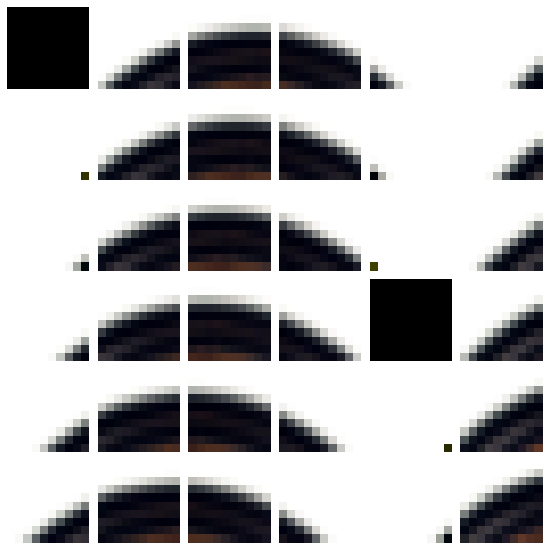

In [4]:
X_, X_valid_, X_test_, X_labels_, T = dataloader(0, P=10, s=2, label_per_patch=False, load_size=66, crop_size=64, normalize=False)

plt.rcParams["figure.figsize"] = (10, 10)
show_filters_color(X_[:36].reshape(36, -1).T)

In [3]:
bs = 50
s = 1 # stride

def preprocessing(x, ins, outs, a, b, c):
    return x, ins, outs, 0, 1

net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net.eval()

log = []

for clazz in range(0, 15):
    
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, 
                                                     MVTEC_PATH=MVTEC_PATH)

    X = concat_features(X_, net, layers=[5,6], fmap_pool=False)
    X_valid = concat_features(X_valid_, net, layers=[5,6], fmap_pool=False)
    X_test = concat_features(X_test_, net, layers=[5,6], fmap_pool=False)

    shapes = (X.shape, X_test.shape, X_valid.shape)
    c = X.shape[1]
    t = X.shape[2] # tile_size
    n = len(X_valid) + len(X_test)
    print(shapes)
        
    hyp = SFA.hyperparameter_search(X, X_valid, X_test, 
                  patch_size=[5, 6, 7, 8, 9],
                  n_components=[ "q90" ], 
                  stride=[s], 
                  shape=(c, t, t), 
                  bs=1500, 
                  epochs=30,
                  remove_components = [0],
                  max_components=7000,
                  min_components=10,
                  norm=[2], 
                  mode="ta", 
                  compute_bpd = False,
                  aucs=["mean", "sum"],
                  preprocess = preprocessing,
                 logging = -10) 

    display(hyp)

    log.append(hyp)
    
    # display(pd.concat(log))

((209, 272, 14, 14), (63, 272, 14, 14), (20, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 1400
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_tiles=81. Setting bs=1458
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=9792 > np.min([max_components=1458,bs=1458]). Setting n_components=1458
  warnings.warn(f"n_components={n_compon

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0          96.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0          88.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0          81.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0          77.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0          78.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.842518  0.0  ...       0.0   0.076800       0.000789  0.110984   
1  0.999987  0.0  ...       0.0   0.072902       0.000831  0.106462   
2  1.121371  0.0  ...       0.0   0.090622       0.001107  0.096326   
3  1.015076  0.0  ...       0.0   0.080710       0.001046  0.091030   
4  0.736498  0.0  ...       0.0   0.065557       0.000852  0.099917   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001156          2.045696  4.161655  0.0  0.901587  0.901587  
1      0.001210          2.211286  4.146488  0.0  0.875397  0.875397  
2      0.001189          1.628593  4.132895  0.0  0.842063  0.842063  
3      0.001182          0.709626  4.115698  0.0  0.838889  0.838889  
4      0.001281          0.256142  4.086913  0.0  0.862698  0.862698  

[5 rows x 38 columns]

((280, 272, 14, 14), (89, 272, 14, 14), (28, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 1000
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_tiles=81. Setting bs=1458
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=9792 > np.min([max_components=1458,bs=1458]). Setting n_components=1458
  warnings.warn(f"n_components={n_compon

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0         509.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         590.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0         663.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         714.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0         758.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.266008  0.0  ...       0.0   0.057266       0.000112   3.028374   
1  0.190681  0.0  ...       0.0   0.041822       0.000070   5.516186   
2  0.153796  0.0  ...       0.0   0.038252       0.000056   9.409933   
3  0.121370  0.0  ...       0.0   0.033356       0.000046  13.802851   
4  0.100372  0.0  ...       0.0   0.032298       0.000043  18.393078   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.005950          0.017603  3.678411  0.0  0.632424  0.632424  
1      0.009349          0.013449  3.706134  0.0  0.640851  0.640851  
2      0.014193          0.011095  3.730553  0.0  0.670546  0.670546  
3      0.019332          0.009650  3.757400  0.0  0.713082  0.713082  
4      0.024265          0.010020  3.773694  0.0  0.760433  0.760433  

[5 rows x 38 columns]

((245, 272, 14, 14), (92, 272, 14, 14), (32, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=502 must be less or equal to the batch number of samples 500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_til

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0         502.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         579.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0         648.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         698.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0         737.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.396173  0.0  ...       0.0   0.148255       0.000298   2.655360   
1  0.298087  0.0  ...       0.0   0.120460       0.000208   4.033331   
2  0.210965  0.0  ...       0.0   0.087602       0.000135   7.257756   
3  0.160689  0.0  ...       0.0   0.074648       0.000108  10.904135   
4  0.117668  0.0  ...       0.0   0.055793       0.000076  16.004269   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.005290          0.019698  3.758650  0.0  0.930707  0.930707  
1      0.006966          0.017007  3.778573  0.0  0.948709  0.948709  
2      0.011200          0.014428  3.798296  0.0  0.959918  0.959918  
3      0.015622          0.012712  3.817509  0.0  0.969090  0.969090  
4      0.021715          0.012490  3.829950  0.0  0.979959  0.979959  

[5 rows x 38 columns]

((267, 272, 14, 14), (141, 272, 14, 14), (26, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 1200
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_tiles=81. Setting bs=1458
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=9792 > np.min([max_components=1458,bs=1458]). Setting n_components=1458
  warnings.warn(f"n_components={n_compon

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0         303.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         324.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0         345.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         359.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0         373.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.542126  0.0  ...       0.0   0.086062       0.000282  0.333243   
1  0.404131  0.0  ...       0.0   0.073842       0.000229  0.388903   
2  0.342833  0.0  ...       0.0   0.052275       0.000151  0.500293   
3  0.271260  0.0  ...       0.0   0.051060       0.000143  0.683967   
4  0.273238  0.0  ...       0.0   0.060617       0.000162  0.923774   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001100          0.108436  4.387719  0.0  0.604201  0.604201  
1      0.001200          0.067898  4.408669  0.0  0.598200  0.598200  
2      0.001450          0.039433  4.414727  0.0  0.596290  0.596290  
3      0.001905          0.024862  4.416094  0.0  0.590289  0.590289  
4      0.002477          0.014661  4.404351  0.0  0.603655  0.603655  

[5 rows x 38 columns]

((230, 272, 14, 14), (84, 272, 14, 14), (33, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=761 must be less or equal to the batch number of samples 500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_til

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0         761.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         829.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0         896.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         944.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0         989.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.156564  0.0  ...       0.0   0.047826       0.000064  21.376915   
1  0.130072  0.0  ...       0.0   0.042736       0.000051  29.158594   
2  0.108394  0.0  ...       0.0   0.044388       0.000049  40.151024   
3  0.088940  0.0  ...       0.0   0.038557       0.000040  47.157497   
4  0.075515  0.0  ...       0.0   0.044971       0.000046  55.924892   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.028091          0.011465  4.195822  0.0  0.932179  0.932179  
1      0.035173          0.009709  4.238812  0.0  0.927850  0.927850  
2      0.044811          0.009146  4.270066  0.0  0.935426  0.935426  
3      0.049955          0.009562  4.292840  0.0  0.941198  0.941198  
4      0.056547          0.011998  4.300191  0.0  0.947330  0.947330  

[5 rows x 38 columns]

((247, 272, 14, 14), (60, 272, 14, 14), (19, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 700
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_tiles=81. Setting bs=1458
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=9792 > np.min([max_components=1458,bs=1458]). Setting n_components=1458
  warnings.warn(f"n_components={n_compone

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0         636.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         710.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0         781.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         832.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0         877.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.298736  0.0  ...       0.0   0.048196       0.000076   7.079000   
1  0.248923  0.0  ...       0.0   0.046135       0.000064  11.696610   
2  0.205657  0.0  ...       0.0   0.048034       0.000061  18.906231   
3  0.166976  0.0  ...       0.0   0.045792       0.000054  26.627670   
4  0.148649  0.0  ...       0.0   0.049431       0.000057  36.249371   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.011131          0.033274  3.988140  0.0  0.883333  0.883333  
1      0.016474          0.027124  4.024465  0.0  0.865789  0.865789  
2      0.024208          0.023361  4.052320  0.0  0.860526  0.860526  
3      0.032004          0.022203  4.074985  0.0  0.853509  0.853509  
4      0.041333          0.023810  4.084506  0.0  0.842982  0.842982  

[5 rows x 38 columns]

((224, 272, 14, 14), (92, 272, 14, 14), (58, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 1400
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_tiles=81. Setting bs=1458
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=9792 > np.min([max_components=1458,bs=1458]). Setting n_components=1458
  warnings.warn(f"n_components={n_compon

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0         596.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         609.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0         618.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         614.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0         614.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.108744  0.0  ...       0.0   0.012580       0.000021  3.842009   
1  0.093296  0.0  ...       0.0   0.015062       0.000025  3.913919   
2  0.097466  0.0  ...       0.0   0.017405       0.000028  4.613748   
3  0.107770  0.0  ...       0.0   0.020911       0.000035  4.726478   
4  0.103289  0.0  ...       0.0   0.025424       0.000042  5.601702   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.006446          0.014164  4.649263  0.0  0.830585  0.830585  
1      0.006427          0.010861  4.671610  0.0  0.836582  0.836582  
2      0.007466          0.009072  4.679978  0.0  0.854573  0.854573  
3      0.007698          0.007660  4.675489  0.0  0.862631  0.862631  
4      0.009123          0.007944  4.652642  0.0  0.879123  0.879123  

[5 rows x 38 columns]

((264, 272, 14, 14), (57, 272, 14, 14), (21, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 900
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_tiles=81. Setting bs=1458
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=9792 > np.min([max_components=1458,bs=1458]). Setting n_components=1458
  warnings.warn(f"n_components={n_compone

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0         233.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         242.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0         254.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         266.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0         280.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.180045  0.0  ...       0.0   0.112800       0.000487  0.794963   
1  0.953890  0.0  ...       0.0   0.083475       0.000346  0.738156   
2  0.761291  0.0  ...       0.0   0.067207       0.000262  0.712897   
3  0.783378  0.0  ...       0.0   0.081490       0.000303  0.842403   
4  0.791665  0.0  ...       0.0   0.110387       0.000397  0.932130   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.003412          0.348992  3.895476  0.0  0.414369  0.414369  
1      0.003050          0.287825  3.895648  0.0  0.436926  0.436926  
2      0.002807          0.220674  3.895292  0.0  0.435255  0.435255  
3      0.003167          0.165796  3.898260  0.0  0.440267  0.440267  
4      0.003329          0.117127  3.897801  0.0  0.446951  0.446951  

[5 rows x 38 columns]

((60, 272, 14, 14), (30, 272, 14, 14), (12, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_tiles=81. Setting bs=1458
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=9792 > np.min([max_components=1458,bs=1458]). Setting n_components=1458
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1458 must be less or equal to the batch number of samples 486
  warnings.warn(f"Skipp

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0         141.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         147.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0         147.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         141.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0         131.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.793411  0.0  ...       0.0   0.087422       0.000624  0.560309   
1  0.685026  0.0  ...       0.0   0.063376       0.000450  0.575368   
2  0.314530  0.0  ...       0.0   0.039906       0.000270  0.561953   
3  0.248083  0.0  ...       0.0   0.053762       0.000379  0.569999   
4  0.320670  0.0  ...       0.0   0.065004       0.000485  0.552909   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.003974          0.427976  4.232404  0.0  0.513889  0.513889  
1      0.003914          0.282849  4.222379  0.0  0.502778  0.502778  
2      0.003823          0.167826  4.205337  0.0  0.527778  0.527778  
3      0.004043          0.108208  4.175810  0.0  0.577778  0.577778  
4      0.004221          0.055061  4.129186  0.0  0.569444  0.569444  

[5 rows x 38 columns]

((240, 272, 14, 14), (119, 272, 14, 14), (32, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_tiles=81. Setting bs=1458
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=9792 > np.min([max_components=1458,bs=1458]). Setting n_components=1458
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1458 must be less or equal to the batch number of samples 486
  warnings.warn(f"Skipp

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0          70.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0          63.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0          54.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0          51.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0          60.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  3.505629  0.0  ...       0.0   0.185695       0.002660  0.080600   
1  3.413531  0.0  ...       0.0   0.195852       0.003120  0.069809   
2  2.544667  0.0  ...       0.0   0.154445       0.002884  0.063437   
3  2.311000  0.0  ...       0.0   0.140514       0.002768  0.056661   
4  1.360308  0.0  ...       0.0   0.096790       0.001639  0.075889   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001151          0.232994  3.982153  0.0  0.700368  0.700368  
1      0.001108          0.177463  3.992871  0.0  0.702994  0.702994  
2      0.001175          0.161025  4.003522  0.0  0.707721  0.707721  
3      0.001111          0.134846  3.997983  0.0  0.682773  0.682773  
4      0.001265          0.072733  3.967336  0.0  0.679884  0.679884  

[5 rows x 38 columns]

((219, 272, 14, 14), (109, 272, 14, 14), (23, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 900
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_tiles=81. Setting bs=1458
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=9792 > np.min([max_components=1458,bs=1458]). Setting n_components=1458
  warnings.warn(f"n_components={n_compone

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0          81.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0          74.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0          64.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0          53.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0          42.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  2.614082  0.0  ...       0.0   0.238151       0.002927  0.097189   
1  1.936261  0.0  ...       0.0   0.195476       0.002627  0.104275   
2  1.302180  0.0  ...       0.0   0.152944       0.002369  0.085691   
3  1.610200  0.0  ...       0.0   0.136191       0.002587  0.089735   
4  1.812613  0.0  ...       0.0   0.143679       0.003376  0.074435   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001200          1.100448  4.118232  0.0  0.437176  0.437176  
1      0.001409          1.432225  4.120389  0.0  0.418428  0.418428  
2      0.001339          1.664673  4.119023  0.0  0.410052  0.410052  
3      0.001693          1.497091  4.107885  0.0  0.402473  0.402473  
4      0.001772          1.145775  4.083076  0.0  0.409254  0.409254  

[5 rows x 38 columns]

((391, 272, 14, 14), (70, 272, 14, 14), (40, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 100
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=559 must be less or equal to the batch number of samples 100
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_til

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0         559.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         591.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0         620.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         632.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0         634.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.509876  0.0  ...       0.0   0.090929       0.000162  1.356069   
1  0.432888  0.0  ...       0.0   0.077145       0.000131  1.874865   
2  0.365863  0.0  ...       0.0   0.061867       0.000100  2.552510   
3  0.319869  0.0  ...       0.0   0.053598       0.000085  3.248038   
4  0.266762  0.0  ...       0.0   0.040331       0.000064  4.567477   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.002426          0.015540  4.493031  0.0  0.838214  0.838214  
1      0.003172          0.012686  4.515770  0.0  0.859286  0.859286  
2      0.004117          0.010427  4.529679  0.0  0.871429  0.871429  
3      0.005139          0.010165  4.534484  0.0  0.878214  0.878214  
4      0.007204          0.010788  4.528437  0.0  0.862857  0.862857  

[5 rows x 38 columns]

((220, 272, 14, 14), (93, 272, 14, 14), (22, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 1000
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_tiles=81. Setting bs=1458
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=9792 > np.min([max_components=1458,bs=1458]). Setting n_components=1458
  warnings.warn(f"n_components={n_compon

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0         402.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         373.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0         348.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         329.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0         324.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.421500  0.0  ...       0.0   0.046544       0.000117  0.657037   
1  0.391216  0.0  ...       0.0   0.041504       0.000111  0.539370   
2  0.309102  0.0  ...       0.0   0.031082       0.000090  0.547255   
3  0.173457  0.0  ...       0.0   0.027829       0.000084  0.497353   
4  0.139067  0.0  ...       0.0   0.032820       0.000102  0.568314   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001634          0.020797  4.517771  0.0  0.750244  0.750244  
1      0.001446          0.015659  4.508785  0.0  0.726784  0.726784  
2      0.001573          0.012254  4.495548  0.0  0.706745  0.706745  
3      0.001512          0.009751  4.480975  0.0  0.697458  0.697458  
4      0.001754          0.009721  4.460841  0.0  0.677419  0.677419  

[5 rows x 38 columns]

((320, 272, 14, 14), (119, 272, 14, 14), (41, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 500
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_tiles=81. Setting bs=1458
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=9792 > np.min([max_components=1458,bs=1458]). Setting n_components=1458
  warnings.warn(f"n_components={n_compone

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0         338.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         355.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0         365.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         357.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0         335.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.352090  0.0  ...       0.0   0.212424       0.000630  0.428727   
1  0.993785  0.0  ...       0.0   0.146358       0.000411  0.514540   
2  0.725474  0.0  ...       0.0   0.102215       0.000278  0.620441   
3  0.570431  0.0  ...       0.0   0.072834       0.000205  0.867147   
4  0.474827  0.0  ...       0.0   0.053082       0.000159  1.119188   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001268          0.046121  4.328225  0.0  0.555852  0.555852  
1      0.001449          0.023715  4.338805  0.0  0.503382  0.503382  
2      0.001700          0.012875  4.339812  0.0  0.463825  0.463825  
3      0.002429          0.011043  4.326483  0.0  0.457061  0.457061  
4      0.003341          0.011932  4.297296  0.0  0.456856  0.456856  

[5 rows x 38 columns]

((213, 272, 14, 14), (40, 272, 14, 14), (60, 272, 14, 14))


/home/ios/git_repos/fasterica/hugeica/SFA.py:79: UserWarning: n_components=6800 > np.min([max_components=1500,bs=1500]). Setting n_components=1500
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1500 must be less or equal to the batch number of samples 300
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=331 must be less or equal to the batch number of samples 300
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/ios/git_repos/fasterica/hugeica/SFA.py:130: UserWarning: bs=1500 is not a multiple of n_til

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         5.0  1.0         331.0  2.0                0.0    0.0    0.0  0.0   
1         6.0  1.0         320.0  2.0                0.0    0.0    0.0  0.0   
2         7.0  1.0         311.0  2.0                0.0    0.0    0.0  0.0   
3         8.0  1.0         292.0  2.0                0.0    0.0    0.0  0.0   
4         9.0  1.0         275.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.211508  0.0  ...       0.0   0.020244       0.000062  0.553720   
1  0.194578  0.0  ...       0.0   0.018041       0.000058  0.484231   
2  0.231932  0.0  ...       0.0   0.028731       0.000092  0.513454   
3  0.298601  0.0  ...       0.0   0.039020       0.000134  0.484271   
4  0.342255  0.0  ...       0.0   0.033620       0.000123  0.481921   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001673          0.070107  4.463860  0.0  0.760833  0.760833  
1      0.001513          0.055586  4.465445  0.0  0.763333  0.763333  
2      0.001651          0.043237  4.456950  0.0  0.766250  0.766250  
3      0.001658          0.033159  4.442832  0.0  0.767500  0.767500  
4      0.001752          0.024556  4.414617  0.0  0.760833  0.760833  

[5 rows x 38 columns]

IndexError: list index out of range

In [4]:
for i,l in enumerate(log): # dual layer
    print(i, l.sort_values("negH_sum_cluster", ascending=False).head(1)["patch_size"].item())

0 6.0
1 5.0
2 5.0
3 5.0
4 9.0
5 5.0
6 5.0
7 5.0
8 5.0
9 5.0
10 7.0
11 5.0
12 5.0
13 5.0
14 5.0


In [16]:
# torch.save(log, "find_patch_size.pckl")

In [15]:
for i,l in enumerate(log): # signle layer
    print(i, l.sort_values("negH_sum_cluster", ascending=False).head(1)["patch_size"].item())

0 6.0
1 4.0
2 4.0
3 4.0
4 11.0
5 4.0
6 4.0
7 4.0
8 4.0
9 4.0
10 8.0
11 4.0
12 4.0
13 4.0
14 4.0


In [48]:
log = torch.load("find_patch_size.pckl")
for i,l in enumerate(log):
    print(i, l.sort_values("negH_sum", ascending=False).head(1)["patch_size"].item())
log[1]

0 11.0
1 11.0
2 11.0
3 11.0
4 11.0
5 11.0
6 11.0
7 11.0
8 6.0
9 11.0
10 5.0
11 11.0
12 11.0
13 11.0
14 11.0


patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0         4.0  1.0         298.0  2.0                0.0    0.0    0.0  0.0   
1         5.0  1.0         395.0  2.0                0.0    0.0    0.0  0.0   
2         6.0  1.0         469.0  2.0                0.0    0.0    0.0  0.0   
3         7.0  1.0         539.0  2.0                0.0    0.0    0.0  0.0   
4         8.0  1.0         594.0  2.0                0.0    0.0    0.0  0.0   
5        10.0  1.0         690.0  2.0                0.0    0.0    0.0  0.0   
6        11.0  1.0         728.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.661993  0.0  ...       0.0   0.094406       0.000318   0.608312   
1  0.466420  0.0  ...       0.0   0.085432       0.000216   1.270585   
2  0.337088  0.0  ...       0.0   0.070920       0.000150   2.586707   
3  0.238385  0.0  ...       0.0   0.056912       0.000105   4.279830   
4  0.184364  0.0  ...       0.0   0.050885       0.000084   6.342362   
5  0.104143  0.0  ...       0.0   0.039706       0.000057  14.337149   
6  0.083295  0.0  ...       0.0   0.050776       0.000068  17.933414   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.002041          0.026860  3.694694  0.0  0.770867  0.770867  
1      0.003217          0.018991  3.680059  0.0  0.807785  0.807785  
2      0.005515          0.014371  3.688791  0.0  0.845907  0.845907  
3      0.007940          0.010886  3.701840  0.0  0.880819  0.880819  
4      0.010677          0.008974  3.717216  0.0  0.894864  0.894864  
5      0.020778          0.009786  3.723080  0.0  0.939406  0.939406  
6      0.024634          0.015060  3.691327  0.0  0.960674  0.960674  

[7 rows x 38 columns]

In [3]:
s = 4 # stride

log = []

for clazz in range(15):
    
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=64, s=64, label_per_patch=False, load_size=66, crop_size=64, normalize=False)

    hyp = SFA.hyperparameter_search(X_, X_valid_, X_test_, 
                  patch_size=[(i*16)//4 for i in range(4, 12)], # pool-4 1 pixel is 16 pixels in input, 64 = 224/4
                  n_components=[ "q90" ], 
                  stride=[s], 
                  shape=(3, 64, 64), 
                  bs=4000, 
                  epochs=30,
                  remove_components = [0],
                  max_components=7000,
                  min_components=1,
                  norm=[2], 
                  mode="ta", 
                  compute_bpd = False,
                  aucs=["mean", "sum"],
                 logging = -10) 
    display(hyp)
    p_size = int( hyp.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item() )
    df = pd.DataFrame(np.asarray([clazz, p_size])[:, None].T, columns=["class", "p_size"]) 
    log.append(df)
    
    display(pd.concat(log))

/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=768 must be less or equal to the batch number of samples 338
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1728 must be less or equal to the batch number of samples 1331
  warnings.warn(f"Skipping backward(). n_components={n_co

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0          89.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0         118.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0         138.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0         144.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0         141.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0         133.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0         120.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0         101.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.696007  0.0  ...       0.0   0.111053       0.001240  0.107495   
1  1.385031  0.0  ...       0.0   0.104752       0.000885  0.136065   
2  1.585467  0.0  ...       0.0   0.128049       0.000924  0.148037   
3  2.143991  0.0  ...       0.0   0.221263       0.001537  0.165574   
4  2.756296  0.0  ...       0.0   0.299371       0.002117  0.164365   
5  2.678868  0.0  ...       0.0   0.290858       0.002175  0.164806   
6  1.641586  0.0  ...       0.0   0.150407       0.001247  0.134436   
7  1.557088  0.0  ...       0.0   0.132437       0.001308  0.112945   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001208          0.492425  1.960870  0.0  0.626984  0.626984  
1      0.001153          0.548611  1.901893  0.0  0.623810  0.623810  
2      0.001073          0.922663  1.838303  0.0  0.613492  0.613492  
3      0.001150          0.966959  1.773492  0.0  0.609524  0.609524  
4      0.001166          0.992511  1.723439  0.0  0.592857  0.592857  
5      0.001239          0.800372  1.688774  0.0  0.626190  0.626190  
6      0.001120          0.470188  1.673185  0.0  0.638095  0.638095  
7      0.001118          0.298590  1.654985  0.0  0.646825  0.646825  

[8 rows x 38 columns]

class  p_size
0      0      28

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=768 must be less or equal to the batch number of samples 676
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0         202.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0         312.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0         443.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0         592.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0         753.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0         918.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0        1067.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0        1178.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.370533  0.0  ...       0.0   0.021698       0.000108   0.244734   
1  0.293417  0.0  ...       0.0   0.027520       0.000086   0.497775   
2  0.261631  0.0  ...       0.0   0.029709       0.000067   1.003950   
3  0.215975  0.0  ...       0.0   0.030860       0.000052   2.280710   
4  0.185769  0.0  ...       0.0   0.026860       0.000035   5.300859   
5  0.186497  0.0  ...       0.0   0.036574       0.000040  11.607098   
6  0.171108  0.0  ...       0.0   0.038219       0.000036  22.226164   
7  0.159492  0.0  ...       0.0   0.043369       0.000037  34.898937   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001212          0.063554  1.704054  0.0  0.505217  0.505217  
1      0.001595          0.043802  1.695736  0.0  0.510032  0.510032  
2      0.002266          0.029777  1.691652  0.0  0.513644  0.513644  
3      0.003853          0.020614  1.687458  0.0  0.516051  0.516051  
4      0.007040          0.014533  1.679733  0.0  0.498796  0.498796  
5      0.012644          0.011244  1.671075  0.0  0.480337  0.480337  
6      0.020831          0.009336  1.658870  0.0  0.479936  0.479936  
7      0.029626          0.009002  1.646340  0.0  0.491974  0.491974  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1200 must be less or equal to the batch number of samples 288
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthia

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0           1.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0           1.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0           1.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0           2.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0           4.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0          25.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0          77.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0         133.0  2.0                0.0    0.0    0.0  0.0   

        kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  11.299505  0.0  ...       0.0   0.026733       0.026574  0.001379   
1  10.024974  0.0  ...       0.0   0.024058       0.023820  0.000788   
2   8.782697  0.0  ...       0.0   0.020727       0.020830  0.001166   
3  26.854950  0.0  ...       0.0   0.047284       0.023846  0.008572   
4  21.746216  0.0  ...       0.0   0.080250       0.020086  0.027345   
5   8.076782  0.0  ...       0.0   0.149043       0.005964  0.062780   
6   2.807067  0.0  ...       0.0   0.129384       0.001673  0.131920   
7   1.791390  0.0  ...       0.0   0.128734       0.000962  0.223070   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001379          0.182744 -0.626304  0.0  0.291440  0.291440  
1      0.000788          0.152700 -0.605485  0.0  0.291101  0.291101  
2      0.001166          0.131630 -0.584215  0.0  0.291101  0.291101  
3      0.004286          0.276761 -0.624688  0.0  0.360054  0.360054  
4      0.006836          0.226648 -0.655524  0.0  0.456522  0.456522  
5      0.002511          0.103202 -0.679788  0.0  0.384511  0.384511  
6      0.001713          0.044099 -0.689237  0.0  0.442595  0.442595  
7      0.001677          0.020786 -0.710810  0.0  0.506114  0.506114  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44
0      2      44

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1728 must be less or equal to the batch number of samples 363
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthia

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0          39.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0          63.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0          94.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0         128.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0         164.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0         203.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0         245.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0         289.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  2.573416  0.0  ...       0.0   0.080737       0.002070  0.034888   
1  1.743251  0.0  ...       0.0   0.069158       0.001104  0.055306   
2  1.282505  0.0  ...       0.0   0.062547       0.000669  0.087507   
3  1.223366  0.0  ...       0.0   0.078670       0.000612  0.113353   
4  0.966317  0.0  ...       0.0   0.081391       0.000496  0.153234   
5  0.749929  0.0  ...       0.0   0.072367       0.000362  0.214411   
6  0.622872  0.0  ...       0.0   0.068222       0.000280  0.258164   
7  0.454085  0.0  ...       0.0   0.044523       0.000154  0.365781   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.000895          0.424334  1.512320  0.0  0.352701  0.352701  
1      0.000878          0.219225  1.502611  0.0  0.379978  0.379978  
2      0.000931          0.136130  1.486668  0.0  0.419804  0.419804  
3      0.000886          0.083049  1.473555  0.0  0.423622  0.423622  
4      0.000934          0.060171  1.451164  0.0  0.430442  0.430442  
5      0.001056          0.038818  1.420536  0.0  0.492635  0.492635  
6      0.001054          0.025936  1.401180  0.0  0.582379  0.582379  
7      0.001266          0.018940  1.356566  0.0  0.616476  0.616476  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44
0      2      44
0      3      44

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=81. Setting bs=3969
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). 

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0         205.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0         317.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0         452.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0         606.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0         776.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0         952.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0        1119.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0        1256.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg   negH_sum  \
0  0.562235  0.0  ...       0.0   0.036145       0.000175   0.274646   
1  0.437230  0.0  ...       0.0   0.033559       0.000107   0.542927   
2  0.396350  0.0  ...       0.0   0.039540       0.000088   1.091892   
3  0.357006  0.0  ...       0.0   0.041367       0.000070   2.478016   
4  0.327976  0.0  ...       0.0   0.044976       0.000058   6.187351   
5  0.311090  0.0  ...       0.0   0.051808       0.000055  13.466306   
6  0.300959  0.0  ...       0.0   0.062950       0.000057  24.400475   
7  0.289444  0.0  ...       0.0   0.081503       0.000065  31.104544   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001340          0.117131  1.547158  0.0  0.613997  0.613997  
1      0.001713          0.067289  1.537172  0.0  0.623016  0.623016  
2      0.002416          0.048157  1.531493  0.0  0.636364  0.636364  
3      0.004089          0.031195  1.526826  0.0  0.646825  0.646825  
4      0.007973          0.020912  1.519269  0.0  0.686508  0.686508  
5      0.014145          0.014474  1.513145  0.0  0.733405  0.733405  
6      0.021806          0.010759  1.501413  0.0  0.770202  0.770202  
7      0.024765          0.009766  1.479720  0.0  0.808081  0.808081  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44
0      2      44
0      3      44
0      4      44

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1200 must be less or equal to the batch number of samples 576
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthia

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0          43.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0          66.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0          94.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0         128.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0         166.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0         206.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0         248.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0         286.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  8.643881  0.0  ...       0.0   0.285022       0.006607  0.206542   
1  7.808658  0.0  ...       0.0   0.387440       0.005883  0.264729   
2  6.729223  0.0  ...       0.0   0.467644       0.004967  0.404377   
3  5.623000  0.0  ...       0.0   0.510564       0.003990  0.546021   
4  5.002866  0.0  ...       0.0   0.560222       0.003388  0.808008   
5  4.472006  0.0  ...       0.0   0.603064       0.002922  1.123850   
6  3.926519  0.0  ...       0.0   0.621222       0.002509  1.789301   
7  3.557671  0.0  ...       0.0   0.646804       0.002260  2.763501   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.004803          1.061373 -1.275952  0.0  0.883333  0.883333  
1      0.004011          0.840980 -1.300751  0.0  0.846491  0.846491  
2      0.004302          0.621084 -1.315410  0.0  0.825439  0.825439  
3      0.004266          0.452891 -1.331194  0.0  0.829825  0.829825  
4      0.004868          0.333081 -1.341244  0.0  0.836842  0.836842  
5      0.005456          0.226206 -1.344769  0.0  0.850877  0.850877  
6      0.007215          0.160975 -1.339586  0.0  0.861404  0.861404  
7      0.009663          0.120341 -1.349126  0.0  0.861404  0.861404  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44
0      2      44
0      3      44
0      4      44
0      5      44

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1200 must be less or equal to the batch number of samples 1152
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthi

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0          27.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0          39.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0          52.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0          66.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0          79.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0          90.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0          99.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0         105.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.969544  0.0  ...       0.0   0.013697       0.000513  0.028121   
1  0.571886  0.0  ...       0.0   0.008201       0.000216  0.042631   
2  0.413858  0.0  ...       0.0   0.006762       0.000130  0.055730   
3  0.399042  0.0  ...       0.0   0.008804       0.000132  0.067773   
4  0.242357  0.0  ...       0.0   0.006495       0.000080  0.083962   
5  0.142491  0.0  ...       0.0   0.006153       0.000071  0.094477   
6  0.128576  0.0  ...       0.0   0.012411       0.000127  0.102335   
7  0.065094  0.0  ...       0.0   0.013046       0.000125  0.114199   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001042          0.131515  1.496155  0.0  0.638493  0.638493  
1      0.001093          0.078711  1.498821  0.0  0.666604  0.666604  
2      0.001072          0.055704  1.503650  0.0  0.674288  0.674288  
3      0.001027          0.041337  1.494819  0.0  0.694340  0.694340  
4      0.001063          0.029877  1.478544  0.0  0.693403  0.693403  
5      0.001050          0.019447  1.457241  0.0  0.710832  0.710832  
6      0.001034          0.010031  1.434920  0.0  0.727324  0.727324  
7      0.001088          0.005636  1.389794  0.0  0.753561  0.753561  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44
0      2      44
0      3      44
0      4      44
0      5      44
0      6      44

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=81. Setting bs=3969
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). 

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0         450.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0         697.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0         992.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0        1330.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0        1699.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0        2080.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0        2439.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0        2704.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg    negH_sum  \
0  0.023436  0.0  ...       0.0   0.002944       0.000007    1.036221   
1  0.022896  0.0  ...       0.0   0.005091       0.000007    3.929610   
2  0.021806  0.0  ...       0.0   0.008121       0.000008   12.763170   
3  0.017930  0.0  ...       0.0   0.012217       0.000009   49.006180   
4  0.010575  0.0  ...       0.0   0.018399       0.000011  115.054710   
5  0.007687  0.0  ...       0.0   0.028329       0.000014  138.979477   
6  0.005846  0.0  ...       0.0   0.043440       0.000018  161.991730   
7  0.004710  0.0  ...       0.0   0.065353       0.000024  191.026489   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.002303          0.019383  2.683544  0.0  0.539683  0.539683  
1      0.005638          0.013913  2.678841  0.0  0.550543  0.550543  
2      0.012866          0.011737  2.674529  0.0  0.554720  0.554720  
3      0.036847          0.008206  2.666200  0.0  0.559733  0.559733  
4      0.067719          0.005588  2.651945  0.0  0.562239  0.562239  
5      0.066817          0.004642  2.629151  0.0  0.543860  0.543860  
6      0.066417          0.005301  2.592666  0.0  0.544695  0.544695  
7      0.070646          0.007740  2.534745  0.0  0.530493  0.530493  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44
0      2      44
0      3      44
0      4      44
0      5      44
0      6      44
0      7      44

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1200 must be less or equal to the batch number of samples 864
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthia

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0           6.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0           7.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0           9.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0           9.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0           9.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0           9.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0           9.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0           9.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.582324  0.0  ...       0.0   0.005605       0.000951  0.032067   
1 -0.022506  0.0  ...       0.0   0.002201       0.000300  0.031748   
2  0.024348  0.0  ...       0.0   0.004132       0.000488  0.044305   
3  2.300578  0.0  ...       0.0   0.020792       0.002392  0.037913   
4  4.405238  0.0  ...       0.0   0.042233       0.004827  0.042106   
5  5.872657  0.0  ...       0.0   0.063433       0.007192  0.039931   
6  5.791673  0.0  ...       0.0   0.076929       0.008736  0.043734   
7  5.237894  0.0  ...       0.0   0.078947       0.008989  0.039411   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.005344          0.256364  1.883489  0.0  0.536111  0.536111  
1      0.004535          0.200800  1.950362  0.0  0.533333  0.533333  
2      0.004923          0.144078  1.970329  0.0  0.552778  0.552778  
3      0.004213          0.111455  2.016211  0.0  0.561111  0.561111  
4      0.004678          0.076103  2.034551  0.0  0.575000  0.575000  
5      0.004437          0.060716  2.031227  0.0  0.577778  0.577778  
6      0.004859          0.045898  2.000338  0.0  0.575000  0.575000  
7      0.004379          0.044712  1.935462  0.0  0.580556  0.580556  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44
0      2      44
0      3      44
0      4      44
0      5      44
0      6      44
0      7      44
0      8      24

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1728 must be less or equal to the batch number of samples 1089
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthi

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0         448.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0         694.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0         987.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0        1321.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0        1684.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0        2055.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0        2397.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0        2633.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg    negH_sum  \
0  0.050714  0.0  ...       0.0   0.003106       0.000007    0.890909   
1  0.040432  0.0  ...       0.0   0.005270       0.000008    3.278664   
2  0.032346  0.0  ...       0.0   0.008528       0.000009   11.968885   
3  0.027171  0.0  ...       0.0   0.013115       0.000010   41.291977   
4  0.020112  0.0  ...       0.0   0.020013       0.000012  108.268700   
5  0.015935  0.0  ...       0.0   0.030727       0.000015  121.636856   
6  0.012194  0.0  ...       0.0   0.046759       0.000019  148.300217   
7  0.009724  0.0  ...       0.0   0.070002       0.000027  175.287338   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001989          0.019631  2.740596  0.0  0.474527  0.474527  
1      0.004724          0.014176  2.739480  0.0  0.473740  0.473740  
2      0.012127          0.011588  2.735520  0.0  0.504464  0.504464  
3      0.031258          0.008024  2.730060  0.0  0.503676  0.503676  
4      0.064293          0.005382  2.715656  0.0  0.486607  0.486607  
5      0.059191          0.004279  2.691065  0.0  0.492647  0.492647  
6      0.061869          0.004952  2.651321  0.0  0.482931  0.482931  
7      0.066573          0.008046  2.579676  0.0  0.497111  0.497111  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44
0      2      44
0      3      44
0      4      44
0      5      44
0      6      44
0      7      44
0      8      24
0      9      44

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1200 must be less or equal to the batch number of samples 432
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthia

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0           5.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0           7.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0           9.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0          11.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0          12.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0          13.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0          12.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0          10.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  7.992166  0.0  ...       0.0   0.063265       0.012737  0.023832   
1  5.093682  0.0  ...       0.0   0.054026       0.007689  0.026619   
2  3.112542  0.0  ...       0.0   0.037578       0.004192  0.039158   
3  1.985466  0.0  ...       0.0   0.027602       0.002532  0.030418   
4  1.017019  0.0  ...       0.0   0.016011       0.001360  0.034094   
5  1.307332  0.0  ...       0.0   0.031120       0.002425  0.032380   
6  1.379576  0.0  ...       0.0   0.032407       0.002708  0.034885   
7  2.318365  0.0  ...       0.0   0.048295       0.004826  0.027909   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.004766          3.313884  1.714567  0.0  0.360989  0.360989  
1      0.003803          2.492342  1.724750  0.0  0.378141  0.378141  
2      0.004351          1.417603  1.766842  0.0  0.406861  0.406861  
3      0.002765          0.942889  1.798251  0.0  0.430794  0.430794  
4      0.002841          0.593844  1.786977  0.0  0.463901  0.463901  
5      0.002491          0.358305  1.694058  0.0  0.440367  0.440367  
6      0.002907          0.452633  1.660618  0.0  0.462306  0.462306  
7      0.002791          0.736956  1.561954  0.0  0.477862  0.477862  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44
0      2      44
0      3      44
0      4      44
0      5      44
0      6      44
0      7      44
0      8      24
0      9      44
0     10      24

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=81. Setting bs=3969
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of 

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0           3.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0           5.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0           7.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0           8.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0          10.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0          12.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0          14.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0          18.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  2.596283  0.0  ...       0.0   0.007146       0.002322  0.008004   
1  3.302159  0.0  ...       0.0   0.018671       0.003698  0.004923   
2  2.820103  0.0  ...       0.0   0.025306       0.003619  0.008165   
3  2.340147  0.0  ...       0.0   0.031155       0.003871  0.005221   
4  1.616278  0.0  ...       0.0   0.026462       0.002656  0.006825   
5  1.333034  0.0  ...       0.0   0.025765       0.002172  0.009716   
6  1.055278  0.0  ...       0.0   0.013535       0.000957  0.015157   
7  1.191213  0.0  ...       0.0   0.015572       0.000849  0.030109   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.002668          0.306650  1.714952  0.0  0.497143  0.497143  
1      0.000985          0.198113  1.629901  0.0  0.527500  0.527500  
2      0.001166          0.192377  1.582450  0.0  0.540357  0.540357  
3      0.000653          0.197883  1.598013  0.0  0.522500  0.522500  
4      0.000683          0.127796  1.572398  0.0  0.514643  0.514643  
5      0.000810          0.078860  1.530804  0.0  0.508571  0.508571  
6      0.001083          0.085079  1.517864  0.0  0.549643  0.549643  
7      0.001673          0.051463  1.446530  0.0  0.551786  0.551786  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44
0      2      44
0      3      44
0      4      44
0      5      44
0      6      44
0      7      44
0      8      24
0      9      44
0     10      24
0     11      44

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=1200 must be less or equal to the batch number of samples 576
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthia

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0          45.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0          68.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0          95.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0         120.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0         141.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0         160.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0         180.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0         199.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  1.480308  0.0  ...       0.0   0.026800       0.000587  0.056078   
1  1.172735  0.0  ...       0.0   0.024978       0.000365  0.085540   
2  0.917558  0.0  ...       0.0   0.022714       0.000241  0.131037   
3  0.717394  0.0  ...       0.0   0.020511       0.000171  0.148946   
4  0.728255  0.0  ...       0.0   0.027852       0.000195  0.177473   
5  0.630506  0.0  ...       0.0   0.028013       0.000177  0.204320   
6  0.628155  0.0  ...       0.0   0.033729       0.000187  0.230800   
7  0.553022  0.0  ...       0.0   0.031238       0.000157  0.297277   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001246          0.360569  1.627329  0.0  0.708700  0.708700  
1      0.001258          0.307211  1.608672  0.0  0.713099  0.713099  
2      0.001379          0.202690  1.585535  0.0  0.722385  0.722385  
3      0.001241          0.152423  1.572508  0.0  0.722874  0.722874  
4      0.001259          0.094515  1.560320  0.0  0.726784  0.726784  
5      0.001277          0.056762  1.553187  0.0  0.718475  0.718475  
6      0.001282          0.032144  1.551181  0.0  0.672532  0.672532  
7      0.001494          0.017967  1.536970  0.0  0.651515  0.651515  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44
0      2      44
0      3      44
0      4      44
0      5      44
0      6      44
0      7      44
0      8      24
0      9      44
0     10      24
0     11      44
0     12      44

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=81. Setting bs=3969
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). 

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0         451.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0         700.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0         997.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0        1339.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0        1716.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0        2112.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0        2498.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0        2812.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg    negH_sum  \
0  0.030676  0.0  ...       0.0   0.002789       0.000006    0.807681   
1  0.033386  0.0  ...       0.0   0.005065       0.000007    2.744115   
2  0.028127  0.0  ...       0.0   0.007381       0.000007    9.649130   
3  0.022255  0.0  ...       0.0   0.010542       0.000008   33.714237   
4  0.014537  0.0  ...       0.0   0.015553       0.000009   94.816429   
5  0.009148  0.0  ...       0.0   0.024046       0.000011  133.324951   
6  0.006686  0.0  ...       0.0   0.036352       0.000015  162.188477   
7  0.003571  0.0  ...       0.0   0.056912       0.000020  193.749054   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001791          0.022486  2.683743  0.0  0.531051  0.531051  
1      0.003920          0.018208  2.677761  0.0  0.538225  0.538225  
2      0.009678          0.014992  2.674466  0.0  0.538840  0.538840  
3      0.025179          0.010935  2.669597  0.0  0.528797  0.528797  
4      0.055254          0.007039  2.657182  0.0  0.513425  0.513425  
5      0.063127          0.005422  2.637074  0.0  0.520394  0.520394  
6      0.064927          0.005378  2.612169  0.0  0.523263  0.523263  
7      0.068901          0.007638  2.562685  0.0  0.524083  0.524083  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44
0      2      44
0      3      44
0      4      44
0      5      44
0      6      44
0      7      44
0      8      24
0      9      44
0     10      24
0     11      44
0     12      44
0     13      44

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=169. Setting bs=3887
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=144. Setting bs=3888
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=121. Setting bs=3993
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2352 must be less or equal to the batch number of samples 1300
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthi

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0        16.0  4.0          16.0  2.0                0.0    0.0    0.0  0.0   
1        20.0  4.0          23.0  2.0                0.0    0.0    0.0  0.0   
2        24.0  4.0          31.0  2.0                0.0    0.0    0.0  0.0   
3        28.0  4.0          37.0  2.0                0.0    0.0    0.0  0.0   
4        32.0  4.0          41.0  2.0                0.0    0.0    0.0  0.0   
5        36.0  4.0          45.0  2.0                0.0    0.0    0.0  0.0   
6        40.0  4.0          46.0  2.0                0.0    0.0    0.0  0.0   
7        44.0  4.0          46.0  2.0                0.0    0.0    0.0  0.0   

       kurt  bpd  ...  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0  0.496848  0.0  ...       0.0   0.008399       0.000513  0.027284   
1  0.975510  0.0  ...       0.0   0.016910       0.000739  0.027261   
2  0.748366  0.0  ...       0.0   0.014849       0.000483  0.034550   
3  0.558144  0.0  ...       0.0   0.016800       0.000457  0.055783   
4  0.324188  0.0  ...       0.0   0.012914       0.000310  0.049183   
5  0.276688  0.0  ...       0.0   0.013728       0.000302  0.054888   
6  0.348528  0.0  ...       0.0   0.018205       0.000395  0.058407   
7  0.298456  0.0  ...       0.0   0.020343       0.000431  0.054552   

   negH_sum_avg  negH_sum_cluster     H_max  lhd      mean       sum  
0      0.001705          0.509735  1.159807  0.0  0.475000  0.475000  
1      0.001185          0.223937  1.124025  0.0  0.598750  0.598750  
2      0.001115          0.184058  1.099044  0.0  0.584167  0.584167  
3      0.001508          0.129919  1.078364  0.0  0.555000  0.555000  
4      0.001200          0.078316  1.063992  0.0  0.540833  0.540833  
5      0.001220          0.069559  1.030715  0.0  0.529167  0.529167  
6      0.001270          0.074317  1.010006  0.0  0.509583  0.509583  
7      0.001186          0.049433  0.970423  0.0  0.580000  0.580000  

[8 rows x 38 columns]

class  p_size
0      0      28
0      1      44
0      2      44
0      3      44
0      4      44
0      5      44
0      6      44
0      7      44
0      8      24
0      9      44
0     10      24
0     11      44
0     12      44
0     13      44
0     14      40

In [3]:
patch_sizes_image_64 = np.asarray([34, 56, 56, 60, 56, 56, 60, 56, 58, 56, 44, 60, 56, 58, 46]) * 4 // 16# Pool-4 --> 224 --> 14, 16 --> 1, 32 --> 2
patch_sizes_image_64

s = 2 # stride

log = []

for clazz in range(0, 15):
    
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=64, s=64, label_per_patch=False, load_size=66, crop_size=64, normalize=False)

    hyp = SFA.hyperparameter_search(X_, X_valid_, X_test_, 
                  patch_size=range(2, 64, 2),
                  n_components=[ "q90" ], 
                  stride=[s], 
                  shape=(3, 64, 64), 
                  bs=4000, 
                  epochs=30,
                  remove_components = [0],
                  max_components=7000,
                  min_components=10,
                  norm=[2], 
                  mode="ta", 
                  compute_bpd = False,
                  aucs=["mean", "sum"],
                 logging = -10) 
    display(hyp)
    p_size = int( hyp.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item() )
    df = pd.DataFrame(np.asarray([clazz, p_size])[:, None].T, columns=["class", "p_size"]) 
    log.append(df)
    
    display(pd.concat(log))

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0          2.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
1          4.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
2          6.0  2.0          17.0  2.0                0.0    0.0    0.0  0.0   
3          8.0  2.0          29.0  2.0                0.0    0.0    0.0  0.0   
4         10.0  2.0          43.0  2.0                0.0    0.0    0.0  0.0   
5         12.0  2.0          61.0  2.0                0.0    0.0    0.0  0.0   
6         14.0  2.0          81.0  2.0                0.0    0.0    0.0  0.0   
7         16.0  2.0         103.0  2.0                0.0    0.0    0.0  0.0   
8         18.0  2.0         127.0  2.0                0.0    0.0    0.0  0.0   
9         20.0  2.0         153.0  2.0                0.0    0.0    0.0  0.0   
10        22.0  2.0         178.0  2.0                0.0    0.0    0.0  0.0   
11        24.0  2.0         200.0  2.0                0.0    0.0    0.0  0.0   
12        26.0  2.0         217.0  2.0                0.0    0.0    0.0  0.0   
13        28.0  2.0         229.0  2.0                0.0    0.0    0.0  0.0   
14        30.0  2.0         236.0  2.0                0.0    0.0    0.0  0.0   
15        32.0  2.0         240.0  2.0                0.0    0.0    0.0  0.0   
16        34.0  2.0         239.0  2.0                0.0    0.0    0.0  0.0   
17        36.0  2.0         236.0  2.0                0.0    0.0    0.0  0.0   
18        38.0  2.0         229.0  2.0                0.0    0.0    0.0  0.0   
19        40.0  2.0         220.0  2.0                0.0    0.0    0.0  0.0   
20        42.0  2.0         207.0  2.0                0.0    0.0    0.0  0.0   
21        44.0  2.0         191.0  2.0                0.0    0.0    0.0  0.0   
22        46.0  2.0         172.0  2.0                0.0    0.0    0.0  0.0   
23        48.0  2.0         153.0  2.0                0.0    0.0    0.0  0.0   
24        50.0  2.0         134.0  2.0                0.0    0.0    0.0  0.0   
25        52.0  2.0         115.0  2.0                0.0    0.0    0.0  0.0   
26        54.0  2.0          96.0  2.0                0.0    0.0    0.0  0.0   
27        56.0  2.0          76.0  2.0                0.0    0.0    0.0  0.0   
28        58.0  2.0          58.0  2.0                0.0    0.0    0.0  0.0   
29        60.0  2.0          43.0  2.0                0.0    0.0    0.0  0.0   
30        62.0  2.0          34.0  2.0                0.0    0.0    0.0  0.0   

         kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  \
0   11.416851  0.0  ...      0.0       0.0   0.134086       0.013393   
1   10.382432  0.0  ...      0.0       0.0   0.144705       0.014485   
2    8.143945  0.0  ...      0.0       0.0   0.196158       0.011529   
3    6.590958  0.0  ...      0.0       0.0   0.257520       0.008898   
4    4.389283  0.0  ...      0.0       0.0   0.233275       0.005413   
5    3.905632  0.0  ...      0.0       0.0   0.265605       0.004352   
6    2.960955  0.0  ...      0.0       0.0   0.239985       0.002959   
7    2.755173  0.0  ...      0.0       0.0   0.283158       0.002746   
8    2.269894  0.0  ...      0.0       0.0   0.250983       0.001971   
9    2.313945  0.0  ...      0.0       0.0   0.297747       0.001950   
10   1.973721  0.0  ...      0.0       0.0   0.275087       0.001546   
11   1.903967  0.0  ...      0.0       0.0   0.277570       0.001391   
12   1.797698  0.0  ...      0.0       0.0   0.254584       0.001174   
13   1.615469  0.0  ...      0.0       0.0   0.220904       0.000965   
14   1.405133  0.0  ...      0.0       0.0   0.187046       0.000795   
15   1.149633  0.0  ...      0.0       0.0   0.140152       0.000587   
16   0.965864  0.0  ...      0.0       0.0   0.107718       0.000453   
17   0.979497  0.0  ...      0.0       0.0   0.100761       0.000426   
18   0.850809  0.0  ...      0.0       0.0   0.083582       0.000366   
19 

class  p_size
0      0      34

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0          2.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
1          4.0  2.0          15.0  2.0                0.0    0.0    0.0  0.0   
2          6.0  2.0          32.0  2.0                0.0    0.0    0.0  0.0   
3          8.0  2.0          54.0  2.0                0.0    0.0    0.0  0.0   
4         10.0  2.0          82.0  2.0                0.0    0.0    0.0  0.0   
5         12.0  2.0         117.0  2.0                0.0    0.0    0.0  0.0   
6         14.0  2.0         158.0  2.0                0.0    0.0    0.0  0.0   
7         16.0  2.0         205.0  2.0                0.0    0.0    0.0  0.0   
8         18.0  2.0         259.0  2.0                0.0    0.0    0.0  0.0   
9         20.0  2.0         319.0  2.0                0.0    0.0    0.0  0.0   
10        22.0  2.0         384.0  2.0                0.0    0.0    0.0  0.0   
11        24.0  2.0         456.0  2.0                0.0    0.0    0.0  0.0   
12        26.0  2.0         535.0  2.0                0.0    0.0    0.0  0.0   
13        28.0  2.0         620.0  2.0                0.0    0.0    0.0  0.0   
14        30.0  2.0         709.0  2.0                0.0    0.0    0.0  0.0   
15        32.0  2.0         803.0  2.0                0.0    0.0    0.0  0.0   
16        34.0  2.0         901.0  2.0                0.0    0.0    0.0  0.0   
17        36.0  2.0        1002.0  2.0                0.0    0.0    0.0  0.0   
18        38.0  2.0        1105.0  2.0                0.0    0.0    0.0  0.0   
19        40.0  2.0        1212.0  2.0                0.0    0.0    0.0  0.0   
20        42.0  2.0        1313.0  2.0                0.0    0.0    0.0  0.0   
21        44.0  2.0        1408.0  2.0                0.0    0.0    0.0  0.0   
22        46.0  2.0        1439.0  2.0                0.0    0.0    0.0  0.0   
23        48.0  2.0        1430.0  2.0                0.0    0.0    0.0  0.0   
24        50.0  2.0        1421.0  2.0                0.0    0.0    0.0  0.0   
25        52.0  2.0        1415.0  2.0                0.0    0.0    0.0  0.0   
26        54.0  2.0        1399.0  2.0                0.0    0.0    0.0  0.0   
27        56.0  2.0        1359.0  2.0                0.0    0.0    0.0  0.0   
28        58.0  2.0        1250.0  2.0                0.0    0.0    0.0  0.0   
29        60.0  2.0         940.0  2.0                0.0    0.0    0.0  0.0   
30        62.0  2.0         538.0  2.0                0.0    0.0    0.0  0.0   

        kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  \
0   0.174993  0.0  ...      0.0       0.0   0.000107       0.000011   
1   0.756560  0.0  ...      0.0       0.0   0.002370       0.000159   
2   1.161278  0.0  ...      0.0       0.0   0.011573       0.000363   
3   1.035407  0.0  ...      0.0       0.0   0.021916       0.000404   
4   1.022187  0.0  ...      0.0       0.0   0.030439       0.000370   
5   1.245617  0.0  ...      0.0       0.0   0.059379       0.000507   
6   1.146463  0.0  ...      0.0       0.0   0.075371       0.000480   
7   1.222679  0.0  ...      0.0       0.0   0.100019       0.000488   
8   1.128150  0.0  ...      0.0       0.0   0.115622       0.000447   
9   0.929866  0.0  ...      0.0       0.0   0.105531       0.000332   
10  0.936079  0.0  ...      0.0       0.0   0.132548       0.000345   
11  0.728469  0.0  ...      0.0       0.0   0.113038       0.000248   
12  0.609665  0.0  ...      0.0       0.0   0.106690       0.000200   
13  0.517617  0.0  ...      0.0       0.0   0.090789       0.000147   
14  0.465944  0.0  ...      0.0       0.0   0.095425       0.000134   
15  0.421476  0.0  ...      0.0       0.0   0.094004       0.000117   
16  0.371066  0.0  ...      0.0       0.0   0.080004       0.000089   
17  0.375897  0.0  ...      0.0       0.0   0.100148       0.000100   
18  0.316255  0.0  ...      0.0       0.0   0.079583       0.000073   
19  0.290241  0.0  ... 

class  p_size
0      0      34
0      1      56

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0          2.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
1          4.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
2          6.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
3          8.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
4         10.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
5         12.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
6         14.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
7         16.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
8         18.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
9         20.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
10        22.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
11        24.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
12        26.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
13        28.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
14        30.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
15        32.0  2.0          12.0  2.0                0.0    0.0    0.0  0.0   
16        34.0  2.0          32.0  2.0                0.0    0.0    0.0  0.0   
17        36.0  2.0          57.0  2.0                0.0    0.0    0.0  0.0   
18        38.0  2.0          86.0  2.0                0.0    0.0    0.0  0.0   
19        40.0  2.0         117.0  2.0                0.0    0.0    0.0  0.0   
20        42.0  2.0         157.0  2.0                0.0    0.0    0.0  0.0   
21        44.0  2.0         193.0  2.0                0.0    0.0    0.0  0.0   
22        46.0  2.0         214.0  2.0                0.0    0.0    0.0  0.0   
23        48.0  2.0         216.0  2.0                0.0    0.0    0.0  0.0   
24        50.0  2.0         228.0  2.0                0.0    0.0    0.0  0.0   
25        52.0  2.0         259.0  2.0                0.0    0.0    0.0  0.0   
26        54.0  2.0         273.0  2.0                0.0    0.0    0.0  0.0   
27        56.0  2.0         284.0  2.0                0.0    0.0    0.0  0.0   
28        58.0  2.0         280.0  2.0                0.0    0.0    0.0  0.0   
29        60.0  2.0         220.0  2.0                0.0    0.0    0.0  0.0   
30        62.0  2.0         137.0  2.0                0.0    0.0    0.0  0.0   

         kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  \
0    0.969076  0.0  ...      0.0       0.0   0.007368       0.000736   
1    3.230895  0.0  ...      0.0       0.0   0.051267       0.005107   
2    2.870391  0.0  ...      0.0       0.0   0.028042       0.002807   
3    5.202096  0.0  ...      0.0       0.0   0.037560       0.003738   
4    7.626531  0.0  ...      0.0       0.0   0.053782       0.005390   
5   10.414980  0.0  ...      0.0       0.0   0.067940       0.006766   
6   14.006609  0.0  ...      0.0       0.0   0.100173       0.010016   
7   16.977612  0.0  ...      0.0       0.0   0.117777       0.011828   
8   20.037367  0.0  ...      0.0       0.0   0.135822       0.013577   
9   22.748560  0.0  ...      0.0       0.0   0.152740       0.015281   
10  26.617758  0.0  ...      0.0       0.0   0.177882       0.017830   
11  29.287573  0.0  ...      0.0       0.0   0.194664       0.019459   
12  34.878311  0.0  ...      0.0       0.0   0.229904       0.022981   
13  36.883419  0.0  ...      0.0       0.0   0.242607       0.024283   
14  37.301388  0.0  ...      0.0       0.0   0.253759       0.025313   
15  33.078434  0.0  ...      0.0       0.0   0.272582       0.022677   
16  13.648649  0.0  ...      0.0       0.0   0.275741       0.008610   
17   8.629807  0.0  ...      0.0       0.0   0.304459       0.005343   
18   5.727692  0.0  ...      0.0       0.0   0.289749       0.003360   
19 

class  p_size
0      0      34
0      1      56
0      2      56

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0          2.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
1          4.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
2          6.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
3          8.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
4         10.0  2.0          15.0  2.0                0.0    0.0    0.0  0.0   
5         12.0  2.0          22.0  2.0                0.0    0.0    0.0  0.0   
6         14.0  2.0          31.0  2.0                0.0    0.0    0.0  0.0   
7         16.0  2.0          42.0  2.0                0.0    0.0    0.0  0.0   
8         18.0  2.0          55.0  2.0                0.0    0.0    0.0  0.0   
9         20.0  2.0          70.0  2.0                0.0    0.0    0.0  0.0   
10        22.0  2.0          87.0  2.0                0.0    0.0    0.0  0.0   
11        24.0  2.0         106.0  2.0                0.0    0.0    0.0  0.0   
12        26.0  2.0         127.0  2.0                0.0    0.0    0.0  0.0   
13        28.0  2.0         150.0  2.0                0.0    0.0    0.0  0.0   
14        30.0  2.0         173.0  2.0                0.0    0.0    0.0  0.0   
15        32.0  2.0         199.0  2.0                0.0    0.0    0.0  0.0   
16        34.0  2.0         225.0  2.0                0.0    0.0    0.0  0.0   
17        36.0  2.0         253.0  2.0                0.0    0.0    0.0  0.0   
18        38.0  2.0         280.0  2.0                0.0    0.0    0.0  0.0   
19        40.0  2.0         307.0  2.0                0.0    0.0    0.0  0.0   
20        42.0  2.0         334.0  2.0                0.0    0.0    0.0  0.0   
21        44.0  2.0         364.0  2.0                0.0    0.0    0.0  0.0   
22        46.0  2.0         386.0  2.0                0.0    0.0    0.0  0.0   
23        48.0  2.0         407.0  2.0                0.0    0.0    0.0  0.0   
24        50.0  2.0         428.0  2.0                0.0    0.0    0.0  0.0   
25        52.0  2.0         450.0  2.0                0.0    0.0    0.0  0.0   
26        54.0  2.0         471.0  2.0                0.0    0.0    0.0  0.0   
27        56.0  2.0         496.0  2.0                0.0    0.0    0.0  0.0   
28        58.0  2.0         515.0  2.0                0.0    0.0    0.0  0.0   
29        60.0  2.0         483.0  2.0                0.0    0.0    0.0  0.0   
30        62.0  2.0         372.0  2.0                0.0    0.0    0.0  0.0   

         kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  \
0   11.969373  0.0  ...      0.0       0.0   0.098478       0.009845   
1   11.861001  0.0  ...      0.0       0.0   0.125946       0.012622   
2    8.440319  0.0  ...      0.0       0.0   0.097159       0.009723   
3    8.836624  0.0  ...      0.0       0.0   0.084725       0.008441   
4    6.993893  0.0  ...      0.0       0.0   0.097519       0.006496   
5    6.440807  0.0  ...      0.0       0.0   0.125055       0.005686   
6    5.386304  0.0  ...      0.0       0.0   0.136693       0.004407   
7    4.168756  0.0  ...      0.0       0.0   0.136338       0.003258   
8    3.474837  0.0  ...      0.0       0.0   0.141236       0.002563   
9    3.205473  0.0  ...      0.0       0.0   0.158186       0.002259   
10   2.863434  0.0  ...      0.0       0.0   0.166653       0.001914   
11   2.430958  0.0  ...      0.0       0.0   0.167523       0.001579   
12   2.129615  0.0  ...      0.0       0.0   0.154233       0.001213   
13   1.940763  0.0  ...      0.0       0.0   0.164861       0.001102   
14   1.865829  0.0  ...      0.0       0.0   0.187269       0.001082   
15   1.836775  0.0  ...      0.0       0.0   0.206324       0.001038   
16   1.548557  0.0  ...      0.0       0.0   0.204178       0.000908   
17   1.211179  0.0  ...      0.0       0.0   0.182590       0.000723   
18   1.041539  0.0  ...      0.0       0.0   0.167182       0.000598   
19 

class  p_size
0      0      34
0      1      56
0      2      56
0      3      60

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0          2.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
1          4.0  2.0          14.0  2.0                0.0    0.0    0.0  0.0   
2          6.0  2.0          30.0  2.0                0.0    0.0    0.0  0.0   
3          8.0  2.0          53.0  2.0                0.0    0.0    0.0  0.0   
4         10.0  2.0          82.0  2.0                0.0    0.0    0.0  0.0   
5         12.0  2.0         117.0  2.0                0.0    0.0    0.0  0.0   
6         14.0  2.0         159.0  2.0                0.0    0.0    0.0  0.0   
7         16.0  2.0         207.0  2.0                0.0    0.0    0.0  0.0   
8         18.0  2.0         261.0  2.0                0.0    0.0    0.0  0.0   
9         20.0  2.0         322.0  2.0                0.0    0.0    0.0  0.0   
10        22.0  2.0         388.0  2.0                0.0    0.0    0.0  0.0   
11        24.0  2.0         461.0  2.0                0.0    0.0    0.0  0.0   
12        26.0  2.0         539.0  2.0                0.0    0.0    0.0  0.0   
13        28.0  2.0         623.0  2.0                0.0    0.0    0.0  0.0   
14        30.0  2.0         713.0  2.0                0.0    0.0    0.0  0.0   
15        32.0  2.0         807.0  2.0                0.0    0.0    0.0  0.0   
16        34.0  2.0         907.0  2.0                0.0    0.0    0.0  0.0   
17        36.0  2.0        1011.0  2.0                0.0    0.0    0.0  0.0   
18        38.0  2.0        1118.0  2.0                0.0    0.0    0.0  0.0   
19        40.0  2.0        1225.0  2.0                0.0    0.0    0.0  0.0   
20        42.0  2.0        1336.0  2.0                0.0    0.0    0.0  0.0   
21        44.0  2.0        1441.0  2.0                0.0    0.0    0.0  0.0   
22        46.0  2.0        1515.0  2.0                0.0    0.0    0.0  0.0   
23        48.0  2.0        1558.0  2.0                0.0    0.0    0.0  0.0   
24        50.0  2.0        1592.0  2.0                0.0    0.0    0.0  0.0   
25        52.0  2.0        1610.0  2.0                0.0    0.0    0.0  0.0   
26        54.0  2.0        1612.0  2.0                0.0    0.0    0.0  0.0   
27        56.0  2.0        1552.0  2.0                0.0    0.0    0.0  0.0   
28        58.0  2.0        1379.0  2.0                0.0    0.0    0.0  0.0   
29        60.0  2.0        1012.0  2.0                0.0    0.0    0.0  0.0   
30        62.0  2.0         556.0  2.0                0.0    0.0    0.0  0.0   

        kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  \
0   0.582785  0.0  ...      0.0       0.0   0.001238       0.000125   
1   1.432429  0.0  ...      0.0       0.0   0.009731       0.000705   
2   1.398418  0.0  ...      0.0       0.0   0.023685       0.000787   
3   1.257041  0.0  ...      0.0       0.0   0.039059       0.000736   
4   1.282748  0.0  ...      0.0       0.0   0.056980       0.000695   
5   1.115325  0.0  ...      0.0       0.0   0.068101       0.000580   
6   1.017006  0.0  ...      0.0       0.0   0.076901       0.000483   
7   0.889963  0.0  ...      0.0       0.0   0.078236       0.000379   
8   0.818319  0.0  ...      0.0       0.0   0.077459       0.000296   
9   0.755605  0.0  ...      0.0       0.0   0.080410       0.000250   
10  0.694531  0.0  ...      0.0       0.0   0.083270       0.000214   
11  0.642172  0.0  ...      0.0       0.0   0.086999       0.000188   
12  0.620910  0.0  ...      0.0       0.0   0.093933       0.000173   
13  0.571061  0.0  ...      0.0       0.0   0.096131       0.000154   
14  0.532496  0.0  ...      0.0       0.0   0.098022       0.000138   
15  0.506150  0.0  ...      0.0       0.0   0.102306       0.000126   
16  0.494792  0.0  ...      0.0       0.0   0.107719       0.000119   
17  0.470084  0.0  ...      0.0       0.0   0.109206       0.000109   
18  0.458758  0.0  ...      0.0       0.0   0.114044       0.000103   
19  0.446912  0.0  ... 

class  p_size
0      0      34
0      1      56
0      2      56
0      3      60
0      4      56

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0          2.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
1          4.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
2          6.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
3          8.0  2.0          12.0  2.0                0.0    0.0    0.0  0.0   
4         10.0  2.0          18.0  2.0                0.0    0.0    0.0  0.0   
5         12.0  2.0          26.0  2.0                0.0    0.0    0.0  0.0   
6         14.0  2.0          35.0  2.0                0.0    0.0    0.0  0.0   
7         16.0  2.0          44.0  2.0                0.0    0.0    0.0  0.0   
8         18.0  2.0          55.0  2.0                0.0    0.0    0.0  0.0   
9         20.0  2.0          68.0  2.0                0.0    0.0    0.0  0.0   
10        22.0  2.0          82.0  2.0                0.0    0.0    0.0  0.0   
11        24.0  2.0          97.0  2.0                0.0    0.0    0.0  0.0   
12        26.0  2.0         114.0  2.0                0.0    0.0    0.0  0.0   
13        28.0  2.0         133.0  2.0                0.0    0.0    0.0  0.0   
14        30.0  2.0         152.0  2.0                0.0    0.0    0.0  0.0   
15        32.0  2.0         173.0  2.0                0.0    0.0    0.0  0.0   
16        34.0  2.0         194.0  2.0                0.0    0.0    0.0  0.0   
17        36.0  2.0         216.0  2.0                0.0    0.0    0.0  0.0   
18        38.0  2.0         239.0  2.0                0.0    0.0    0.0  0.0   
19        40.0  2.0         262.0  2.0                0.0    0.0    0.0  0.0   
20        42.0  2.0         286.0  2.0                0.0    0.0    0.0  0.0   
21        44.0  2.0         306.0  2.0                0.0    0.0    0.0  0.0   
22        46.0  2.0         327.0  2.0                0.0    0.0    0.0  0.0   
23        48.0  2.0         344.0  2.0                0.0    0.0    0.0  0.0   
24        50.0  2.0         356.0  2.0                0.0    0.0    0.0  0.0   
25        52.0  2.0         367.0  2.0                0.0    0.0    0.0  0.0   
26        54.0  2.0         366.0  2.0                0.0    0.0    0.0  0.0   
27        56.0  2.0         352.0  2.0                0.0    0.0    0.0  0.0   
28        58.0  2.0         318.0  2.0                0.0    0.0    0.0  0.0   
29        60.0  2.0         255.0  2.0                0.0    0.0    0.0  0.0   
30        62.0  2.0         174.0  2.0                0.0    0.0    0.0  0.0   

         kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  \
0    8.181726  0.0  ...      0.0       0.0   0.105738       0.010597   
1    9.406088  0.0  ...      0.0       0.0   0.085836       0.008573   
2   13.754812  0.0  ...      0.0       0.0   0.101487       0.010139   
3   16.973951  0.0  ...      0.0       0.0   0.140400       0.011685   
4   14.459564  0.0  ...      0.0       0.0   0.172781       0.009607   
5   12.673446  0.0  ...      0.0       0.0   0.214171       0.008247   
6   12.185418  0.0  ...      0.0       0.0   0.281835       0.008076   
7   11.920333  0.0  ...      0.0       0.0   0.334491       0.007601   
8   11.277821  0.0  ...      0.0       0.0   0.379173       0.006892   
9    9.811393  0.0  ...      0.0       0.0   0.407445       0.005977   
10   9.179832  0.0  ...      0.0       0.0   0.470682       0.005736   
11   7.692003  0.0  ...      0.0       0.0   0.486058       0.005008   
12   7.128552  0.0  ...      0.0       0.0   0.512498       0.004485   
13   6.757214  0.0  ...      0.0       0.0   0.552787       0.004149   
14   5.884220  0.0  ...      0.0       0.0   0.556398       0.003660   
15   5.574025  0.0  ...      0.0       0.0   0.599524       0.003459   
16   5.005505  0.0  ...      0.0       0.0   0.617105       0.003178   
17   4.919222  0.0  ...      0.0       0.0   0.666290       0.003081   
18   4.719705  0.0  ...      0.0       0.0   0.683800       0.002867   
19 

class  p_size
0      0      34
0      1      56
0      2      56
0      3      60
0      4      56
0      5      56

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0          2.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
1          4.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
2          6.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
3          8.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
4         10.0  2.0          13.0  2.0                0.0    0.0    0.0  0.0   
5         12.0  2.0          17.0  2.0                0.0    0.0    0.0  0.0   
6         14.0  2.0          22.0  2.0                0.0    0.0    0.0  0.0   
7         16.0  2.0          27.0  2.0                0.0    0.0    0.0  0.0   
8         18.0  2.0          33.0  2.0                0.0    0.0    0.0  0.0   
9         20.0  2.0          39.0  2.0                0.0    0.0    0.0  0.0   
10        22.0  2.0          46.0  2.0                0.0    0.0    0.0  0.0   
11        24.0  2.0          52.0  2.0                0.0    0.0    0.0  0.0   
12        26.0  2.0          60.0  2.0                0.0    0.0    0.0  0.0   
13        28.0  2.0          67.0  2.0                0.0    0.0    0.0  0.0   
14        30.0  2.0          73.0  2.0                0.0    0.0    0.0  0.0   
15        32.0  2.0          80.0  2.0                0.0    0.0    0.0  0.0   
16        34.0  2.0          86.0  2.0                0.0    0.0    0.0  0.0   
17        36.0  2.0          92.0  2.0                0.0    0.0    0.0  0.0   
18        38.0  2.0          97.0  2.0                0.0    0.0    0.0  0.0   
19        40.0  2.0         102.0  2.0                0.0    0.0    0.0  0.0   
20        42.0  2.0         108.0  2.0                0.0    0.0    0.0  0.0   
21        44.0  2.0         112.0  2.0                0.0    0.0    0.0  0.0   
22        46.0  2.0         118.0  2.0                0.0    0.0    0.0  0.0   
23        48.0  2.0         124.0  2.0                0.0    0.0    0.0  0.0   
24        50.0  2.0         130.0  2.0                0.0    0.0    0.0  0.0   
25        52.0  2.0         136.0  2.0                0.0    0.0    0.0  0.0   
26        54.0  2.0         142.0  2.0                0.0    0.0    0.0  0.0   
27        56.0  2.0         147.0  2.0                0.0    0.0    0.0  0.0   
28        58.0  2.0         152.0  2.0                0.0    0.0    0.0  0.0   
29        60.0  2.0         157.0  2.0                0.0    0.0    0.0  0.0   
30        62.0  2.0         149.0  2.0                0.0    0.0    0.0  0.0   

        kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0   5.238888  0.0  ...      0.0       0.0   0.052244       0.005250  0.008603   
1   3.183779  0.0  ...      0.0       0.0   0.027262       0.002732  0.010192   
2   3.510681  0.0  ...      0.0       0.0   0.031458       0.003166  0.009294   
3   2.271894  0.0  ...      0.0       0.0   0.017532       0.001759  0.009957   
4   2.100888  0.0  ...      0.0       0.0   0.023146       0.001778  0.012336   
5   1.650844  0.0  ...      0.0       0.0   0.020422       0.001204  0.019124   
6   1.598943  0.0  ...      0.0       0.0   0.022538       0.001018  0.024295   
7   1.407015  0.0  ...      0.0       0.0   0.020951       0.000776  0.025679   
8   1.332010  0.0  ...      0.0       0.0   0.020665       0.000623  0.036975   
9   1.236488  0.0  ...      0.0       0.0   0.018393       0.000465  0.039927   
10  1.237903  0.0  ...      0.0       0.0   0.020089       0.000437  0.046207   
11  1.213946  0.0  ...      0.0       0.0   0.019340       0.000373  0.058853   
12  1.115095  0.0  ...      0.0       0.0   0.020232       0.000341  0.066452   
13  1.242645  0.0  ...      0.0       0.0   0.029610       0.000445  0.070194   
14  1.365344  0.0  ...      0.0       0.0   0.034747       0.000477  0.074443   
15  1.298803  0.0  ...      0.0       0.0   0.035461       0.000443  0.088022   
16  1.143255  0.0  ...      0.0       0.0   0.031731       0.00037

class  p_size
0      0      34
0      1      56
0      2      56
0      3      60
0      4      56
0      5      56
0      6      60

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0          2.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
1          4.0  2.0          28.0  2.0                0.0    0.0    0.0  0.0   
2          6.0  2.0          64.0  2.0                0.0    0.0    0.0  0.0   
3          8.0  2.0         114.0  2.0                0.0    0.0    0.0  0.0   
4         10.0  2.0         178.0  2.0                0.0    0.0    0.0  0.0   
5         12.0  2.0         257.0  2.0                0.0    0.0    0.0  0.0   
6         14.0  2.0         349.0  2.0                0.0    0.0    0.0  0.0   
7         16.0  2.0         455.0  2.0                0.0    0.0    0.0  0.0   
8         18.0  2.0         575.0  2.0                0.0    0.0    0.0  0.0   
9         20.0  2.0         709.0  2.0                0.0    0.0    0.0  0.0   
10        22.0  2.0         855.0  2.0                0.0    0.0    0.0  0.0   
11        24.0  2.0        1015.0  2.0                0.0    0.0    0.0  0.0   
12        26.0  2.0        1189.0  2.0                0.0    0.0    0.0  0.0   
13        28.0  2.0        1374.0  2.0                0.0    0.0    0.0  0.0   
14        30.0  2.0        1571.0  2.0                0.0    0.0    0.0  0.0   
15        32.0  2.0        1779.0  2.0                0.0    0.0    0.0  0.0   
16        34.0  2.0        1996.0  2.0                0.0    0.0    0.0  0.0   
17        36.0  2.0        2223.0  2.0                0.0    0.0    0.0  0.0   
18        38.0  2.0        2455.0  2.0                0.0    0.0    0.0  0.0   
19        40.0  2.0        2692.0  2.0                0.0    0.0    0.0  0.0   
20        42.0  2.0        2931.0  2.0                0.0    0.0    0.0  0.0   
21        44.0  2.0        3165.0  2.0                0.0    0.0    0.0  0.0   
22        46.0  2.0        3230.0  2.0                0.0    0.0    0.0  0.0   
23        48.0  2.0        3179.0  2.0                0.0    0.0    0.0  0.0   
24        50.0  2.0        3142.0  2.0                0.0    0.0    0.0  0.0   
25        52.0  2.0        3096.0  2.0                0.0    0.0    0.0  0.0   
26        54.0  2.0        3037.0  2.0                0.0    0.0    0.0  0.0   
27        56.0  2.0        2910.0  2.0                0.0    0.0    0.0  0.0   
28        58.0  2.0        2589.0  2.0                0.0    0.0    0.0  0.0   
29        60.0  2.0        1731.0  2.0                0.0    0.0    0.0  0.0   
30        62.0  2.0         855.0  2.0                0.0    0.0    0.0  0.0   

        kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  \
0  -0.129696  0.0  ...      0.0       0.0   0.000076       0.000007   
1  -0.028471  0.0  ...      0.0       0.0   0.000045       0.000002   
2   0.001948  0.0  ...      0.0       0.0   0.000107       0.000002   
3   0.023802  0.0  ...      0.0       0.0   0.000386       0.000003   
4   0.030412  0.0  ...      0.0       0.0   0.000846       0.000005   
5   0.036153  0.0  ...      0.0       0.0   0.001496       0.000006   
6   0.041685  0.0  ...      0.0       0.0   0.002622       0.000008   
7   0.044639  0.0  ...      0.0       0.0   0.003779       0.000008   
8   0.047944  0.0  ...      0.0       0.0   0.005504       0.000010   
9   0.046506  0.0  ...      0.0       0.0   0.006565       0.000009   
10  0.047588  0.0  ...      0.0       0.0   0.008752       0.000010   
11  0.051046  0.0  ...      0.0       0.0   0.012835       0.000013   
12  0.047947  0.0  ...      0.0       0.0   0.014036       0.000012   
13  0.042477  0.0  ...      0.0       0.0   0.012969       0.000009   
14  0.040176  0.0  ...      0.0       0.0   0.014323       0.000009   
15  0.042298  0.0  ...      0.0       0.0   0.017633       0.000010   
16  0.043506  0.0  ...      0.0       0.0   0.019075       0.000010   
17  0.040332  0.0  ...      0.0       0.0   0.019643       0.000009   
18  0.034246  0.0  ...      0.0       0.0   0.018846       0.000008   
19  0.027157  0.0  ... 

class  p_size
0      0      34
0      1      56
0      2      56
0      3      60
0      4      56
0      5      56
0      6      60
0      7      56

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0          2.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
1          4.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
2          6.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
3          8.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
4         10.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
5         12.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
6         14.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
7         16.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
8         18.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
9         20.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
10        22.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
11        24.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
12        26.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
13        28.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
14        30.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
15        32.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
16        34.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
17        36.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
18        38.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
19        40.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
20        42.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
21        44.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
22        46.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
23        48.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
24        50.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
25        52.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
26        54.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
27        56.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
28        58.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
29        60.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
30        62.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   

         kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  \
0   11.456442  0.0  ...      0.0       0.0   0.140825       0.014130   
1    7.749461  0.0  ...      0.0       0.0   0.112963       0.011278   
2    6.263476  0.0  ...      0.0       0.0   0.098416       0.009841   
3    4.574172  0.0  ...      0.0       0.0   0.070401       0.007080   
4    3.430600  0.0  ...      0.0       0.0   0.049371       0.004875   
5    2.423826  0.0  ...      0.0       0.0   0.033450       0.003327   
6    1.842803  0.0  ...      0.0       0.0   0.025386       0.002492   
7    1.065817  0.0  ...      0.0       0.0   0.012821       0.001275   
8    0.424555  0.0  ...      0.0       0.0   0.004671       0.000473   
9   -0.015311  0.0  ...      0.0       0.0   0.001110       0.000112   
10  -0.097277  0.0  ...      0.0       0.0   0.001993       0.000203   
11   1.867367  0.0  ...      0.0       0.0   0.017181       0.001731   
12   5.356330  0.0  ...      0.0       0.0   0.050193       0.005056   
13   8.137267  0.0  ...      0.0       0.0   0.072156       0.007328   
14  10.913805  0.0  ...      0.0       0.0   0.093950       0.009375   
15  14.273783  0.0  ...      0.0       0.0   0.113038       0.011289   
16  17.359026  0.0  ...      0.0       0.0   0.135267       0.013492   
17  21.297268  0.0  ...      0.0       0.0   0.180858       0.018111   
18  21.825512  0.0  ...      0.0       0.0   0.199039       0.019883   
19 

class  p_size
0      0      34
0      1      56
0      2      56
0      3      60
0      4      56
0      5      56
0      6      60
0      7      56
0      8      58

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0          2.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
1          4.0  2.0          28.0  2.0                0.0    0.0    0.0  0.0   
2          6.0  2.0          64.0  2.0                0.0    0.0    0.0  0.0   
3          8.0  2.0         114.0  2.0                0.0    0.0    0.0  0.0   
4         10.0  2.0         178.0  2.0                0.0    0.0    0.0  0.0   
5         12.0  2.0         256.0  2.0                0.0    0.0    0.0  0.0   
6         14.0  2.0         348.0  2.0                0.0    0.0    0.0  0.0   
7         16.0  2.0         454.0  2.0                0.0    0.0    0.0  0.0   
8         18.0  2.0         573.0  2.0                0.0    0.0    0.0  0.0   
9         20.0  2.0         706.0  2.0                0.0    0.0    0.0  0.0   
10        22.0  2.0         852.0  2.0                0.0    0.0    0.0  0.0   
11        24.0  2.0        1011.0  2.0                0.0    0.0    0.0  0.0   
12        26.0  2.0        1183.0  2.0                0.0    0.0    0.0  0.0   
13        28.0  2.0        1367.0  2.0                0.0    0.0    0.0  0.0   
14        30.0  2.0        1563.0  2.0                0.0    0.0    0.0  0.0   
15        32.0  2.0        1769.0  2.0                0.0    0.0    0.0  0.0   
16        34.0  2.0        1985.0  2.0                0.0    0.0    0.0  0.0   
17        36.0  2.0        2209.0  2.0                0.0    0.0    0.0  0.0   
18        38.0  2.0        2438.0  2.0                0.0    0.0    0.0  0.0   
19        40.0  2.0        2671.0  2.0                0.0    0.0    0.0  0.0   
20        42.0  2.0        2904.0  2.0                0.0    0.0    0.0  0.0   
21        44.0  2.0        3129.0  2.0                0.0    0.0    0.0  0.0   
22        46.0  2.0        3192.0  2.0                0.0    0.0    0.0  0.0   
23        48.0  2.0        3141.0  2.0                0.0    0.0    0.0  0.0   
24        50.0  2.0        3103.0  2.0                0.0    0.0    0.0  0.0   
25        52.0  2.0        3054.0  2.0                0.0    0.0    0.0  0.0   
26        54.0  2.0        2984.0  2.0                0.0    0.0    0.0  0.0   
27        56.0  2.0        2823.0  2.0                0.0    0.0    0.0  0.0   
28        58.0  2.0        2423.0  2.0                0.0    0.0    0.0  0.0   
29        60.0  2.0        1578.0  2.0                0.0    0.0    0.0  0.0   
30        62.0  2.0         774.0  2.0                0.0    0.0    0.0  0.0   

        kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  \
0   0.362101  0.0  ...      0.0       0.0   0.001402       0.000140   
1   0.314116  0.0  ...      0.0       0.0   0.002376       0.000084   
2   0.200871  0.0  ...      0.0       0.0   0.001796       0.000029   
3   0.113690  0.0  ...      0.0       0.0   0.000933       0.000008   
4   0.079590  0.0  ...      0.0       0.0   0.000787       0.000004   
5   0.062518  0.0  ...      0.0       0.0   0.000974       0.000004   
6   0.055392  0.0  ...      0.0       0.0   0.001382       0.000004   
7   0.051671  0.0  ...      0.0       0.0   0.002073       0.000005   
8   0.051142  0.0  ...      0.0       0.0   0.002845       0.000005   
9   0.054641  0.0  ...      0.0       0.0   0.005006       0.000007   
10  0.055249  0.0  ...      0.0       0.0   0.007193       0.000009   
11  0.051167  0.0  ...      0.0       0.0   0.008041       0.000008   
12  0.050141  0.0  ...      0.0       0.0   0.010871       0.000009   
13  0.048239  0.0  ...      0.0       0.0   0.012189       0.000009   
14  0.049022  0.0  ...      0.0       0.0   0.015295       0.000010   
15  0.048268  0.0  ...      0.0       0.0   0.016586       0.000009   
16  0.045703  0.0  ...      0.0       0.0   0.016883       0.000008   
17  0.045009  0.0  ...      0.0       0.0   0.019824       0.000009   
18  0.038759  0.0  ...      0.0       0.0   0.018678       0.000008   
19  0.031351  0.0  ... 

class  p_size
0      0      34
0      1      56
0      2      56
0      3      60
0      4      56
0      5      56
0      6      60
0      7      56
0      8      58
0      9      56

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0          2.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
1          4.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
2          6.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
3          8.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
4         10.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
5         12.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
6         14.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
7         16.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
8         18.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
9         20.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
10        22.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
11        24.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
12        26.0  2.0          11.0  2.0                0.0    0.0    0.0  0.0   
13        28.0  2.0          12.0  2.0                0.0    0.0    0.0  0.0   
14        30.0  2.0          13.0  2.0                0.0    0.0    0.0  0.0   
15        32.0  2.0          14.0  2.0                0.0    0.0    0.0  0.0   
16        34.0  2.0          14.0  2.0                0.0    0.0    0.0  0.0   
17        36.0  2.0          14.0  2.0                0.0    0.0    0.0  0.0   
18        38.0  2.0          14.0  2.0                0.0    0.0    0.0  0.0   
19        40.0  2.0          14.0  2.0                0.0    0.0    0.0  0.0   
20        42.0  2.0          14.0  2.0                0.0    0.0    0.0  0.0   
21        44.0  2.0          13.0  2.0                0.0    0.0    0.0  0.0   
22        46.0  2.0          12.0  2.0                0.0    0.0    0.0  0.0   
23        48.0  2.0          11.0  2.0                0.0    0.0    0.0  0.0   
24        50.0  2.0          11.0  2.0                0.0    0.0    0.0  0.0   
25        52.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
26        54.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
27        56.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
28        58.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
29        60.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
30        62.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   

         kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  \
0   19.539131  0.0  ...      0.0       0.0   0.216603       0.021687   
1   24.574329  0.0  ...      0.0       0.0   0.311676       0.031150   
2   19.730064  0.0  ...      0.0       0.0   0.309616       0.031063   
3   17.883999  0.0  ...      0.0       0.0   0.299018       0.029922   
4   16.118685  0.0  ...      0.0       0.0   0.275666       0.027549   
5   14.891901  0.0  ...      0.0       0.0   0.240100       0.023985   
6   13.549902  0.0  ...      0.0       0.0   0.204572       0.020402   
7   12.303626  0.0  ...      0.0       0.0   0.171536       0.017156   
8   12.008574  0.0  ...      0.0       0.0   0.154811       0.015485   
9   11.032832  0.0  ...      0.0       0.0   0.133164       0.013301   
10   9.741332  0.0  ...      0.0       0.0   0.118085       0.011746   
11   7.982919  0.0  ...      0.0       0.0   0.100074       0.010008   
12   6.991608  0.0  ...      0.0       0.0   0.088704       0.008104   
13   8.966834  0.0  ...      0.0       0.0   0.115526       0.009619   
14   8.732813  0.0  ...      0.0       0.0   0.122434       0.009427   
15   6.977384  0.0  ...      0.0       0.0   0.098171       0.006999   
16   5.504600  0.0  ...      0.0       0.0   0.085808       0.006122   
17   5.038182  0.0  ...      0.0       0.0   0.093991       0.006690   
18   6.179657  0.0  ...      0.0       0.0   0.121044       0.008636   
19 

class  p_size
0      0      34
0      1      56
0      2      56
0      3      60
0      4      56
0      5      56
0      6      60
0      7      56
0      8      58
0      9      56
0     10      44

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0          2.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
1          4.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
2          6.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
3          8.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
4         10.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
5         12.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
6         14.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
7         16.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
8         18.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
9         20.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
10        22.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
11        24.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
12        26.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
13        28.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
14        30.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
15        32.0  2.0          11.0  2.0                0.0    0.0    0.0  0.0   
16        34.0  2.0          12.0  2.0                0.0    0.0    0.0  0.0   
17        36.0  2.0          13.0  2.0                0.0    0.0    0.0  0.0   
18        38.0  2.0          14.0  2.0                0.0    0.0    0.0  0.0   
19        40.0  2.0          16.0  2.0                0.0    0.0    0.0  0.0   
20        42.0  2.0          17.0  2.0                0.0    0.0    0.0  0.0   
21        44.0  2.0          20.0  2.0                0.0    0.0    0.0  0.0   
22        46.0  2.0          22.0  2.0                0.0    0.0    0.0  0.0   
23        48.0  2.0          26.0  2.0                0.0    0.0    0.0  0.0   
24        50.0  2.0          30.0  2.0                0.0    0.0    0.0  0.0   
25        52.0  2.0          35.0  2.0                0.0    0.0    0.0  0.0   
26        54.0  2.0          41.0  2.0                0.0    0.0    0.0  0.0   
27        56.0  2.0          46.0  2.0                0.0    0.0    0.0  0.0   
28        58.0  2.0          50.0  2.0                0.0    0.0    0.0  0.0   
29        60.0  2.0          55.0  2.0                0.0    0.0    0.0  0.0   
30        62.0  2.0          58.0  2.0                0.0    0.0    0.0  0.0   

         kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  \
0    9.924153  0.0  ...      0.0       0.0   0.119016       0.011923   
1   12.967789  0.0  ...      0.0       0.0   0.164800       0.016476   
2    8.867559  0.0  ...      0.0       0.0   0.124386       0.012446   
3    5.859011  0.0  ...      0.0       0.0   0.078905       0.007882   
4    3.987094  0.0  ...      0.0       0.0   0.048605       0.004887   
5    3.302882  0.0  ...      0.0       0.0   0.034708       0.003494   
6    4.565090  0.0  ...      0.0       0.0   0.035366       0.003535   
7    5.328907  0.0  ...      0.0       0.0   0.045571       0.004569   
8    5.471582  0.0  ...      0.0       0.0   0.052155       0.005219   
9    6.326148  0.0  ...      0.0       0.0   0.065499       0.006534   
10   7.146295  0.0  ...      0.0       0.0   0.070634       0.007064   
11   7.604460  0.0  ...      0.0       0.0   0.079675       0.007982   
12   8.474756  0.0  ...      0.0       0.0   0.102665       0.010220   
13   8.188670  0.0  ...      0.0       0.0   0.108126       0.010879   
14   8.183448  0.0  ...      0.0       0.0   0.102659       0.010286   
15   8.666904  0.0  ...      0.0       0.0   0.110773       0.010040   
16   7.367760  0.0  ...      0.0       0.0   0.089816       0.007511   
17   6.307330  0.0  ...      0.0       0.0   0.082794       0.006411   
18   6.289586  0.0  ...      0.0       0.0   0.086261       0.006159   
19 

class  p_size
0      0      34
0      1      56
0      2      56
0      3      60
0      4      56
0      5      56
0      6      60
0      7      56
0      8      58
0      9      56
0     10      44
0     11      60

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

patch_size    s  n_components  nor  remove_components  k_min  k_max    k  \
0          2.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
1          4.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
2          6.0  2.0          10.0  2.0                0.0    0.0    0.0  0.0   
3          8.0  2.0          12.0  2.0                0.0    0.0    0.0  0.0   
4         10.0  2.0          19.0  2.0                0.0    0.0    0.0  0.0   
5         12.0  2.0          27.0  2.0                0.0    0.0    0.0  0.0   
6         14.0  2.0          36.0  2.0                0.0    0.0    0.0  0.0   
7         16.0  2.0          47.0  2.0                0.0    0.0    0.0  0.0   
8         18.0  2.0          60.0  2.0                0.0    0.0    0.0  0.0   
9         20.0  2.0          74.0  2.0                0.0    0.0    0.0  0.0   
10        22.0  2.0          89.0  2.0                0.0    0.0    0.0  0.0   
11        24.0  2.0         105.0  2.0                0.0    0.0    0.0  0.0   
12        26.0  2.0         121.0  2.0                0.0    0.0    0.0  0.0   
13        28.0  2.0         137.0  2.0                0.0    0.0    0.0  0.0   
14        30.0  2.0         152.0  2.0                0.0    0.0    0.0  0.0   
15        32.0  2.0         167.0  2.0                0.0    0.0    0.0  0.0   
16        34.0  2.0         183.0  2.0                0.0    0.0    0.0  0.0   
17        36.0  2.0         200.0  2.0                0.0    0.0    0.0  0.0   
18        38.0  2.0         216.0  2.0                0.0    0.0    0.0  0.0   
19        40.0  2.0         233.0  2.0                0.0    0.0    0.0  0.0   
20        42.0  2.0         249.0  2.0                0.0    0.0    0.0  0.0   
21        44.0  2.0         264.0  2.0                0.0    0.0    0.0  0.0   
22        46.0  2.0         277.0  2.0                0.0    0.0    0.0  0.0   
23        48.0  2.0         286.0  2.0                0.0    0.0    0.0  0.0   
24        50.0  2.0         295.0  2.0                0.0    0.0    0.0  0.0   
25        52.0  2.0         302.0  2.0                0.0    0.0    0.0  0.0   
26        54.0  2.0         304.0  2.0                0.0    0.0    0.0  0.0   
27        56.0  2.0         296.0  2.0                0.0    0.0    0.0  0.0   
28        58.0  2.0         271.0  2.0                0.0    0.0    0.0  0.0   
29        60.0  2.0         224.0  2.0                0.0    0.0    0.0  0.0   
30        62.0  2.0         155.0  2.0                0.0    0.0    0.0  0.0   

        kurt  bpd  ...  d_ruzsa  d_ruzsa_  negH_diff  negH_diff_avg  negH_sum  \
0   6.244310  0.0  ...      0.0       0.0   0.058252       0.005845  0.017766   
1   6.032479  0.0  ...      0.0       0.0   0.057604       0.005761  0.016368   
2   4.624370  0.0  ...      0.0       0.0   0.042523       0.004244  0.020011   
3   4.265202  0.0  ...      0.0       0.0   0.038309       0.003171  0.025040   
4   3.747547  0.0  ...      0.0       0.0   0.045346       0.002377  0.028543   
5   3.526756  0.0  ...      0.0       0.0   0.051465       0.001920  0.035286   
6   3.500935  0.0  ...      0.0       0.0   0.063258       0.001759  0.049063   
7   3.381663  0.0  ...      0.0       0.0   0.075364       0.001604  0.060487   
8   3.043083  0.0  ...      0.0       0.0   0.083268       0.001389  0.073589   
9   2.937368  0.0  ...      0.0       0.0   0.096544       0.001306  0.095533   
10  2.620533  0.0  ...      0.0       0.0   0.094479       0.001066  0.113884   
11  2.235309  0.0  ...      0.0       0.0   0.090352       0.000864  0.133812   
12  1.947570  0.0  ...      0.0       0.0   0.078263       0.000648  0.149667   
13  2.009972  0.0  ...      0.0       0.0   0.097881       0.000714  0.159973   
14  2.016173  0.0  ...      0.0       0.0   0.110345       0.000725  0.176633   
15  1.999909  0.0  ...      0.0       0.0   0.124797       0.000745  0.203651   
16  1.950201  0.0  ...      0.0       0.0   0.135294       0.00073

class  p_size
0      0      34
0      1      56
0      2      56
0      3      60
0      4      56
0      5      56
0      6      60
0      7      56
0      8      58
0      9      56
0     10      44
0     11      60
0     12      56

/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=1024. Setting bs=3072
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=961. Setting bs=3844
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=900. Setting bs=3600
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple of n_tiles=841. Setting bs=3364
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=4000 is not a multiple o

RuntimeError: CUDA out of memory. Tried to allocate 628.00 MiB (GPU 0; 11.77 GiB total capacity; 7.46 GiB already allocated; 248.81 MiB free; 8.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF